# NS SHOP+ 판매실적 예측을 통한 편성 최적화 방안(모형) 도출

## 유한정, 강석우, 김소라, 오세윤, 최규민

### 필요 파일 

제공데이터
* 2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx
* 2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx
* 2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx

추가데이터(train)
* 0911_dustbytimefinal.csv
* 0912_실적_시청률합본(avg).csv
* 0912_실적_시청률합본(max).csv
* 0912_실적_시청률합본(sum).csv
* 2019_시간당_기온_강수량_0915수정.csv
* obs_asos(0)..csv
* 0926_searchrate.csv
* subclass_N_sex_N_season.csv
* apiriori.csv

추가데이터(test)
* 0918_2006finedustbytime.csv
* test시청률실적데이터합본.csv
* 2020_시간당_기온_습도_0920.csv
* 강수량_2020.xlsx
* train_시간당_시청률.csv
* train_시간당_취급액.csv
* 0926_searchrate(test).csv
* subclass_N_sex_N_season(test).csv
* apiriori(test).csv

생성데이터(추가변수 EDA용)
* train_data_0926.pkl

## 라이브러리 삽입

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install seaborn==0.11.0
!pip install xgboost
!pip install lightgbm
!pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import timedelta
from tqdm import tqdm
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import gc

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.,rc={'figure.figsize':(7.5,5.2)})
sns.set_style(style='whitegrid')
sns.color_palette("light:#5A9")
plt.rc('font', family='NanumBarunGothic') 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceb

ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceb

ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\kyuch\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceb

# EDA part


## EDA용 데이터 삽입

In [3]:
train = pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx", header=1)
test = pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx", header=1)
rating_df = pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx", header=1)

## 변수별 탐색 - 제공데이터

## **1. 마더코드**

1. 마더코드는 상품명의 브랜드와 관련이 있다는 점을 파악할 수 있다. 즉 '엘로엘'이라는 브랜드는 마더코드 100000, '국내생산 스텐락'의 마더코드는 100001으로 별도로 관리되고 있음을 알 수 있다.


2. 상품군에 따른 별도의 마더코드로서 관리되는 것이 아닌(예를 들어 잡화면 앞글자가 1, 농수축이면 앞글자가 2) 랜덤하게 관리가 되고 있기 때문에 마더코드를 별도로 나누어서 적용하는 것이 아닌, 마더코드 자체를 활용해야 하는 전략을 써야한다는 점과, 동시에 상품군을 적극적으로 활용해야 함을 알 수 있다.

In [4]:
train.groupby(["마더코드", "상품명"]).count().head(5)

방송일시  노출(분)  상품코드  상품군  판매단가  취급액
마더코드   상품명                                                      
100000 엘로엘 아쿠아클린 마스크              6      6     6    6     6    6
100001 국내생산 스텐락 심플 스텐밀폐용기 17종     4      4     4    4     4    4
100002 이보은의 우삽겹 12팩세트            15     15    15   15    15   15
100006 AAA 19 F/W 남성 트레킹화 3종     22     22    22   22    22   22
       AAA 19 F/W 여성 트레킹화 3종     22      0    22   22    22   22

3. 마더코드에는 카테고리 세부내역이 포함되어 있다. 아래 사례를 보면 알 수 있듯이 구찌의 경우 한개의 마더코드만 가지고 있는 것이 아니라 3개를 가지고 있고, LG의 경우 냉장고(100155), 세탁기(100150), 울트라티비(100148) 등으로 세분화되어 있다. 즉 nhshop은 one-brand / one-label이 아니라 brand에 카테고리별로 마더코드를 관리하고 있음을 알 수 있다.

   **-> 상품명을 세분화해서 전부 나누어 어떤 카테고리 세부항목인지 파악해보는 접근법을 취한다**

In [5]:
# 구찌라는 용어가 들어간 상품명의 데이터 추출
print("구찌의 마더코드는" , train[train["상품명"].str.contains("구찌")]["마더코드"].unique())

train[train["상품명"].str.contains("구찌")].head(5)

구찌의 마더코드는 [100037 100036 100038]


,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
26210,2019-09-05 06:00:00,NaN,100037,200061,구찌 더블G 오버 선글라스,잡화,458000,6253000.0
26217,2019-09-05 06:30:00,NaN,100037,200061,구찌 더블G 오버 선글라스,잡화,458000,10283000.0
27053,2019-09-13 10:00:00,NaN,100037,200061,구찌 더블G 오버 선글라스,잡화,458000,8245000.0
27060,2019-09-13 10:30:00,NaN,100037,200061,구찌 더블G 오버 선글라스,잡화,458000,30868000.0
27519,2019-09-17 11:00:00,NaN,100037,200061,구찌 더블G 오버 선글라스,잡화,458000,6178000.0


4. 마더코드만으로 데이터를 분석할 수 없는 이유는 train, test간 데이터 불균형에 있다. 즉 이들의 중복수는 총 91개이고 예측을 해야하는 test데이터에만 독립적으로 존재하는 마더코드의 수가 무려 134개나 된다. 이는 마더코드만 활용해서는 좋은 점수를 얻기 어렵다는 뜻을 의미한다 

  **-> 활용하지 않던가, 있는 경우의 수를 활용하고 나머지는 다른 데이터를 만들어서 활용한다**

In [6]:
print("2019년 마더코드 총 수는 : " , len(set(train["마더코드"])))
print("2020년 마더코드 총 수는 : " , len(set(test["마더코드"])))

print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")

# train, test 각각의 마더코드 수 파악
train_mother = set(train["마더코드"])
test_mother = set(test["마더코드"])
print("2019년 & 2020년 마더코드 중복수는 : ", len(train_mother & test_mother))
print("2020년 마더코드 독립적 수는 : ", len(test_mother - train_mother))

2019년 마더코드 총 수는 :  716
2020년 마더코드 총 수는 :  225
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
2019년 & 2020년 마더코드 중복수는 :  91
2020년 마더코드 독립적 수는 :  134


5. 마더코드안에서 주목해야할 점은 동일한 상품명인데도 불구하고 마더코드가 다른 경우가 보인다는 것이다. 아래 상품명이 "구찌 더블G 오버 선글라스"인 경우 마더코드가 100037, 100038 2개를 가지고 있다. 이는 매우 중요한데, 데이터 입력과정에서 오류가 발생해서 생긴 경우일 수도 있고, 아니면 특정한 이유로 인해(가격할인, 취급 달 변화 등)으로 인해 코드가 변경되었기 때문에 일어난다. 따라서 이를 파악하기 위해선 일단 '실적데이터'에 몇개의 상품명이 복수의 마더코드를 가지고 있는지와 / 그래서 그 상품명이 '예측데이터'에 얼마나 있는지를 파악해줘야 한다 

  **-> 예측데이터와 중복되는 상품명에 대해 데이터를 별도 처리하거나 수정해주는 작업을 진행한다**

In [7]:
train[train["상품명"] == "구찌 더블G 오버 선글라스"].iloc[13:15]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
33247,2019-11-11 06:50:00,NaN,100037,200061,구찌 더블G 오버 선글라스,잡화,458000,7995000.0
36596,2019-12-14 10:20:00,NaN,100038,200062,구찌 더블G 오버 선글라스,잡화,458000,10519000.0


In [8]:
# 상품명, 마더코드간 데이터 결합
train_findcode = train.groupby(["상품명", "마더코드"]).count().reset_index()[["상품명", "마더코드"]]
train_findcode["중복여부"] = 1

# 중복여부 체크
for i in range(train_findcode.shape[0] - 1):
    if train_findcode["상품명"][i] != train_findcode["상품명"][i+1]:
        train_findcode["중복여부"][i] = "O"


# 상품명에 마더코드가 중복되는 건
train_findcode[train_findcode["중복여부"] == 1]
train_findcode_fix = train_findcode[train_findcode["중복여부"] == 1].head(14)
train_findcode_fix

,상품명,마더코드,중복여부
153,2019 S/S 엘리자베스아덴 선글라스 2종,100185,1
209,K-SWISS 남성이너티셔츠5종,100251,1
216,K-SWISS 여성이너티셔츠5종,100251,1
387,구찌 더블G 오버 선글라스,100037,1
596,리복 델타 피트니스 드로즈 12종,100224,1
598,리복 델타 피트니스 트렁크 8종,100224,1
601,리복 스피드윅 런닝 6종,100224,1
622,마르엘라로사티 에코무스탕1종,100354,1
1503,카파 런닝 패키지 7종,100604,1
1507,카파 트렁크 패키지 7종,100604,1


예측데이터 분석결과 중복이 되는 것은 "구찌 더블G 오버 선글라스"이다.

In [9]:
change_code_train = train_findcode_fix["상품명"].unique()

test[test["상품명"].isin(change_code_train)].head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
448,2020-06-06 08:20:00,NaN,100038,200060,구찌 더블G 오버 선글라스,잡화,458000,NaN
456,2020-06-06 08:50:00,NaN,100038,200060,구찌 더블G 오버 선글라스,잡화,458000,NaN
503,2020-06-06 15:20:00,30.0,100038,200063,구찌 더블G 오버 선글라스,잡화,458000,NaN
511,2020-06-06 15:50:00,30.0,100038,200063,구찌 더블G 오버 선글라스,잡화,458000,NaN
637,2020-06-07 13:20:00,NaN,100038,200060,구찌 더블G 오버 선글라스,잡화,458000,NaN


위 분석결과 마더코드는 브랜드와는 연관성이 있지만, 상품군에 따른 별도의 관리는 하지 않는 것으로 보인다. 따라서 위의 이슈들 및 마더코드가 상품의 전체적인 특성과 큰 연관을 보이지 않는다고 판단, 예측에 활요하지 않기로 결정하였다.

## **2. 상품코드**

상품코드를 체크해보면 실적데이터에서 무언가 이상한 점을 발견할 수 있다. 바로 상품코드의 연속성이 없는 것이다. 그래서 '실적데이터'와 '예측데이터'의 유의한 차이가 있는지를 파악해보았고 총 중복되는 상품코드는 27개밖에 되지 않았다. 

 **-> 상품코드는 후에 모델작업 시 사용하지 않거나 별개로 진행하도록 한다**

In [10]:
train_code = set(train["상품코드"])
test_code = set(test["상품코드"])

print("test data의 상품코드 총 수는" , len(test_code), "/ 중복되는 상품코드 수는", len(train_code & test_code))

test data의 상품코드 총 수는 417 / 중복되는 상품코드 수는 27


## **3. 상품명**

실적데이터 분석결과 상품군간 일정한 글자수나 단어가 있는 것이 아닌 관계로 관련 상품명 전체를 활용하기는 어렵다. 
 
**-> 이 부분은 브랜드, 무이자, 상품카테고리, 상품군별 등 여러가지 구성요소로 별도작업을 진행해서 활용한다**

In [11]:
def find_number_MD1(number):
    return number.split(" ")[0]
    
def find_number_MD2(number):
    return number.split(" ")[1]

def find_number_MD3(number):
    return number.split(" ")[2]

In [12]:
find_number_MD1('무이자 삼성 노트북 9 메탈 고급형 NT900X5J-K28')

'무이자'

In [13]:
find_number_MD2('무이자 삼성 노트북 9 메탈 고급형 NT900X5J-K28')

'삼성'

In [14]:
find_number_MD3('무이자 삼성 노트북 9 메탈 고급형 NT900X5J-K28')

'노트북'

## **4. 취급액, 주문량**

1. 판매취급액이 예측데이터에는 없기 때문에 컬럼을 생성하기는 어렵지만, 이를 통해 판매수를 파악해볼 수 있다. 이를 파악해서 금액이 아닌 판매량 추이를 분석해본다면 판매추이를 대략적으로 분석해볼 수 있다

2. 취급액에서 데이터가 없는 부분은 제외한다

--> 예측시에는 취급액을 활용한 예측, 주문량을 활용한 예측 둘 다 진행한다

In [15]:
train["판매량"] = round(train["취급액"] / train["판매단가"], 0)

train = train[~train["취급액"].isnull()]

## **5. 시청률**

### 기초통계량
시청률의 기초통계랑은 다음과 같다.
대체적으로 0.00... 근처에 모여있으며, 평균은 약 0.043, 최고치는 0.8120으로 나타나며, Imbalanced한 분포를 나타낸다.

In [16]:
rating_df.iloc[:,1:-2].stack().describe()

count    524524.000000
mean          0.004284
std           0.011265
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.812000
dtype: float64

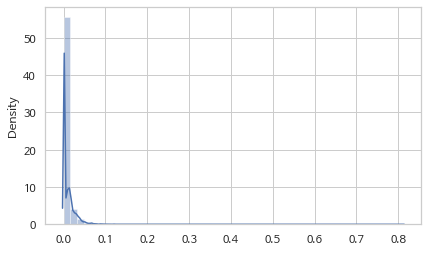

In [17]:
sns.distplot(rating_df.iloc[:,1:-2].stack())
plt.show()

### 월별, 시간대별 시청률

주로 새벽시간 / 상반기에 시청률이 낮은 양상을 보인다. 
* 평균 시청률을 넘지 않는 시간대: 오전 1시 - 8시(*3시-5시는 미방영시간대)
* 평균시청률을 넘지 않는 월 : 상반기(1-6월)

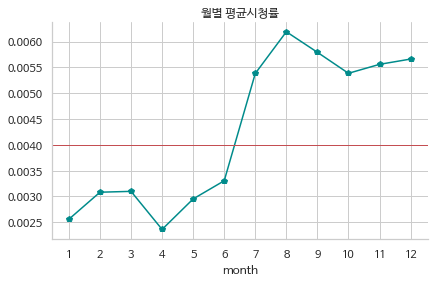

In [18]:
dfdfdf = rating_df.T.reset_index()
dfdfdf = dfdfdf.rename(dfdfdf.iloc[0],axis=1)[1:]
dfdfdf = dfdfdf.iloc[:-2,:-1]
dfdfdf.rename({'시간대':'일자'},axis=1, inplace=True)
for col in dfdfdf.columns[1:]:
    dfdfdf[col] = dfdfdf[col].astype('float64')

# 월별, 요일별, 계절별 시청률 알아보기 위한 전처리
rating_df['hour'] = rating_df['시간대'].apply(lambda x : x[0:2])
dfdfdf['일자'] = dfdfdf['일자'].astype('datetime64[ns]')
dfdfdf['month'] = dfdfdf['일자'].apply(lambda x : x.month)
dfdfdf['season'] = dfdfdf['month'].apply(lambda x : 'spring' if x >= 3 and x <= 5 else 'summer' if x >=6 and x <=8 else 'fall' if x >=9 and x <=11 else 'winter')
dfdfdf['weekday'] = dfdfdf['일자'].apply(lambda x : x.weekday())
dfdfdf['weekday'] = dfdfdf['weekday'].replace({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})

dfdfdf.groupby('month').mean().reset_index().set_index('month').mean(axis=1).plot(marker='p',color='darkcyan')
sns.despine()

plt.axhline(y=0.004, color='r', linewidth=1)
plt.xticks([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
plt.title("월별 평균시청률")
plt.show()

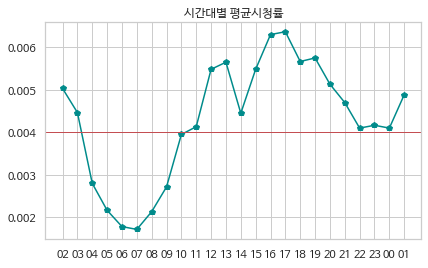

In [19]:
plt.plot(rating_df['hour'].unique()[0:-1], rating_df.groupby(['hour']).mean()['2019-01-01 to 2019-12-31'][0:-1],marker='p',color='darkcyan')
plt.axhline(y=0.004, color='r', linewidth=1)
plt.title("시간대별 평균시청률")
plt.show()

### 월별 최고 / 평균 시청률

월별 최고/평균 시청률은 전반적으로 높은 추세를 보였으나 최고시청률은 7, 8월에 특히 높은 수치를 보여주었다.

In [20]:
df111 = dfdfdf.groupby('month').mean().reset_index().set_index('month').mean(axis=1)
df222 = dfdfdf.groupby('month').max().reset_index().set_index('month').max(axis=1)
df111 = pd.DataFrame(df111,columns=['평균시청률'])
df222 = pd.DataFrame(df222,columns=['최고시청률'])
dfmonth = pd.concat([df111, df222],axis=1)

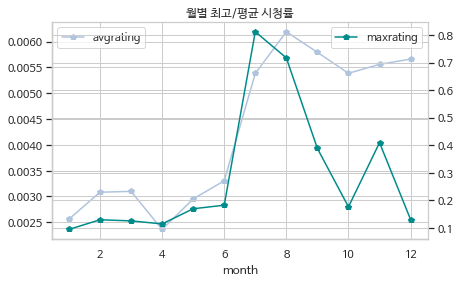

In [21]:
a = dfmonth['평균시청률']
b = dfmonth['최고시청률']

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()

a.plot(ax=ax0,lw=1.5,marker='p',color='lightsteelblue',label='avgrating')

b.plot(secondary_y=True, ax=ax1,lw=1.5,marker='p',color='darkcyan',label='maxrating')
sns.despine(ax=ax1)
sns.despine(ax=ax0)
plt.title("월별 최고/평균 시청률")
plt.legend()
ax0.legend(loc=2)
plt.show()

### 계절별 최고 / 평균 시청률

계절별 시청률의 경우 봄은 평균, 최고시청률 모두 다른계절대비 상대적으로 낮고 여름의 경우 상대적으로 모두 높았다.

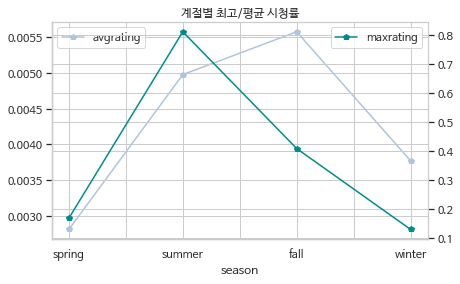

In [22]:
dfdf3= dfdfdf.groupby('season').mean().reset_index().set_index('season').iloc[:,:-1]
dfdf4 = dfdfdf.groupby('season').max().reset_index().set_index('season').iloc[:,1:-2]
dfdf3 = dfdf3.loc[['spring','summer','fall','winter']]
dfdf4 = dfdf4.loc[['spring','summer','fall','winter']]
df333 = dfdf3.mean(axis=1)
df444 = dfdf4.max(axis=1)
df333 = pd.DataFrame(df333,columns=['평균시청률'])
df444 = pd.DataFrame(df444,columns=['최고시청률'])
dfseason = pd.concat([df333, df444],axis=1)

a = dfseason['평균시청률']
b = dfseason['최고시청률']

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()
a.plot(ax=ax0,lw=1.5,marker='p',color='lightsteelblue',label='avgrating')

b.plot(secondary_y=True, ax=ax1,lw=1.5,marker='p',color='darkcyan',label='maxrating')
plt.title("계절별 최고/평균 시청률")
sns.despine(ax=ax1)
sns.despine(ax=ax0)
plt.legend()
ax0.legend(loc=2)
plt.show()

### 요일별 최고/평균 시청률

요일별 시청률의 경우 평균시청률은 월, 주말에 높게 나타난 반면 최고시청률은 목, 금요일에 높게 나타났다.

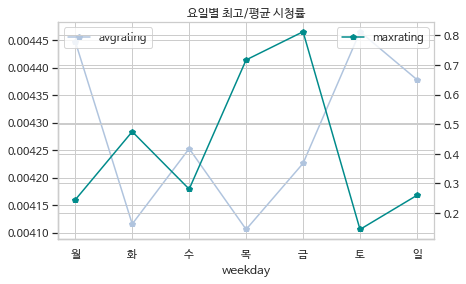

In [23]:
dfdf5= dfdfdf.groupby('weekday').mean().reset_index().set_index('weekday').iloc[:,:-1]
dfdf6= dfdfdf.groupby('weekday').max().reset_index().set_index('weekday').iloc[:,:-1]
dfdf5 = dfdf5.loc[['월','화','수','목','금','토','일']]
dfdf6 = dfdf6.iloc[:,:-1]
dfdf6 = dfdf6.loc[['월','화','수','목','금','토','일']]
df555 = dfdf5.mean(axis=1)
df666 = dfdf6.max(axis=1)
df555 = pd.DataFrame(df555,columns=['평균시청률'])
df666 = pd.DataFrame(df666,columns=['최고시청률'])
dfweekday =pd.concat([df555, df666],axis=1)

a = dfweekday['평균시청률']
b = dfweekday['최고시청률']

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()

a.plot(ax=ax0,lw=1.5,marker='p',color='lightsteelblue',label='avgrating')

b.plot(secondary_y=True, ax=ax1,lw=1.5,marker='p',color='darkcyan',label='maxrating')
plt.title("요일별 최고/평균 시청률")
sns.despine(ax=ax1)
sns.despine(ax=ax0)
plt.legend()
ax0.legend(loc=2)
plt.show()

### 시간대별 최고/평균 시청률 

시간대별 최고/평균 시청률은 오전시간에만 다른 방향으로 움직였는데, 
* 평균시청률은 10시~18시경 거의 지속적으로 다른 시간대보다 비교적 높게 나타났으나
* 최고 시청률은 00시, 06시, 11시와 같은 시간대가 다른 시간대보다 비교적 특히 높게 나타났다. 


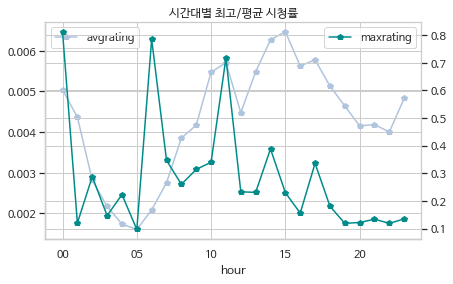

In [24]:
dfdf2 = rating_df.groupby(['hour']).mean().iloc[:-1,:-1]
dfdf3 = rating_df.groupby(['hour']).max().iloc[:-1,:-1]
dfhour1 = pd.DataFrame(dfdf2.mean(axis=1),columns=['평균시청률'])
dfhour2 = pd.DataFrame(dfdf3.max(axis=1),columns=['최고시청률'])
dfhour = pd.concat([dfhour1, dfhour2],axis=1)

a = dfhour['평균시청률']
b = dfhour['최고시청률']

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()

a.plot(ax=ax0,lw=1.5,marker='p',color='lightsteelblue',label='avgrating')

b.plot(secondary_y=True, ax=ax1,lw=1.5,marker='p',color='darkcyan',label='maxrating')
plt.title("시간대별 최고/평균 시청률")
sns.despine(ax=ax1)
sns.despine(ax=ax0)
plt.legend()
ax0.legend(loc=2)
plt.show()

### 시청률 병합

In [25]:
final_df_max = pd.read_csv('0912_실적_시청률합본(max).csv', encoding='utf-8')
final_df_avg = pd.read_csv('0912_실적_시청률합본(avg).csv', encoding='utf-8')
final_df_sum = pd.read_csv('0912_실적_시청률합본(sum).csv', encoding='utf-8')

final_df_max['방송일시'] = final_df_max['방송일시'].astype('datetime64[ns]')
final_df_avg['방송일시'] =final_df_avg['방송일시'].astype('datetime64[ns]')
final_df_sum['방송일시'] =final_df_sum['방송일시'].astype('datetime64[ns]')

final_df_max['hour'] = final_df_max['방송일시'].apply(lambda x: x.hour)
final_df_avg['hour'] =final_df_avg['방송일시'].apply(lambda x: x.hour)
final_df_sum['hour'] =final_df_sum['방송일시'].apply(lambda x: x.hour)

final_df_max['month'] = final_df_max['방송일시'].apply(lambda x: x.month)
final_df_avg['month'] =final_df_avg['방송일시'].apply(lambda x: x.month)
final_df_sum['month'] =final_df_sum['방송일시'].apply(lambda x: x.month)

final_df_max['weekday'] = final_df_max['방송일시'].apply(lambda x: x.weekday())
final_df_avg['weekday'] =final_df_avg['방송일시'].apply(lambda x: x.weekday())
final_df_sum['weekday'] =final_df_sum['방송일시'].apply(lambda x: x.weekday())

final_df_max['weekday'] = final_df_max['weekday'].replace({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})
final_df_avg['weekday'] = final_df_avg['weekday'].replace({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})
final_df_sum['weekday'] = final_df_sum['weekday'].replace({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})

final_df_max =final_df_max[final_df_max['상품군']!='무형']
final_df_avg =final_df_avg[final_df_avg['상품군']!='무형']
final_df_sum =final_df_sum[final_df_sum['상품군']!='무형']

final_df_max =final_df_max.rename({'분당시청률':'최고시청률'},axis=1)
final_df_avg =final_df_avg.rename({'분당시청률':'평균시청률'},axis=1)
final_df_sum =final_df_sum.rename({'분당시청률':'시청률합계'},axis=1)

### 상품군별 시청률

1. 평균 시청률 순위 : '잡화’ > '농수축’ > '생활용품’ > '주방’> '의류’ > '이미용’ > ‘가구’ > '속옷’ > ‘가전’ > ‘침구’ > '건강기능’
2. 최고 시청률 순위 : '생활용품’ > '농수축' > '속옷' >  '주방' > '건강기능' >  '의류' > '잡화' > '가구' >  '이미용' > '가전' > '침구'


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '가구'),
  Text(1, 0, '가전'),
  Text(2, 0, '건강기능'),
  Text(3, 0, '농수축'),
  Text(4, 0, '생활용품'),
  Text(5, 0, '속옷'),
  Text(6, 0, '의류'),
  Text(7, 0, '이미용'),
  Text(8, 0, '잡화'),
  Text(9, 0, '주방'),
  Text(10, 0, '침구')])

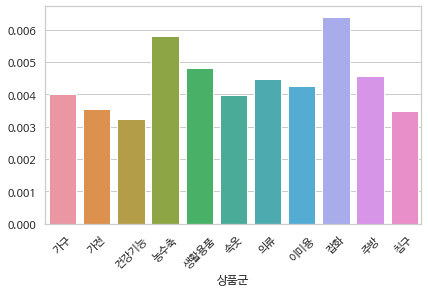

In [26]:
sns.barplot(final_df_avg.groupby('상품군').mean()['평균시청률'].index,final_df_avg.groupby('상품군').mean()['평균시청률'].values)
plt.xticks(rotation=45) #상품군별 평균시청률

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '가구'),
  Text(1, 0, '가전'),
  Text(2, 0, '건강기능'),
  Text(3, 0, '농수축'),
  Text(4, 0, '생활용품'),
  Text(5, 0, '속옷'),
  Text(6, 0, '의류'),
  Text(7, 0, '이미용'),
  Text(8, 0, '잡화'),
  Text(9, 0, '주방'),
  Text(10, 0, '침구')])

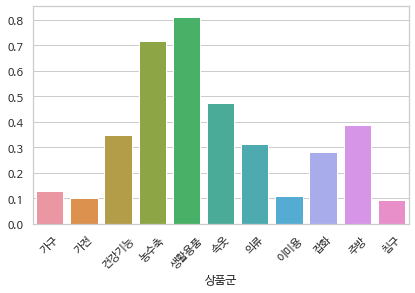

In [27]:
sns.barplot(final_df_max.groupby('상품군').max()['최고시청률'].index,final_df_max.groupby('상품군').max()['최고시청률'].values)
plt.xticks(rotation=45)#상품군별 최고시청률

### 상품군별 평균시청률, 최고시청률 비교

1. 평균시청률이 상품군 전체에서 높지만 최고시청률은 상품군 전체에서 낮은 편인 상품군: 가구, 가전, 의류, 이미용, 잡화, 주방, 침구
2. 평균시청률이 상품군 전체에서 낮지만 최고시청률은 상품군 전체에서 높은 편인 상품군 : 생활용품


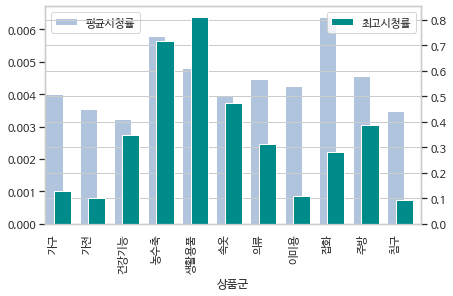

In [28]:
a = final_df_avg.groupby('상품군').mean()['평균시청률']

b = final_df_max.groupby('상품군').max()['최고시청률']

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()

a.plot(kind='bar',ax=ax0,color='lightsteelblue')

b.plot(kind='bar', secondary_y=True,color='darkcyan',position=0, ax=ax1)
plt.legend()
ax0.legend()
ax0.grid(False)


### 월별 상품군별 평균시청률



In [29]:
month_cat_rat_df = final_df_avg.groupby(['month','상품군']).mean()['평균시청률']
month_cat_rat_df =month_cat_rat_df.reset_index()
month_cat_rat_df

,month,상품군,평균시청률
0,1,가전,0.002507
1,1,건강기능,0.001062
2,1,농수축,0.003918
3,1,생활용품,0.002164
4,1,속옷,0.001955
...,...,...,...
122,12,속옷,0.007562
123,12,의류,0.006222
124,12,이미용,0.004741
125,12,잡화,0.008161


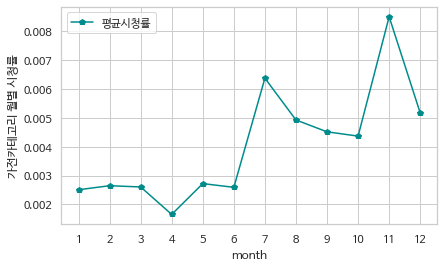

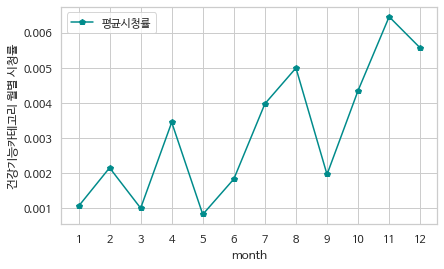

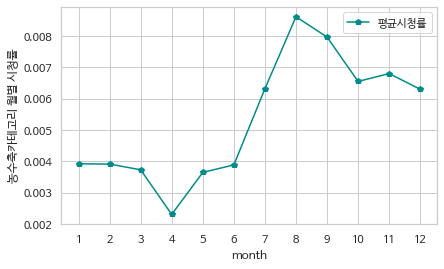

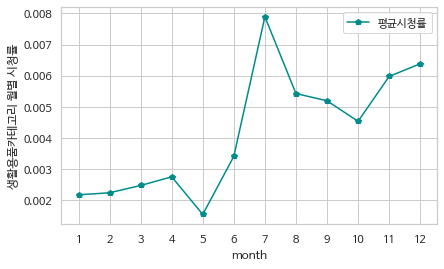

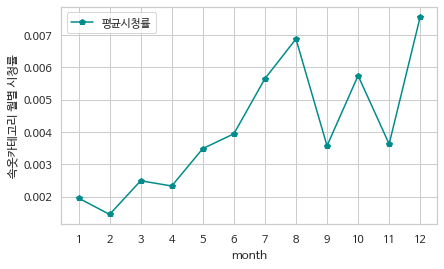

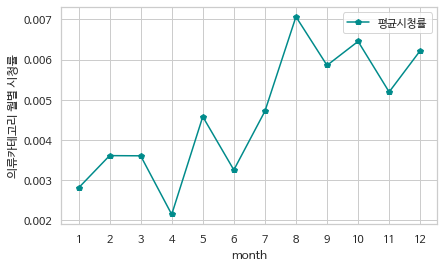

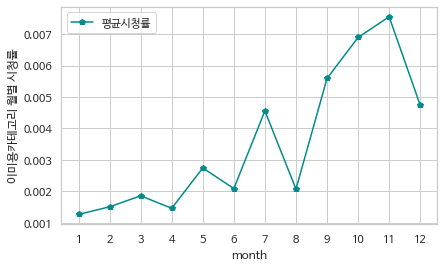

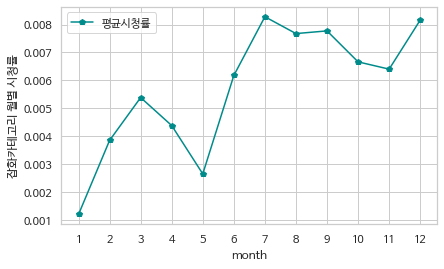

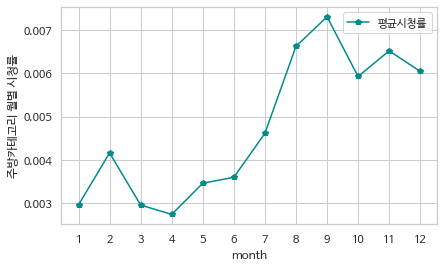

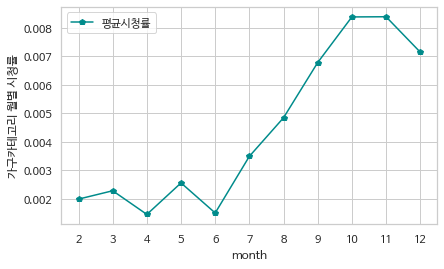

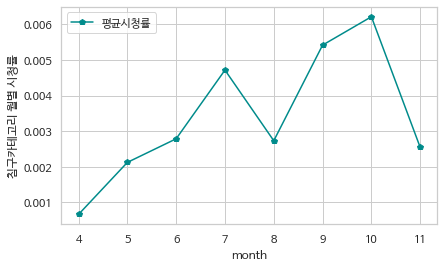

In [30]:
month_cat_rat_df.set_index('month', inplace=True)
for category in month_cat_rat_df['상품군'].unique():
    df = month_cat_rat_df[month_cat_rat_df['상품군'] == category]
    df.plot(marker='p',color='darkcyan')
    plt.xticks(df.index)
    plt.ylabel(category + '카테고리 월별 시청률')
plt.show()

### 요일별 상품군별 시청률

In [31]:
weekday_cat_rat_df = final_df_avg.groupby(['weekday','상품군']).mean()['평균시청률']
weekday_cat_rat_df =weekday_cat_rat_df.reset_index()
#weekday_cat_rat_df=weekday_cat_rat_df.set_index('weekday')
weekday_cat_rat_df


,weekday,상품군,평균시청률
0,금,가구,0.003544
1,금,가전,0.002721
2,금,건강기능,0.006094
3,금,농수축,0.005241
4,금,생활용품,0.005664
...,...,...,...
72,화,의류,0.004741
73,화,이미용,0.002609
74,화,잡화,0.007245
75,화,주방,0.003861


In [32]:
weekday_cat_rat_df = final_df_avg.groupby(['weekday','상품군']).mean()['평균시청률']

weekday_cat_rat_df =weekday_cat_rat_df.reset_index()
weekday_cat_rat_df.set_index('weekday', inplace=True)
#weekday_cat_rat_df=weekday_cat_rat_df.set_index('weekday')
weekday_cat_rat_df


,상품군,평균시청률
weekday,,
금,가구,0.003544
금,가전,0.002721
금,건강기능,0.006094
금,농수축,0.005241
금,생활용품,0.005664
...,...,...
화,의류,0.004741
화,이미용,0.002609
화,잡화,0.007245


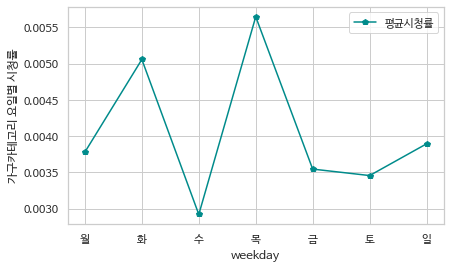

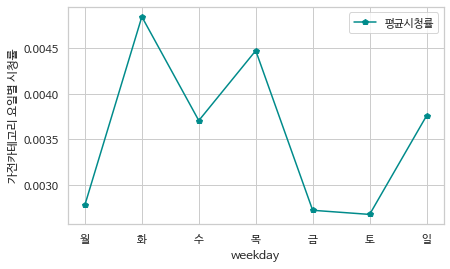

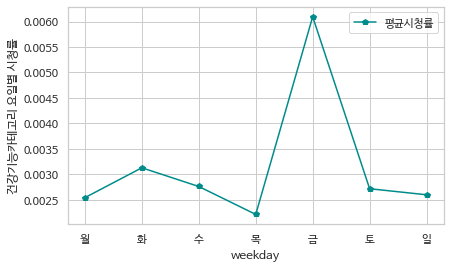

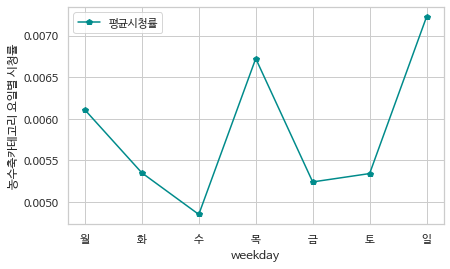

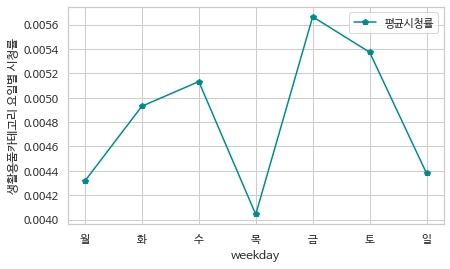

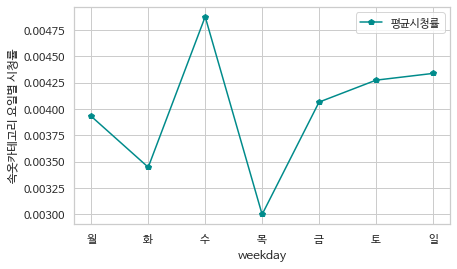

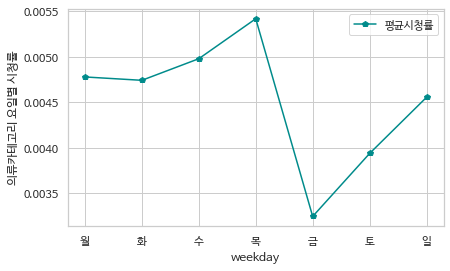

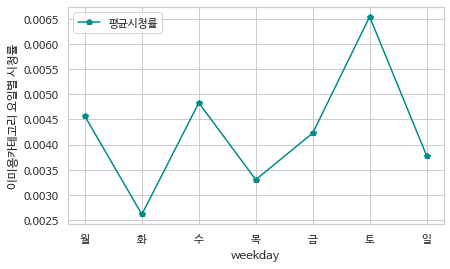

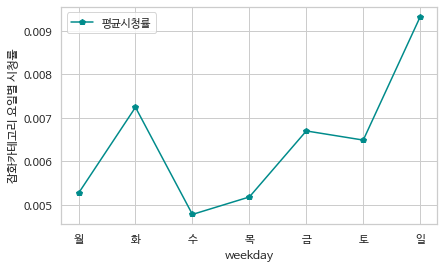

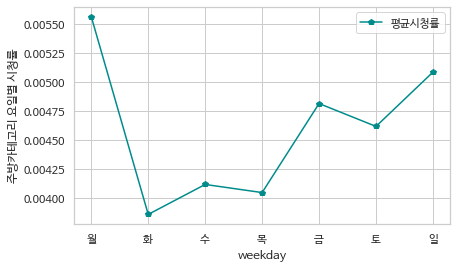

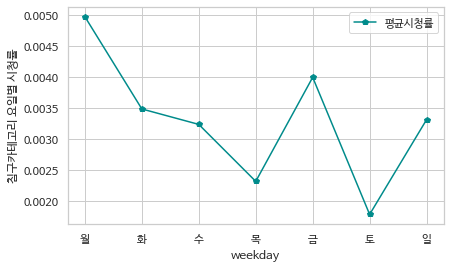

In [33]:
for category in weekday_cat_rat_df['상품군'].unique():
    df = weekday_cat_rat_df[weekday_cat_rat_df['상품군'] == category]
    df = df.iloc[[3,6,2,1,0,5,4]]
    df.plot(marker='p',color='darkcyan')
    plt.ylabel(category + '카테고리 요일별 시청률')
plt.show()

### 시간대별 상품군별 평균시청률

In [34]:
rat_hour_df = final_df_avg.groupby(['상품군','hour']).mean()['평균시청률']
rat_hour_df = rat_hour_df.reset_index()
rat_hour_df = rat_hour_df.set_index('hour')
rat_hour_df

,상품군,평균시청률
hour,,
0,가구,NaN
1,가구,NaN
2,가구,0.000000
6,가구,0.004503
7,가구,0.006495
...,...,...
14,침구,0.002917
15,침구,0.006688
21,침구,0.003650


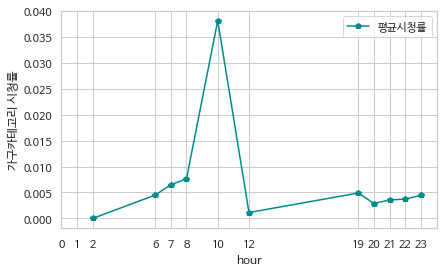

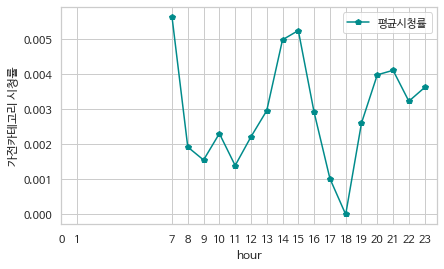

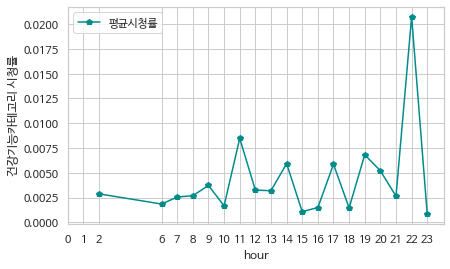

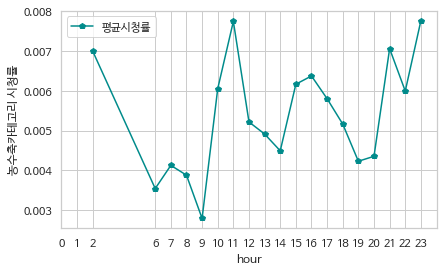

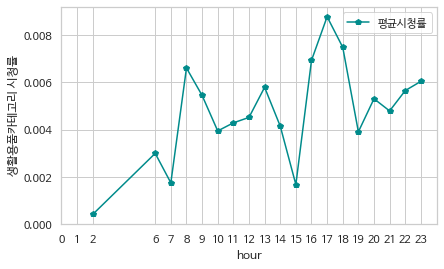

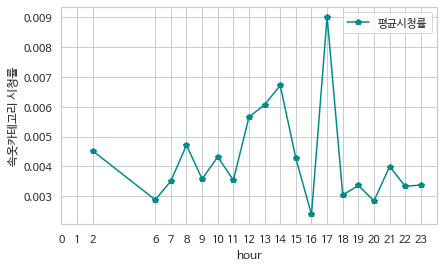

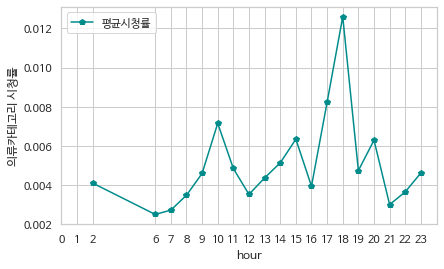

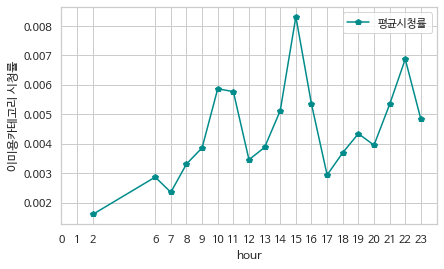

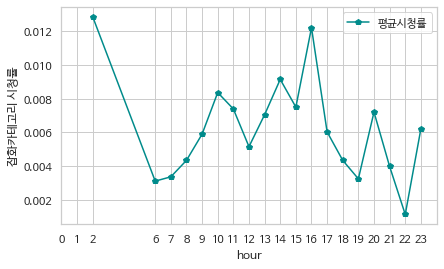

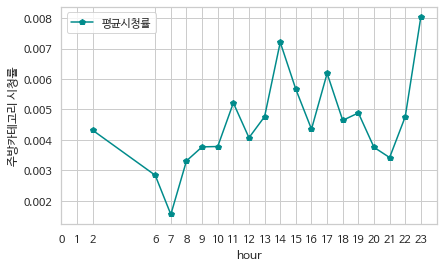

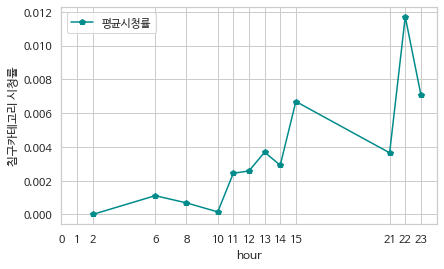

In [35]:
for category in rat_hour_df['상품군'].unique():
    df = rat_hour_df[rat_hour_df['상품군'] == category]
    df.plot(marker='p',color='darkcyan')
    plt.xticks(df.index)
    plt.ylabel(category + '카테고리 시청률')
plt.show()

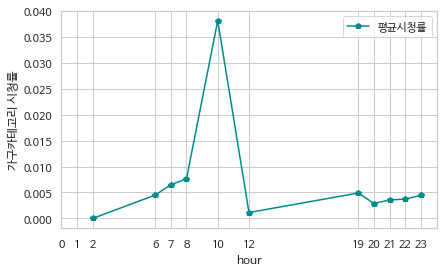

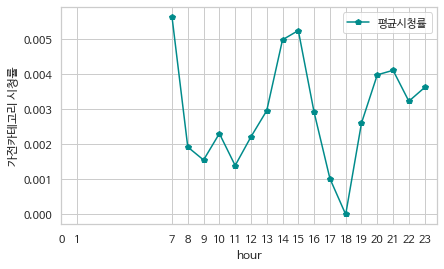

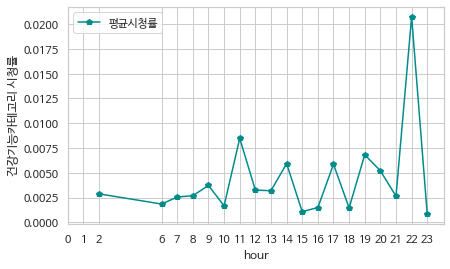

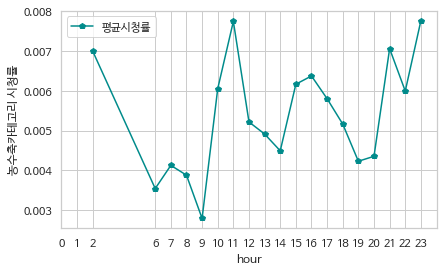

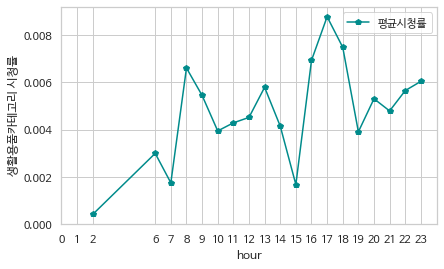

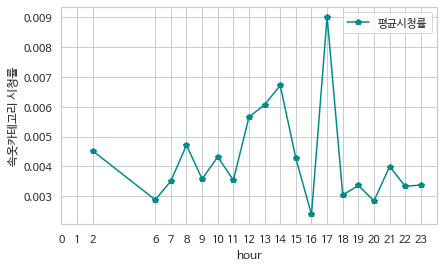

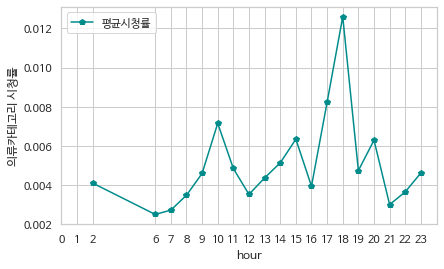

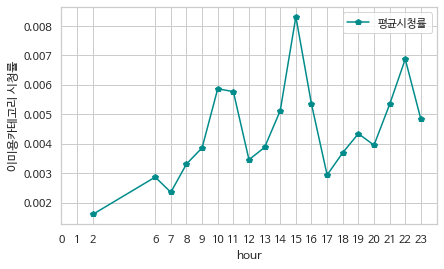

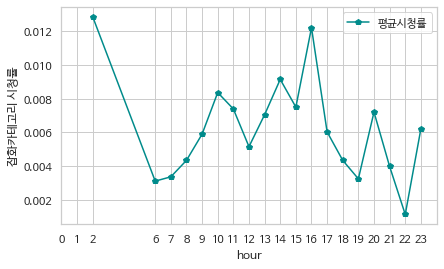

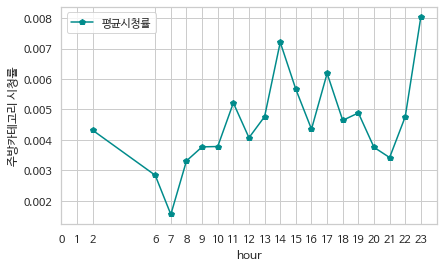

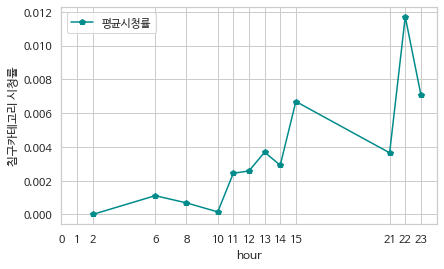

In [36]:
rat_hour_df = final_df_avg.groupby(['상품군','hour']).mean()['평균시청률']

rat_hour_df = rat_hour_df.reset_index()
rat_hour_df = rat_hour_df.set_index('hour')
rat_hour_df

for category in rat_hour_df['상품군'].unique():
    df = rat_hour_df[rat_hour_df['상품군'] == category]
    df.plot(marker='p',color='darkcyan')
    plt.xticks(df.index)
    plt.ylabel(category + '카테고리 시청률')
plt.show()

## 변수별 탐색 - 외부데이터

> 외부데이터 설명을 위해 아래 변수 생성/가공파트에서 이미 가공이 끝난 데이터를 불러와 분석에 활용한다.



In [37]:
eda_train = pd.read_pickle('train_data_0926.pkl')

## **1. 강수량**

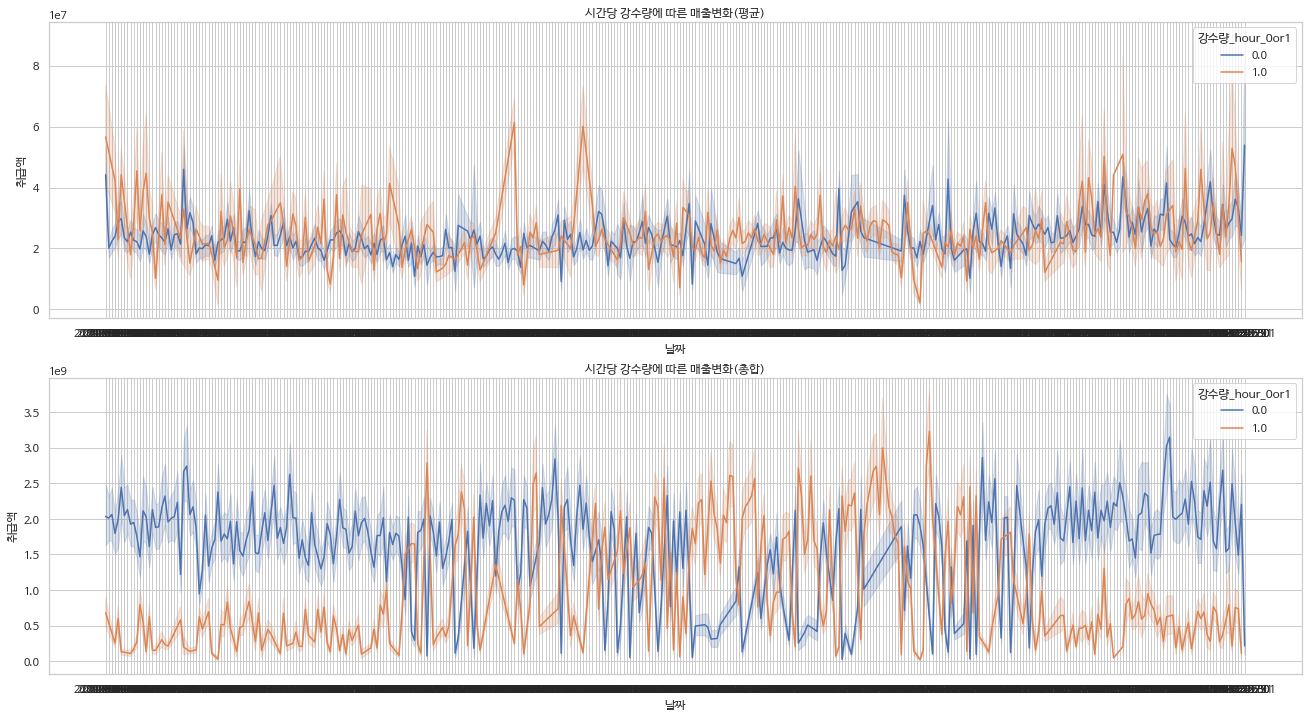

In [38]:
fig = plt.figure(figsize = [20,12])
ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x  = "날짜", y = "취급액", data = eda_train, hue = "강수량_hour_0or1")
ax1 = plt.title("시간당 강수량에 따른 매출변화(평균)")

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lineplot(x  = "날짜", y = "취급액", data = eda_train, estimator="sum", hue = "강수량_hour_0or1")
ax2 = plt.title("시간당 강수량에 따른 매출변화(총합)")

강수량이 상대적으로 많은 달에는 당연히 매출액이 높고 아닌 날에는 매출액이 낮다.

예측해야할 매출은 2020년 6월 매출이다. 즉 6월달의 변수를 봐야하는데 6월에 비가오는 날과 안오는 날은 사실상 50:50 비중을 가지고 있다. 그 상황에서 시간대별 강수량이 발생하고, 그것이 어느정도 영향을 주는 모습이 보이기에 활용할 필요성이 보인다(12월이나 1월이면 큰 영향이 없다고 보여짐) -> 또한 강수량에 따라 취급해야할 품목이 달라지고 그것이 또한 취급액의 차이로 연결될 가능성이 커 보인다.

## **2. 시간변수**

In [39]:
eda_train["주문량"] = round(eda_train["취급액"] / eda_train["판매단가"], 0)

### 휴일 : 평일, 주말, 공휴일

휴일 여부에 따라 시청층 및 구매패턴에 차이 
→ 상품군별로 휴일에 잘 반응하는 상품군, 그렇지 않은 상품군이 존재  

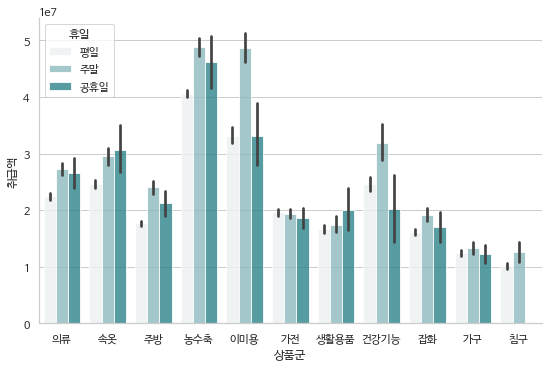

In [40]:
g = sns.catplot(
    data=eda_train, kind="bar",
    x="상품군", y="취급액", hue="휴일", palette='light:#1c9099', alpha=.8, height=5, aspect=1.5, legend_out=False,
    hue_order=['평일', '주말', '공휴일']
)

### 휴일카테고리

근접한 날 의 특성에 따라 소비심리가 변할 수 있는 점(휴일 전날 새벽 등) 을  반영
-> 7개 휴일카테고리 설정 

1. 평일 중 마지막날이 아닌 날
2. 평일 중 마지막날
3. 하루만 휴일인 날
4. 이틀짜리 휴일 중 마지막날이 아닌 날
5. 이틀짜리 휴일 중 마지막날
6. 삼일 이상의 휴일 중 마지막날이 아닌 날 
7. 삼일 이상의 휴일 중 마지막 날 

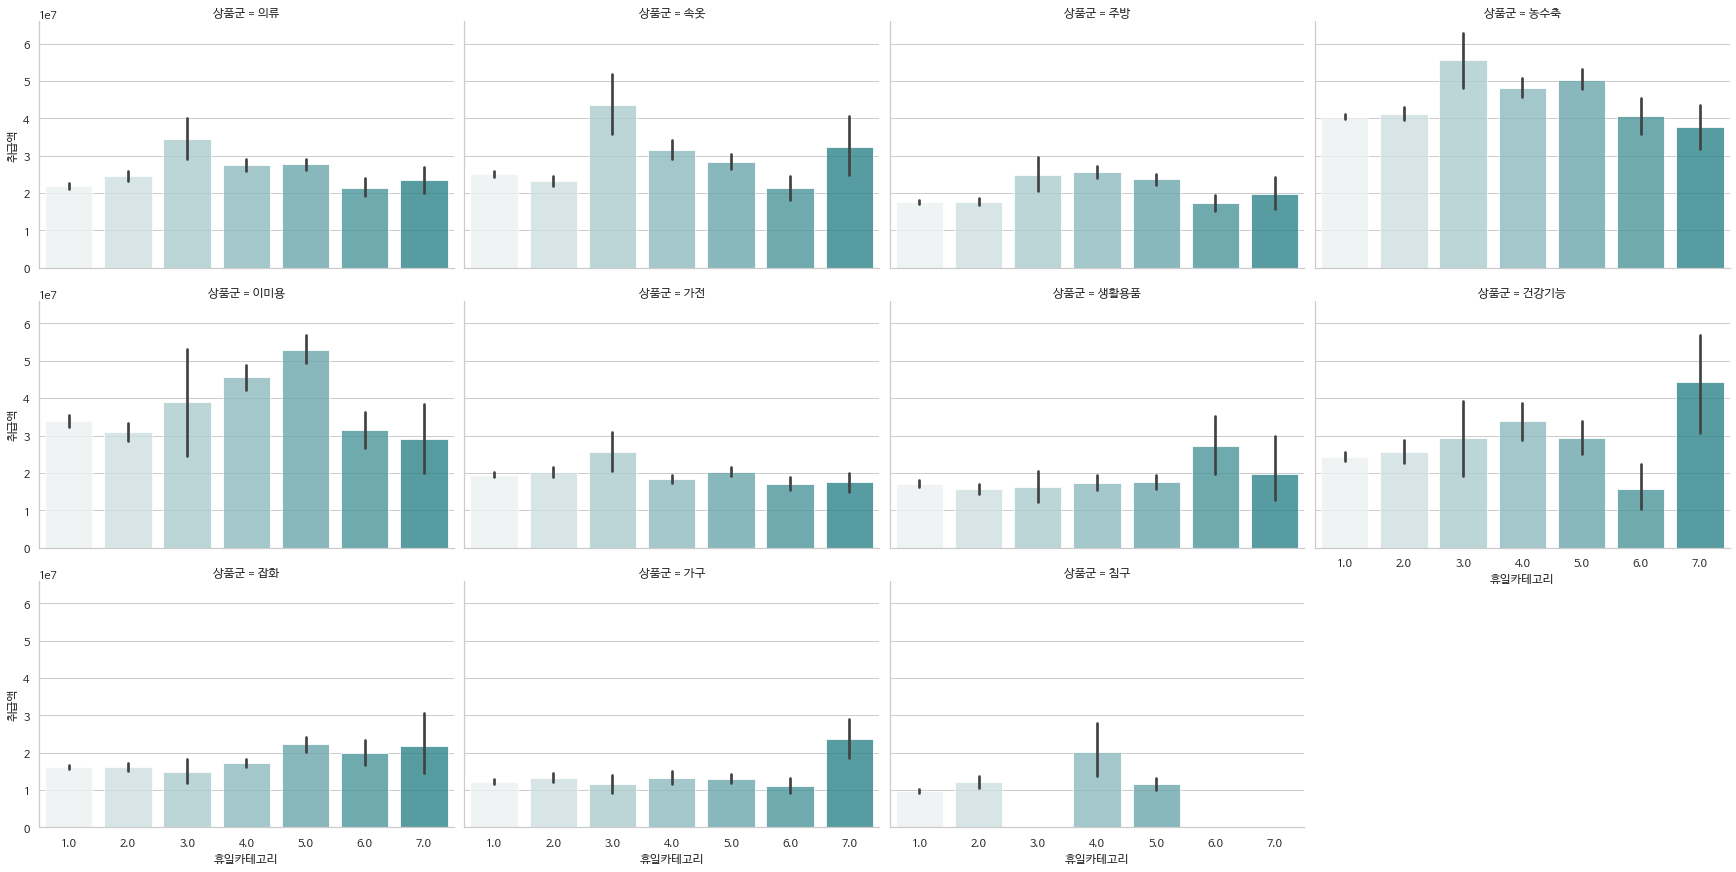

In [41]:
sns.catplot(
    data=eda_train, kind="bar",
    x="휴일카테고리", y="취급액", col="상품군", palette="light:#1c9099",col_wrap=4, alpha=.8, height=4, aspect=1.5, legend_out=False,
)
plt.show()

### 시간카테고리 

같은 날에도 시간에 따라 시청률 변화 등 판매에 큰 영향을 미칠 수 있는 시간(프라임 시간대) 등 구분
-> 7개 시간카테고리 설정 

① 심야(자정-) ② 새벽(6-7시) ③ 오전(8-10시) 
④ 오후(정오-3시) ⑤ 저녁 7-9시 ⑥ 저녁 9-12시
⑦ 그 외


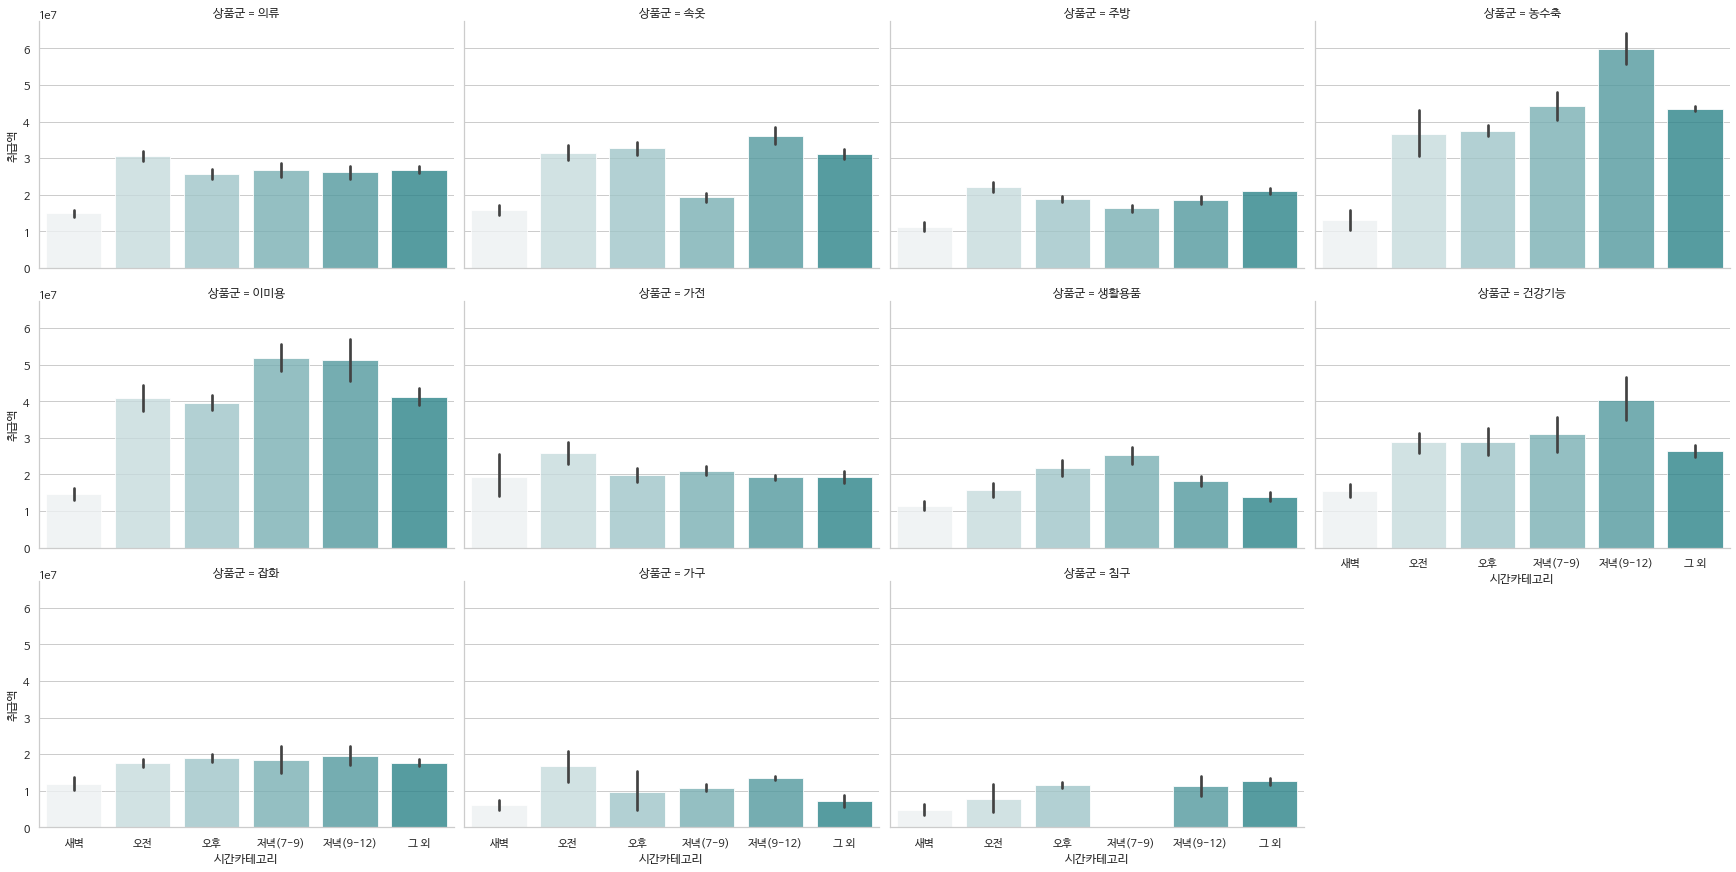

In [42]:
sns.catplot(
    data=eda_train, kind="bar",
    x="시간카테고리", y="취급액", col="상품군", col_wrap=4, palette="light:#1c9099", alpha=.8, height=4, aspect=1.5, legend_out=False,
    order=['새벽', '오전', '오후', '저녁(7-9)', '저녁(9-12)', '그 외']
)
plt.show()

# **변수 생성/처리 part - Train set, Test Set (대부분 완료)**

## 데이터 변수 목록

* 제공 데이터 변수 
* 시간 변수(category) : `요일`, `휴일`, `계절`, `휴일카테고리`, `시간카테고리`
* 시간 변수(continuous) : `dayofyear`, `날짜`, `주`, `월`, `일`, `시`, `분`, `휴일길이`
* 성별, 지불방식, 묶음상품여부, 계절성상품 : `sex`, `payment`, `bundle`, `season`
* 미세먼지 변수(시간별) : `인구가중치`, `PM10`, `PM2.5`, `경보`, `주의보`, `new_`, `new_PM10`, `new_PM2`, `경보new`, `주의보new`, `경보10`, `주의보10`, `경보2`, `주의보2` 
* `누적노출(분)`
* 강수량 : `강수량_hour_0or1`, `강수량(mm)_가중치`, `강수량(mm)_총합`
* `기온`, `습도(%)`, `불쾌지수` 
* 시청률 : `최고분당시청률`, `평균분당시청률`, `분당시청률합계`
* 시간당 취급액 / 시청률 : `rating`, `purchase_hour`, `시간당 취급액/시청률`

----------------------------------------------------------------------

In [43]:
train_df=pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx", header=1)
test_df=pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx", header=1)
train_df.shape, test_df.shape

((38309, 8), (2891, 8))

* 노출(분)이 NaN값으로 비어있는 경우를 제거하기 위해 fillna(method='pad')를 이용해 처리함.

* 취급액 NaN인 변수의 경우 예측에서 제외
* 판매단가 = 0 인 변수 또한 예측에서 제외(test)

In [44]:
train_df['노출(분)'].fillna(method='pad', inplace=True)
test_df['노출(분)'].fillna(method='pad', inplace=True)
train_df

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,20.000000,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,20.000000,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0
...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38305,2020-01-01 00:40:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38306,2020-01-01 01:00:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38307,2020-01-01 01:20:00,20.000000,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,NaN


In [45]:
test_df

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN


In [46]:
train_df.drop(train_df[train_df.취급액.isnull()].index, inplace=True)
test_df.drop(test_df[test_df.판매단가 == 0].index, inplace=True)
train_df.shape, test_df.shape

((35379, 8), (2716, 8))

In [47]:
train_df.reset_index(drop=True, inplace=True)
train_df.rename(columns={'방송일시':'date'}, inplace=True)

test_df.reset_index(drop=True, inplace=True)
test_df.rename(columns={'방송일시':'date'}, inplace=True)

train_df.columns, test_df.columns

(Index(['date', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object'),
 Index(['date', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object'))

### 시간변수 가공

* 방영일시에서 주, 월, 일, 시, 분, 요일 분해
* 계절변수(봄: 3-5월, 여름: 6-9월, 가을: 9-11월, 겨울:12-2월)

(심야시간대를 하루 앞으로 당겨서 해석하는 함수도 제작하였으나, 예측에는 활용하지 않았음.)

In [48]:
def dawnConvert(time):
  "심야시간대 하루 당겨주는 함수"
  if 0 <= time.hour < 3:
    time = time - timedelta(days=1)
  return time

def season(month):
  if month in [3, 4, 5]:
    return '봄'
  elif month in [6, 7, 8]:
    return  '여름'
  elif month in [9, 10, 11]:
    return '가을'
  else:
    return '겨울'

def TransformDate(df, original=True):
  "시간 분해 함수, original=False 적용시 심야시간대는 하루 앞으로"
  if original:
    df['날짜'] = df['date'].dt.strftime('%Y-%m-%d')
    df['dayofyear'] = df['date'].dt.strftime('%j').astype(int)
    df['주'] = df['date'].dt.strftime('%U').astype(int)
    df['월'] = df['date'].dt.strftime('%m').astype(int)
    df['일'] = df['date'].dt.strftime('%d').astype(int)
    df['시'] = df['date'].dt.strftime('%H').astype(int)
    df['분'] = df['date'].dt.strftime('%M').astype(int)
    df['요일'] = df['date'].dt.day_name()
    df['계절'] = df['월'].apply(season)

  else:
    df['date2'] = df['date'].apply(dawnConvert)
    df['날짜'] = df['date2'].dt.strftime('%Y-%m-%d')
    df['dayofyear'] = df['date2'].dt.strftime('%j').astype(int)
    df['주'] = df['date2'].dt.strftime('%U').astype(int)
    df['월'] = df['date2'].dt.strftime('%m').astype(int)
    df['일'] = df['date2'].dt.strftime('%d').astype(int)
    df['시'] = df['date2'].dt.strftime('%H').astype(int)
    df['분'] = df['date2'].dt.strftime('%M').astype(int)
    df['요일'] = df['date2'].dt.day_name()
    df['계절'] = df['월'].apply(season)

    df.drop(['date2'], axis=1, inplace=True)

In [49]:
TransformDate(train_df)
TransformDate(test_df)

## 휴일 카테고리 생성

### 휴일지속일수 조사 
* 평일일 경우 : 0으로 입력
* 1, 2, 3, ..일 연속 휴일일 경우 : 숫자 입력
* 휴일 길이 생성 함수는 현재 날짜가 휴일(공휴일, 주말)로 나타났을 시 다음날도 휴일인지, 아닌지 조사하여 총 연속된 휴일 날짜수를 삽입하는 재귀함수를 작성하였음.


In [50]:
holidayStack = []

In [51]:
def getHolidayLength(date, begin, day=0):
  "휴일 길이 생성 함수, 첫날은 본인이 설정(앞날을 확인할 수 없음)"
  if day == 0:
    date.loc[0, '휴일길이'] = int(begin)
    day += 1
  if day >= date.shape[0]:
    print("휴일 길이 생성 완료!")
    return
  
  if date.loc[day,'휴일'] in ['주말', '공휴일']:
    holidayStack.append(day)
    getHolidayLength(date, begin, day + 1)
    
    holidaySize = len(holidayStack)
    date.loc[day, '휴일길이'] = int(holidaySize)
    
    if pd.notna(date.loc[day-1, '휴일길이']):
      while(len(holidayStack) != 0):
        holidayStack.pop()
      getHolidayLength(date, begin, day + holidaySize)

  elif date.loc[day,'휴일'] in ['평일']:
    date.loc[day, '휴일길이'] = int(0)
    if pd.isnull(date.loc[day-1, '휴일길이']):
      return 
    else:
      getHolidayLength(date, begin, day + 1)

* 2019년의 법정공휴일은 총 16일, train 데이터에 2020년 1월 1일도 포함되어있으므로 총 17일을 공휴일로 나타내었음
* 2020년 6월의 법정공휴일은 현충일(6월 6일) 하루
* datetime.dt.weekday 메소드를 이용해 그 날이 주말인지, 평일인지 나타내었음


In [52]:
## 2019년
train_date = pd.date_range('2019-01-01', periods=366, freq='D')
train_date = pd.DataFrame({'Date': train_date})
train_date['날짜'] = train_date['Date'].dt.strftime('%Y-%m-%d')
train_date['요일'] = train_date['Date'].dt.weekday
train_date.drop(['Date'], axis=1, inplace=True)

holiday_list_2019 = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-06', '2019-05-12', '2019-06-06',
                '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25', '2020-01-01']

for c in range(train_date.shape[0]):
  if train_date.loc[c,:]['날짜'] in holiday_list_2019:
    train_date.loc[c,'휴일'] = '공휴일'
  elif train_date.loc[c,:]['요일'] in [5, 6]:
    train_date.loc[c,'휴일'] = '주말'
  else:
    train_date.loc[c,'휴일'] = '평일'

train_date

,날짜,요일,휴일
0,2019-01-01,1,공휴일
1,2019-01-02,2,평일
2,2019-01-03,3,평일
3,2019-01-04,4,평일
4,2019-01-05,5,주말
...,...,...,...
361,2019-12-28,5,주말
362,2019-12-29,6,주말
363,2019-12-30,0,평일
364,2019-12-31,1,평일


In [53]:
## 2020년
test_date = pd.date_range('2020-06-01', periods=31, freq='D')
test_date = pd.DataFrame({'Date': test_date})
test_date['날짜'] = test_date['Date'].dt.strftime('%Y-%m-%d')
test_date['요일'] = test_date['Date'].dt.weekday
test_date.drop(['Date'], axis=1, inplace=True)

holiday_list_2020 = ['2020-06-06']

for c in range(test_date.shape[0]):
  if test_date.loc[c,:]['날짜'] in holiday_list_2020:
    test_date.loc[c,'휴일'] = '공휴일'
  elif test_date.loc[c,:]['요일'] in [5, 6]:
    test_date.loc[c,'휴일'] = '주말'
  else:
    test_date.loc[c,'휴일'] = '평일'

test_date

,날짜,요일,휴일
0,2020-06-01,0,평일
1,2020-06-02,1,평일
2,2020-06-03,2,평일
3,2020-06-04,3,평일
4,2020-06-05,4,평일
5,2020-06-06,5,공휴일
6,2020-06-07,6,주말
7,2020-06-08,0,평일
8,2020-06-09,1,평일
9,2020-06-10,2,평일


* 함수 특성상 앞날을 확인할 수 없으므로, 
* 2019년의 경우 첫날인 2019-01-01은 공휴일로, 앞뒤로 연속한 휴일이 없으므로 휴일생성함수 argument로 begin=1을 넣어주고 함수를 실행. 
* 2020년의 경우 첫날인 2020-01-01은 평일로, begin=0을 넣어주고 함수를 실행.
* 총 휴일지속일수를 조사 완료함.

In [54]:
getHolidayLength(train_date, 1)
getHolidayLength(test_date, 0)

휴일 길이 생성 완료!
휴일 길이 생성 완료!
휴일 길이 생성 완료!


## 휴일카테고리 변수 생성

* 근접한 날의 특성에 따라 소비심리가 변할 수 있는 점(휴일 전날 새벽 등)을 구분, 반영하기 위함
* 오늘 날짜 및 다음날의 휴일여부를 조사하여 다음과 같이 7개의 휴일카테고리 변수를 생성함.
 
1. 평일 중 마지막날이 아닌 날
2. 평일 중 마지막날
3. 하루만 휴일인 날
4. 이틀짜리 휴일 중 마지막날이 아닌 날
5. 이틀짜리 휴일 중 마지막날
6. 삼일 이상의 휴일 중 마지막날이 아닌 날 
7. 삼일 이상의 휴일 중 마지막 날 

In [55]:
def holiday_category(date, final):
  "휴일 변수 생성 함수 / 마지막은 본인이 설정"
  date.loc[date.shape[0]-1, '휴일카테고리'] = int(final)
  
  for day in range(date.shape[0]):
    if day == date.shape[0] - 1:
      break

    if date.loc[day, '휴일길이'] == 0 and date.loc[day + 1, '휴일길이'] == 0: # 평일 중 마지막날이 아닌 날
      date.loc[day, '휴일카테고리'] = 1
    elif date.loc[day, '휴일길이'] == 0 and date.loc[day + 1, '휴일길이'] != 0: # 평일 중 마지막날
      date.loc[day, '휴일카테고리'] = 2
    elif date.loc[day, '휴일길이'] == 1 and date.loc[day + 1, '휴일길이'] == 0: # 하루만 휴일인 날
      date.loc[day, '휴일카테고리'] = 3
    elif date.loc[day, '휴일길이'] == 2 and date.loc[day + 1, '휴일길이'] != 0: # 이틀짜리 휴일 중 마지막날이 아닌 날(첫째날)
      date.loc[day, '휴일카테고리'] = 4
    elif date.loc[day, '휴일길이'] == 2 and date.loc[day + 1, '휴일길이'] == 0: # 이틀짜리 휴일 중 마지막날
      date.loc[day, '휴일카테고리'] = 5
    elif date.loc[day, '휴일길이'] >= 3 and date.loc[day + 1, '휴일길이'] != 0: # 삼일 이상의 휴일 중 마지막날이 아닌 날
      date.loc[day, '휴일카테고리'] = 6
    elif date.loc[day, '휴일길이'] >= 3 and date.loc[day + 1, '휴일길이'] == 0: # 삼일 이상의 휴일 중 마지막날
      date.loc[day, '휴일카테고리'] = 7

* 마지막 날의 경우, 다음날이 휴일인지 여부를 알 수 없으므로 직접 조사하여 입력함 (함수 argument로 입력)
* Train : (20.01.01은 휴일, 20.01.02는 평일이므로 20.01.01의 휴일카테고리는 3으로 입력
* Test : 20.07.01은 평일, 20.07.02도 평일이므로 20.07.01의 휴일카테고리는 1으로 입력

In [56]:
holiday_category(train_date, 3)
train_date

,날짜,요일,휴일,휴일길이,휴일카테고리
0,2019-01-01,1,공휴일,1.0,3.0
1,2019-01-02,2,평일,0.0,1.0
2,2019-01-03,3,평일,0.0,1.0
3,2019-01-04,4,평일,0.0,2.0
4,2019-01-05,5,주말,2.0,4.0
...,...,...,...,...,...
361,2019-12-28,5,주말,2.0,4.0
362,2019-12-29,6,주말,2.0,5.0
363,2019-12-30,0,평일,0.0,1.0
364,2019-12-31,1,평일,0.0,2.0


In [57]:
holiday_category(test_date, 1)
test_date

,날짜,요일,휴일,휴일길이,휴일카테고리
0,2020-06-01,0,평일,0.0,1.0
1,2020-06-02,1,평일,0.0,1.0
2,2020-06-03,2,평일,0.0,1.0
3,2020-06-04,3,평일,0.0,1.0
4,2020-06-05,4,평일,0.0,2.0
5,2020-06-06,5,공휴일,2.0,4.0
6,2020-06-07,6,주말,2.0,5.0
7,2020-06-08,0,평일,0.0,1.0
8,2020-06-09,1,평일,0.0,1.0
9,2020-06-10,2,평일,0.0,1.0


* 이렇게 만들어진 날짜별 휴일 길이, 휴일카테고리를 기존 데이터에 병합시킴

In [58]:
train_df = pd.merge(train_df, train_date[['날짜', '휴일', '휴일길이', '휴일카테고리']], on='날짜', how='left')
train_df

,date,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,dayofyear,주,월,일,시,분,요일,계절,휴일,휴일길이,휴일카테고리
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,1,0,1,1,6,0,Tuesday,겨울,공휴일,1.0,3.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,1,0,1,1,6,0,Tuesday,겨울,공휴일,1.0,3.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,1,0,1,1,6,20,Tuesday,겨울,공휴일,1.0,3.0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,1,0,1,1,6,20,Tuesday,겨울,공휴일,1.0,3.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,1,0,1,1,6,40,Tuesday,겨울,공휴일,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35374,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019-12-31,365,52,12,31,23,40,Tuesday,겨울,평일,0.0,2.0
35375,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020-01-01,1,0,1,1,0,0,Wednesday,겨울,공휴일,1.0,3.0
35376,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020-01-01,1,0,1,1,0,0,Wednesday,겨울,공휴일,1.0,3.0
35377,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020-01-01,1,0,1,1,0,0,Wednesday,겨울,공휴일,1.0,3.0


In [59]:
test_df = pd.merge(test_df, test_date[['날짜', '휴일', '휴일길이', '휴일카테고리']], on='날짜', how='left')
test_df

,date,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,dayofyear,주,월,일,시,분,요일,계절,휴일,휴일길이,휴일카테고리
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,153,22,6,1,6,20,Monday,여름,평일,0.0,1.0
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,153,22,6,1,6,40,Monday,여름,평일,0.0,1.0
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,153,22,6,1,7,0,Monday,여름,평일,0.0,1.0
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01,153,22,6,1,7,20,Monday,여름,평일,0.0,1.0
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01,153,22,6,1,7,40,Monday,여름,평일,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,2020-07-01,183,26,7,1,0,10,Wednesday,여름,평일,0.0,1.0
2712,2020-07-01 00:10:00,10.000000,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,2020-07-01,183,26,7,1,0,10,Wednesday,여름,평일,0.0,1.0
2713,2020-07-01 00:10:00,10.000000,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,2020-07-01,183,26,7,1,0,10,Wednesday,여름,평일,0.0,1.0
2714,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,2020-07-01,183,26,7,1,1,20,Wednesday,여름,평일,0.0,1.0


## 시간 카테고리 변수 생성

* 같은 날에도 시간에 따라 시청률 변화 등 판매에 큰 영향을 미칠 수 있는 시간(프라임 시간대) 등 구분하기 위함. 
* 상품군에 따라 각각 다른 시간대에 반응하는 정도를 반영하고자 하였음.

-> 시간에 따라 7개 카테고리 생성

1. 심야(자정-3시)
2. 새벽(6-7시)
3. 오전(8-10시)
4. 오후(정오-3시)
5. 저녁 7-9시
6. 저녁 9-12시
7. 그 외

In [60]:
def hour_category(hour):
  "시간 카테고리 추가 함수"
  hour = int(hour)

  if 0 <= hour < 6:
    return '심야'
  elif 6 <= hour < 7:
    return '새벽'
  elif 8 <= hour < 10:
    return '오전'
  elif 12 <= hour < 15:
    return '오후'
  elif 19 <= hour < 21:
    return '저녁(7-9)'
  elif 21 <= hour < 24:
    return '저녁(9-12)'
  else:
    return '그 외'      

In [61]:
train_df['시간카테고리'] = train_df['시'].apply(hour_category)
test_df['시간카테고리'] = test_df['시'].apply(hour_category)

In [62]:
train_df

,date,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,dayofyear,...,월,일,시,분,요일,계절,휴일,휴일길이,휴일카테고리,시간카테고리
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,1,...,1,1,6,0,Tuesday,겨울,공휴일,1.0,3.0,새벽
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,1,...,1,1,6,0,Tuesday,겨울,공휴일,1.0,3.0,새벽
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,1,...,1,1,6,20,Tuesday,겨울,공휴일,1.0,3.0,새벽
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,1,...,1,1,6,20,Tuesday,겨울,공휴일,1.0,3.0,새벽
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,1,...,1,1,6,40,Tuesday,겨울,공휴일,1.0,3.0,새벽
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35374,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019-12-31,365,...,12,31,23,40,Tuesday,겨울,평일,0.0,2.0,저녁(9-12)
35375,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020-01-01,1,...,1,1,0,0,Wednesday,겨울,공휴일,1.0,3.0,심야
35376,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020-01-01,1,...,1,1,0,0,Wednesday,겨울,공휴일,1.0,3.0,심야
35377,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020-01-01,1,...,1,1,0,0,Wednesday,겨울,공휴일,1.0,3.0,심야


In [63]:
test_df

,date,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,dayofyear,...,월,일,시,분,요일,계절,휴일,휴일길이,휴일카테고리,시간카테고리
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,153,...,6,1,6,20,Monday,여름,평일,0.0,1.0,새벽
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,153,...,6,1,6,40,Monday,여름,평일,0.0,1.0,새벽
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,153,...,6,1,7,0,Monday,여름,평일,0.0,1.0,그 외
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01,153,...,6,1,7,20,Monday,여름,평일,0.0,1.0,그 외
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01,153,...,6,1,7,40,Monday,여름,평일,0.0,1.0,그 외
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,2020-07-01,183,...,7,1,0,10,Wednesday,여름,평일,0.0,1.0,심야
2712,2020-07-01 00:10:00,10.000000,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,2020-07-01,183,...,7,1,0,10,Wednesday,여름,평일,0.0,1.0,심야
2713,2020-07-01 00:10:00,10.000000,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,2020-07-01,183,...,7,1,0,10,Wednesday,여름,평일,0.0,1.0,심야
2714,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,2020-07-01,183,...,7,1,1,20,Wednesday,여름,평일,0.0,1.0,심야


## 지불방식, 묶음상품여부 변수 생성

- 지불방식(payment) : str.contains 함수활용. '상품명'에서 '(일)', 일시불' 적용상품 payment변수에 '일'로 적용. '(무)','무이자' 적용상품은 '무' 적용
- 묶음상품여부(bundle) : str.contains 함수활용. '상품명'에서 '2종~9종', '패키지', '+' 적용된 상품을 bundle 'bundle'로 적용. 

In [64]:
def additional_feature(performance):

  lumpsum_prod1 = performance.loc[performance['상품명'].str.contains('\(일\)',na=False)]
  lumpsum_prod2 = performance.loc[performance['상품명'].str.contains('일시불',na=False)]
  lumpsum_prod_id = list(set(lumpsum_prod1.index)|set(lumpsum_prod2.index))
  nointerest_prod1 = performance.loc[performance['상품명'].str.contains('\(무\)',na=False)]
  nointerest_prod2 = performance.loc[performance['상품명'].str.contains('무이자',na=False)]
  nointerest_prod_id = list(set(nointerest_prod1.index)|set(nointerest_prod2.index))

  bundle_prod1 = performance.loc[performance['상품명'].str.contains('[2-9]종',na=False)]
  bundle_prod_id1 = list(bundle_prod1.index)
  bundle_prod2 = performance.loc[performance['상품명'].str.contains('[2-9]세트',na=False)]
  bundle_prod_id2 = list(bundle_prod2.index)
  bundle_prod3 = performance.loc[performance['상품명'].str.contains('[2-9]종세트',na=False)]
  bundle_prod_id3 = list(bundle_prod3.index)
  bundle_prod4 = performance.loc[performance['상품명'].str.contains('패키지',na=False)]
  bundle_prod_id4 = list(bundle_prod4.index)
  bundle_prod5 = performance.loc[performance['상품명'].str.contains('\+',na=False)]
  bundle_prod_id5 = list(bundle_prod5.index)
  bundle_prod_id = list(set(bundle_prod1.index)|set(bundle_prod2.index)|set(bundle_prod3.index)|set(bundle_prod4.index)|set(bundle_prod5.index))

  payment = []
  for i in range(len(performance)):
      if i in lumpsum_prod_id:
          payment.append('일')
      elif i in nointerest_prod_id:
        payment.append('무')
      else:
        payment.append('-')
  performance['payment'] = payment

  bundle = []
  for i in range(len(performance)):
      if i in bundle_prod_id:
        bundle.append('bundle')
      else:
        bundle.append('-')
  performance['bundle'] = bundle

In [65]:
additional_feature(train_df)
additional_feature(test_df)

## 상품군 교체, na_based_cluster

### 상품군 교체
* 농수축의 즙,액 -> 건강기능 
* 생활용품의 선글라스 -> 잡화
* 생활용품의 청소기,에어컨 -> 가전
* 생활용품의 치약, 면도, 바리캉 -> 이미용
* 건강기능의 생식 -> 농수축

상품군 교체 이유
* 대부분의 선글라스는 잡화로 라벨링되어 있는데 몇 개의 선글라스가 생활용품으로 라벨링되어있었음. 
* 또한, 대부분의 에어컨은 가전으로 라벨링되어 있으나 몇 개의 에어컨이 생활용품으로 라벨링되어 있었는 등

* 유사한 사례가 다수 있었음. 해당 상품군에서 다소 이질적인 상품들은 소분류시 다른상품과 묶이기 어려워, 상품군 이동하였음.

### na_based_cluster 변수

취급액이 NaN인 상품들은 유사성을 가진다고 판단, 
* 그 날 판매를 하지 않은 상품
* 그 날 취급액에 NaN이 있는 상품
* 그 날 정상적으로 판매된 상품

세 그룹으로 나누어 분포도를 그렸을 때, 대부분이 한 묶음으로 묶이고, 나머지 소수가 묶이는 형태로 두 그룹으로 군집되는데, 이때 각 군집에 고른 할당을 위해 큰 군집을 자카드 유사도 기법을 활용하여 재군집하였다.

### combination 변수

연관성 분석 변수

In [67]:
new_cat_train = pd.read_csv("subclass_N_sex_N_season.csv")
new_comb_train = pd.read_csv("apiriori.csv")
train_df = pd.concat([train_df.drop(columns="상품군", axis=1), new_cat_train[['상품군', 'na_based_cluster']]], axis=1)
train_df = pd.concat([train_df, new_comb_train[['combination']]], axis=1)

new_cat_test = pd.read_csv("subclass_N_sex_N_season(test).csv")
new_comb_test = pd.read_csv("apiriori(test).csv")
test_df = pd.concat([test_df.drop(columns="상품군", axis=1), new_cat_test[['상품군', 'na_based_cluster']]], axis=1)
test_df = pd.concat([test_df, new_comb_test[['combination']]], axis=1)

## 브랜드 성격 및 네이버 검색량

- '상품명'에 적용된 브랜드 추출 후 
* 소분류, 상품타깃성별, 상품타깃계절 추출 
* '네이버랩'에서 API 검색량 적용, ,'브랜드' 기반 병합

* 검색량 추출 과정은 search rate crawling.ipynb 참고

In [68]:
train_brand = pd.read_csv('0926_searchrate.csv')
train_brand

,브랜드명,소분류,sex,season,네이버소분류,카테고리내검색량,소분류내검색량,네이버소분류내검색량
0,테이트,유니섹스,남성,NaN,남성의류,56.69362,56.69362,61.11757
1,테이트,유니섹스,여성,NaN,여성의류,56.69362,56.69362,NaN
2,테이트,유니섹스,남성,NaN,남성의류,56.69362,56.69362,61.11757
3,테이트,유니섹스,여성,NaN,여성의류,56.69362,56.69362,NaN
4,테이트,유니섹스,남성,NaN,남성의류,56.69362,56.69362,61.11757
...,...,...,...,...,...,...,...,...
35374,쿠첸,주방가전,NaN,NaN,주방가전,NaN,NaN,NaN
35375,쿠첸,주방가전,NaN,NaN,주방가전,NaN,NaN,NaN
35376,쿠첸,주방가전,NaN,NaN,주방가전,NaN,NaN,NaN
35377,쿠첸,주방가전,NaN,NaN,주방가전,NaN,NaN,NaN


In [69]:
test_brand = pd.read_csv('0926_searchrate(test).csv')
test_brand

,브랜드명,소분류,sex,season,네이버소분류,카테고리내검색량,소분류내검색량,네이버소분류내검색량
0,잭필드,의류일반,남성,여름,남성의류,50.87719,50.87719,48.21428
1,잭필드,의류일반,남성,여름,남성의류,50.87719,50.87719,48.21428
2,잭필드,의류일반,남성,여름,남성의류,50.87719,50.87719,48.21428
3,쿠미투니카,보정속옷,여성,여름,여성언더웨어/잠옷,83.97790,NaN,83.97790
4,쿠미투니카,보정속옷,여성,여름,여성언더웨어/잠옷,83.97790,NaN,83.97790
...,...,...,...,...,...,...,...,...
2711,라쉬반,일반속옷,남성,NaN,남성언더웨어/잠옷,4.55508,NaN,4.55508
2712,라쉬반,일반속옷,남성,NaN,남성언더웨어/잠옷,4.55508,NaN,4.55508
2713,라쉬반,일반속옷,남성,NaN,남성언더웨어/잠옷,4.55508,NaN,4.55508
2714,아놀드파마,유니섹스,NaN,여름,요가/필라테스,NaN,NaN,NaN


In [70]:
train_df = pd.concat([train_df, train_brand], axis=1)
test_df = pd.concat([test_df, test_brand], axis=1)

## 미세먼지

- pd.merge 함수활용. '날짜','시간' 기반으로 [본 데이터] + [미세먼지 데이터] 병합

In [71]:
dust_bytime_train = pd.read_csv('0911_dustbytimefinal.csv')
dust_bytime_train

,day,hour,인구가중치,PM10,PM2.5,경보,주의보,new_PM10,new_PM2,경보new,주의보new,경보10,주의보10,경보2,주의보2
0,2019-01-04,20,0.001037,0,1,0,1,0.000000,0.001037,0.0,0.001037,0.0,0.000000,0.0,0.001037
1,2019-01-05,2,0.001346,0,1,0,1,0.000000,0.001346,0.0,0.001346,0.0,0.000000,0.0,0.001346
2,2019-01-05,3,0.287398,0,3,0,3,0.000000,0.862193,0.0,0.862193,0.0,0.000000,0.0,2.586579
3,2019-01-05,4,0.024171,0,2,0,2,0.000000,0.048342,0.0,0.048342,0.0,0.000000,0.0,0.096685
4,2019-01-05,5,0.080367,0,2,0,2,0.000000,0.160733,0.0,0.160733,0.0,0.000000,0.0,0.321467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2019-12-11,16,0.029901,1,3,0,4,0.029901,0.089702,0.0,0.119602,0.0,0.119602,0.0,0.358807
414,2019-12-11,17,0.018083,0,7,0,7,0.000000,0.126578,0.0,0.126578,0.0,0.000000,0.0,0.886049
415,2019-12-17,13,0.009661,1,1,0,2,0.009661,0.009661,0.0,0.019323,0.0,0.019323,0.0,0.019323
416,2019-12-24,14,0.056790,0,1,0,1,0.000000,0.056790,0.0,0.056790,0.0,0.000000,0.0,0.056790


In [72]:
dust_bytime_test = pd.read_csv('0918_2006finedustbytime.csv')
dust_bytime_test['경보'] = 0
dust_bytime_test['new_PM10'] = dust_bytime_test['인구가중치'] * dust_bytime_test['PM10']
dust_bytime_test['new_PM2'] = dust_bytime_test['인구가중치'] * dust_bytime_test['PM2.5']
dust_bytime_test['경보new'] = dust_bytime_test['인구가중치'] * dust_bytime_test['경보']
dust_bytime_test['주의보new'] = dust_bytime_test['인구가중치'] * dust_bytime_test['주의보']
dust_bytime_test['경보10'] = dust_bytime_test['인구가중치'] * dust_bytime_test['경보'] * dust_bytime_test['PM10']
dust_bytime_test['주의보10'] = dust_bytime_test['인구가중치'] * dust_bytime_test['주의보']* dust_bytime_test['PM10']
dust_bytime_test['경보2'] = dust_bytime_test['인구가중치'] * dust_bytime_test['경보'] * dust_bytime_test['PM2.5']
dust_bytime_test['주의보2'] = dust_bytime_test['인구가중치'] * dust_bytime_test['주의보']* dust_bytime_test['PM2.5']
dust_bytime_test

,발령시일,발령시,인구가중치,PM10,PM2.5,주의보,경보,new_PM10,new_PM2,경보new,주의보new,경보10,주의보10,경보2,주의보2
0,2020-06-05,17,0.001632,0,1,1,0,0.000000,0.001632,0.0,0.001632,0.0,0.000000,0.0,0.001632
1,2020-06-05,18,0.012732,1,0,1,0,0.012732,0.000000,0.0,0.012732,0.0,0.012732,0.0,0.000000
2,2020-06-05,21,0.000500,1,0,1,0,0.000500,0.000000,0.0,0.000500,0.0,0.000500,0.0,0.000000
3,2020-06-06,3,0.000437,0,1,1,0,0.000000,0.000437,0.0,0.000437,0.0,0.000000,0.0,0.000437
4,2020-06-06,15,0.003265,1,1,2,0,0.003265,0.003265,0.0,0.006529,0.0,0.006529,0.0,0.006529
5,2020-06-08,22,0.001794,0,1,1,0,0.000000,0.001794,0.0,0.001794,0.0,0.000000,0.0,0.001794
6,2020-06-09,20,0.001632,0,1,1,0,0.000000,0.001632,0.0,0.001632,0.0,0.000000,0.0,0.001632
7,2020-06-09,22,0.001794,0,1,1,0,0.000000,0.001794,0.0,0.001794,0.0,0.000000,0.0,0.001794


In [73]:
train_df = pd.merge(train_df, dust_bytime_train, left_on =['날짜','시'], right_on =['day','hour'], how='left')
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,35369,35370,35371,35372,35373,35374,35375,35376,35377,35378
date,2019-01-01 06:00:00,2019-01-01 06:00:00,2019-01-01 06:20:00,2019-01-01 06:20:00,2019-01-01 06:40:00,2019-01-01 06:40:00,2019-01-01 07:00:00,2019-01-01 07:20:00,2019-01-01 07:40:00,2019-01-01 08:00:00,...,2019-12-31 23:20:00,2019-12-31 23:20:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
노출(분),20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
마더코드,100346,100346,100346,100346,100346,100346,100305,100305,100305,100808,...,100448,100448,100448,100448,100448,100448,100448,100448,100448,100448
상품코드,201072,201079,201072,201079,201072,201079,200974,200974,200974,202377,...,201384,201391,201383,201390,201384,201391,201383,201390,201384,201391
상품명,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,...,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용
판매단가,39900,39900,39900,39900,39900,39900,59000,59000,59000,59900,...,158000,148000,178000,168000,158000,148000,178000,168000,158000,148000
취급액,2.099e+06,4.371e+06,3.262e+06,6.955e+06,6.672e+06,9.337e+06,6.819e+06,1.5689e+07,2.537e+07,1.6133e+07,...,620000,1.664e+06,9.149e+06,1.5282e+07,2.328e+06,1.0157e+07,5.0929e+07,1.04392e+08,1.3765e+07,4.6608e+07
날짜,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,...,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2020-01-01,2020-01-01,2020-01-01,2020-01-01
dayofyear,1,1,1,1,1,1,1,1,1,1,...,365,365,365,365,365,365,1,1,1,1
주,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,0,0,0,0


In [74]:
train_df.drop(columns=['day','hour'], inplace=True)

In [75]:
test_df = pd.merge(test_df, dust_bytime_test, left_on =['날짜','시'], right_on =['발령시일','발령시'], how='left')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929
date,2020-06-01 06:20:00,2020-06-01 06:40:00,2020-06-01 07:00:00,2020-06-01 07:20:00,2020-06-01 07:40:00,2020-06-01 08:00:00,2020-06-01 08:20:00,2020-06-01 08:40:00,2020-06-01 09:00:00,2020-06-01 09:20:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
노출(분),20,20,20,20,20,20,20,20,20,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
마더코드,100650,100650,100650,100445,100445,100445,100381,100381,100381,100638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품코드,201971,201971,201971,202278,202278,202278,201247,201247,201247,201956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품명,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,램프쿡 자동회전냄비,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
판매단가,59800,59800,59800,69900,69900,69900,59000,59000,59000,109000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
취급액,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
날짜,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dayofyear,153,153,153,153,153,153,153,153,153,153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
주,22,22,22,22,22,22,22,22,22,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
test_df.drop(columns=['발령시일','발령시'], inplace=True)

## 시청률

- 최고분당시청률, 평균분당시청률, 분당시청률합계 NaN값 데이터 isnull() 함수를 통한 파악 및 drop()함수를 통한 제거
- pd.concat 함수활용, [본 데이터]와 병합
- 2020년 6월의 경우 시청률 데이터가 없으므로 2019년 5, 6, 7월의 시청률 데이터의 평균값으로 처리

In [77]:
rating_max = pd.read_csv('0912_실적_시청률합본(max).csv')
rating_avg= pd.read_csv('0912_실적_시청률합본(avg).csv')
rating_sum= pd.read_csv('0912_실적_시청률합본(sum).csv')

rating_max.rename({'분당시청률': '최고분당시청률'},axis=1,inplace=True)
rating_avg.rename({'분당시청률': '평균분당시청률'},axis=1,inplace=True)
rating_sum.rename({'분당시청률': '분당시청률합계'},axis=1,inplace=True)

In [78]:
rating_max.drop(rating_max[rating_max.취급액.isnull()].index, inplace=True)
rating_max.reset_index(drop=True, inplace=True)

rating_avg.drop(rating_avg[rating_avg.취급액.isnull()].index, inplace=True)
rating_avg.reset_index(drop=True, inplace=True)

rating_sum.drop(rating_sum[rating_sum.취급액.isnull()].index, inplace=True)
rating_sum.reset_index(drop=True, inplace=True)

print('rating_max : ', rating_max.shape[0])
print('rating_avg : ', rating_avg.shape[0])
print('rating_sum : ', rating_sum.shape[0])

rating_max :  35379
rating_avg :  35379
rating_sum :  35379


In [79]:
train_df = pd.concat([train_df, rating_max['최고분당시청률'], rating_avg['평균분당시청률'], rating_sum['분당시청률합계']], axis=1)
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,35369,35370,35371,35372,35373,35374,35375,35376,35377,35378
date,2019-01-01 06:00:00,2019-01-01 06:00:00,2019-01-01 06:20:00,2019-01-01 06:20:00,2019-01-01 06:40:00,2019-01-01 06:40:00,2019-01-01 07:00:00,2019-01-01 07:20:00,2019-01-01 07:40:00,2019-01-01 08:00:00,...,2019-12-31 23:20:00,2019-12-31 23:20:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
노출(분),20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
마더코드,100346,100346,100346,100346,100346,100346,100305,100305,100305,100808,...,100448,100448,100448,100448,100448,100448,100448,100448,100448,100448
상품코드,201072,201079,201072,201079,201072,201079,200974,200974,200974,202377,...,201384,201391,201383,201390,201384,201391,201383,201390,201384,201391
상품명,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,...,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용
판매단가,39900,39900,39900,39900,39900,39900,59000,59000,59000,59900,...,158000,148000,178000,168000,158000,148000,178000,168000,158000,148000
취급액,2.099e+06,4.371e+06,3.262e+06,6.955e+06,6.672e+06,9.337e+06,6.819e+06,1.5689e+07,2.537e+07,1.6133e+07,...,620000,1.664e+06,9.149e+06,1.5282e+07,2.328e+06,1.0157e+07,5.0929e+07,1.04392e+08,1.3765e+07,4.6608e+07
날짜,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,...,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2020-01-01,2020-01-01,2020-01-01,2020-01-01
dayofyear,1,1,1,1,1,1,1,1,1,1,...,365,365,365,365,365,365,1,1,1,1
주,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,0,0,0,0


In [80]:
rating_test = pd.read_csv("test시청률실적데이터합본.csv")
rating_test = rating_test.rename(columns={'최고시청률':'최고분당시청률', '평균시청률':'평균분당시청률', '합계시청률':'분당시청률합계'})
rating_test.drop(rating_test[rating_test.판매단가 == 0].index, inplace=True)
rating_test.reset_index(drop=True, inplace=True)
rating_test

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,month,최고분당시청률,평균분당시청률,분당시청률합계
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,6,0.018721,0.003253,0.077676
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,6,0.018721,0.003253,0.077676
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,6,0.018721,0.003253,0.077676
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,6,0.016764,0.003942,0.098909
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,6,0.016764,0.003942,0.098909
...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,7,0.021013,0.005646,0.130144
2712,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,7,0.021013,0.005646,0.130144
2713,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,7,0.021013,0.005646,0.130144
2714,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,7,0.019536,0.004714,0.110811


In [81]:
test_df = pd.concat([test_df, rating_test[['최고분당시청률', '평균분당시청률', '분당시청률합계']]], axis=1)
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929
date,2020-06-01 06:20:00,2020-06-01 06:40:00,2020-06-01 07:00:00,2020-06-01 07:20:00,2020-06-01 07:40:00,2020-06-01 08:00:00,2020-06-01 08:20:00,2020-06-01 08:40:00,2020-06-01 09:00:00,2020-06-01 09:20:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
노출(분),20,20,20,20,20,20,20,20,20,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
마더코드,100650,100650,100650,100445,100445,100445,100381,100381,100381,100638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품코드,201971,201971,201971,202278,202278,202278,201247,201247,201247,201956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품명,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,램프쿡 자동회전냄비,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
판매단가,59800,59800,59800,69900,69900,69900,59000,59000,59000,109000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
취급액,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
날짜,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dayofyear,153,153,153,153,153,153,153,153,153,153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
주,22,22,22,22,22,22,22,22,22,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 노출시간 

- 동시간 방영된 '상품명' '노출분' 기반으로 누적노출시간 구성

In [82]:
def acc_exposure(X):
    X['누적노출(분)'] = X['노출(분)']
    try :
        for i in tqdm(range(0,len(X))):
            for j in range(1,40):
                if X['상품명'].iloc[i] == X['상품명'].iloc[i+j]:
                    X.loc[i+j, '누적노출(분)'] = X.loc[i, '누적노출(분)'] + X.loc[i+j, '누적노출(분)']
                    break
    except IndexError:
        print('0')

In [83]:
acc_exposure(train_df)
acc_exposure(test_df)

  2%|█▏                                                                             | 44/2930 [00:00<00:06, 435.65it/s]

0


 99%|██████████████████████████████████████████████████████████████████████████▉ | 2891/2930 [00:02<00:00, 1108.08it/s]

0


## 강수량

- 강수량 가중치(mm) : 인구기반 지역비율 X 강수량로 연 강수량 가중치(mm) 측정
- 강수량_hour_0or1 : 더미변수 작성(강수량이 있을 시 1, 강수량이 없을 시 0)

source : 기상청 기상자료개방포털 https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36

source : 통계청 행정구역(시군구)별, 성별 인구수 http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3

* 강수량 데이터를 가지고 오고 / 통계청에서 인구수를 가지고 옴. 2019.01~12월의 평균 각 지역의 인구평균을 구한뒤에 비율을 측정하고 이를 강수량이 측정된 지역에 넣어줌. 
* 2020년 6월의 경우에도 같은 방법으로 진행.

In [84]:
hour_rain_train = pd.read_csv("obs_asos(0)..csv", encoding= 'unicode_escape')
print(hour_rain_train.shape)
hour_rain_train.columns = ["지점", "지점명", "지역", "비율", "일시", "강수량(mm)"]
hour_rain_train

(48506, 6)


,지점,지점명,지역,비율,일시,강수량(mm)
0,90,ìì´,ê°ìë,0.03,2019.1.31 15:00,1.1
1,90,ìì´,ê°ìë,0.03,2019.1.31 18:00,6.6
2,90,ìì´,ê°ìë,0.03,2019.1.31 21:00,1.0
3,90,ìì´,ê°ìë,0.03,2019.2.3 9:00,3.9
4,90,ìì´,ê°ìë,0.03,2019.2.3 12:00,4.4
...,...,...,...,...,...,...
48501,295,ë¨í´,ê²½ìë¨ë,0.06,2019.12.29 15:00,0.2
48502,295,ë¨í´,ê²½ìë¨ë,0.06,2019.12.29 18:00,1.0
48503,295,ë¨í´,ê²½ìë¨ë,0.06,2019.12.29 21:00,3.5
48504,295,ë¨í´,ê²½ìë¨ë,0.06,2019.12.30 0:00,3.5


In [85]:
hour_rain_test = pd.read_excel("강수량_2020.xlsx")
print(hour_rain_test.shape)
hour_rain_test.columns = ["지점", "지점명", "지역", "비율", "일시", "강수량(mm)"]
strange_arg = ['1월 1일', '1월 2일', '1월 3일', '1월 4일', '1월 5일','1월 6일', '1월 7일', '1월 8일', '1월 9일',
               '2월 2일', '2월 3일', '2월 5일', '2월 6일',
               '3월 3일', '3월 8일', '4월 1일', '5월 1일'
               ]
hour_rain_test = hour_rain_test[~hour_rain_test['강수량(mm)'].isin(strange_arg)]
hour_rain_test

(20414, 6)


,지점,지점명,지역,비율,일시,강수량(mm)
0,90,속초,강원도,0.029693,2020-06-02 13:00:00,
1,90,속초,강원도,0.029693,2020-06-02 14:00:00,NaN
2,90,속초,강원도,0.029693,2020-06-02 15:00:00,NaN
3,90,속초,강원도,0.029693,2020-06-02 16:00:00,NaN
4,90,속초,강원도,0.029693,2020-06-02 17:00:00,NaN
...,...,...,...,...,...,...
20409,295,남해,경상남도,0.064612,2020-06-29 20:00:00,9.7
20410,295,남해,경상남도,0.064612,2020-06-29 21:00:00,11.2
20411,295,남해,경상남도,0.064612,2020-06-29 22:00:00,16.5
20412,295,남해,경상남도,0.064612,2020-06-29 23:00:00,9.2


In [86]:
# 같은 변수 삽입
hour_rain_train["강수량(mm)_r"] = hour_rain_train["강수량(mm)"]

# 0도 전부 np.nan화
hour_rain_train["강수량(mm)_fix"] = hour_rain_train["강수량(mm)_r"].replace(0, np.nan)

# 강수량 np.nan 제거 
hour_rain_revise_train = hour_rain_train[~hour_rain_train["강수량(mm)_r"].isnull()]

# 1. 강수량 총합
hour_rain_revise_총합_train = pd.DataFrame(hour_rain_revise_train.groupby(["일시"])["강수량(mm)_r"].sum())

# 2. 가중치 
# 구한 비율에 강수량을 곱한다 이를통해 강수량에 가중치를 부여할 수 있다
# 강수량 전부 sum
hour_rain_revise_train = pd.DataFrame(hour_rain_revise_train.groupby(["일시", "비율"])["강수량(mm)_r"].sum()).reset_index()
hour_rain_revise_train["강수량(mm)_fix"] = hour_rain_revise_train["비율"] * hour_rain_revise_train["강수량(mm)_r"]
hour_rain_totalsum_train = pd.DataFrame(hour_rain_revise_train.groupby(["일시"])["강수량(mm)_fix"].sum())

# translate time
hour_rain_final_train = hour_rain_totalsum_train.reset_index()
hour_rain_final_train["일시"] = pd.to_datetime(hour_rain_final_train["일시"])
hour_rain_revise_총합_train = hour_rain_revise_총합_train.reset_index()
hour_rain_revise_총합_train["일시"] = pd.to_datetime(hour_rain_revise_총합_train["일시"])

# rename
hour_rain_final_train = hour_rain_final_train.rename({"일시" : "날짜_시간포함"}, axis = 1)
hour_rain_revise_총합_train = hour_rain_revise_총합_train.rename({"일시" : "날짜_시간포함"}, axis = 1)

# final
hour_rain_final_train.dtypes, hour_rain_revise_총합_train.dtypes

(날짜_시간포함        datetime64[ns]
 강수량(mm)_fix           float64
 dtype: object,
 날짜_시간포함      datetime64[ns]
 강수량(mm)_r           float64
 dtype: object)

In [87]:
# 같은 변수 삽입
hour_rain_test["강수량(mm)_r"] = hour_rain_test["강수량(mm)"]

# 0도 전부 np.nan화
hour_rain_test["강수량(mm)_fix"] = hour_rain_test["강수량(mm)_r"].replace(0, np.nan)
hour_rain_test["강수량(mm)_fix"] = hour_rain_test["강수량(mm)_r"].replace(' ', np.nan)

# 강수량 np.nan 제거 
hour_rain_revise_test = hour_rain_test[~hour_rain_test["강수량(mm)_fix"].isnull()]
hour_rain_revise_test['강수량(mm)'] = hour_rain_revise_test['강수량(mm)'].astype(float)
hour_rain_revise_test['강수량(mm)_r'] = hour_rain_revise_test['강수량(mm)_r'].astype(float)
hour_rain_revise_test['강수량(mm)_fix'] = hour_rain_revise_test['강수량(mm)_fix'].astype(float)
# 1. 강수량 총합
hour_rain_revise_총합_test = pd.DataFrame(hour_rain_revise_test.groupby(["일시"])["강수량(mm)_r"].sum())

# 2. 가중치 
# 구한 비율에 강수량을 곱한다 이를통해 강수량에 가중치를 부여할 수 있다
# 강수량 전부 sum
hour_rain_revise_test = pd.DataFrame(hour_rain_revise_test.groupby(["일시", "비율"])["강수량(mm)_r"].sum()).reset_index()
hour_rain_revise_test["강수량(mm)_fix"] = hour_rain_revise_test["비율"] * hour_rain_revise_test["강수량(mm)_r"]
hour_rain_totalsum_test = pd.DataFrame(hour_rain_revise_test.groupby(["일시"])["강수량(mm)_fix"].sum())

# translate time
hour_rain_final_test = hour_rain_totalsum_test.reset_index()
hour_rain_final_test["일시"] = pd.to_datetime(hour_rain_final_test["일시"])
hour_rain_revise_총합_test = hour_rain_revise_총합_test.reset_index()
hour_rain_revise_총합_test["일시"] = pd.to_datetime(hour_rain_revise_총합_test["일시"])

# rename
hour_rain_final_test = hour_rain_final_test.rename({"일시" : "날짜_시간포함"}, axis = 1)
hour_rain_revise_총합_test = hour_rain_revise_총합_test.rename({"일시" : "날짜_시간포함"}, axis = 1)

# final
hour_rain_final_test.dtypes, hour_rain_revise_총합_test.dtypes

(날짜_시간포함        datetime64[ns]
 강수량(mm)_fix           float64
 dtype: object,
 날짜_시간포함      datetime64[ns]
 강수량(mm)_r           float64
 dtype: object)

* 이렇게 만들어진 강수량을 기존 데이터에 병합시킴

In [88]:
hour_rain_final2_train = pd.merge(hour_rain_final_train, hour_rain_revise_총합_train, on = "날짜_시간포함", how = "left")
hour_rain_final2_train.columns = ['날짜_시간포함', '강수량(mm)_가중치', '강수량(mm)_총합']

train_df["날짜_시간포함"] = train_df["date"].dt.strftime("%Y-%m-%d %H:00:00")
train_df["날짜_시간포함"] = pd.to_datetime(train_df["날짜_시간포함"])

# merge
train_df = pd.merge(train_df, hour_rain_final2_train, on = "날짜_시간포함", how = "left")
# drop
train_df = train_df.drop("날짜_시간포함", axis = 1)

# 시간당 강수량이 존재할 때의 매출액 변화를 감지해본다 
train_df["강수량_hour_0or1"] = train_df["강수량(mm)_가중치"]

# 강수량이 0.1이라도 왔다면 1 / 그렇지 않다면 0
train_df.loc[train_df["강수량(mm)_가중치"] > 0, "강수량_hour_0or1"] = 1
train_df.loc[train_df["강수량(mm)_가중치"].isnull(), "강수량_hour_0or1"] = 0
train_df["강수량(mm)_가중치"] = train_df["강수량(mm)_가중치"].replace(np.nan, 0)

In [89]:
hour_rain_final2_test = pd.merge(hour_rain_final_test, hour_rain_revise_총합_test, on = "날짜_시간포함", how = "left")
hour_rain_final2_test.columns = ['날짜_시간포함', '강수량(mm)_가중치', '강수량(mm)_총합']

test_df["날짜_시간포함"] = test_df['date'].dt.strftime("%Y-%m-%d %H:00:00")
test_df["날짜_시간포함"] = pd.to_datetime(test_df["날짜_시간포함"])

# merge
test_df = pd.merge(test_df, hour_rain_final2_test, on = "날짜_시간포함", how = "left")
# drop
test_df = test_df.drop("날짜_시간포함", axis = 1)

# 시간당 강수량이 존재할 때의 매출액 변화를 감지해본다 
test_df["강수량_hour_0or1"] = test_df["강수량(mm)_가중치"]

# 강수량이 0.1이라도 왔다면 1 / 그렇지 않다면 0으로 계산한다 
test_df.loc[test_df["강수량(mm)_가중치"] > 0, "강수량_hour_0or1"] = 1
test_df.loc[test_df["강수량(mm)_가중치"].isnull(), "강수량_hour_0or1"] = 0


## 불쾌지수 (기온, 습도)

source : 기상청 기상자료개방포털
https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70

* 자료구분 : 시간, 자료형태 : 기본, 기간 : 2019-01-01 00:00 ~ 2020-01-01 02:00, 지역/지점 : 지역-> 전국 모든 지점
* 2019-01-01 ~ 2020-01-01 시간별 기온, 습도 분석 데이터 사용

* 공공데이터 포털에서 다운로드 받은 csv파일을 pandas에서 로딩할 때 한글깨짐 현상이 있으나 전국 평균값을 도출하는 데에는 지장이 없으므로 처리는 생략하지만, 유의 필요.


In [90]:
weather_2019 = pd.read_csv('2019_시간당_기온_강수량_0915수정.csv', engine='python')
weather_2019.columns = ["지점", "지점명", "시간", "기온", "습도(%)"]
weather_2019

,지점,지점명,시간,기온,습도(%)
0,90,속초,2019-01-01 00:00,-2.5,20.0
1,90,속초,2019-01-01 01:00,-1.9,18.0
2,90,속초,2019-01-01 02:00,-2.2,17.0
3,90,속초,2019-01-01 03:00,-2.5,18.0
4,90,속초,2019-01-01 04:00,-3.9,20.0
...,...,...,...,...,...
833144,295,남해,2019-12-31 20:00,-1.9,45.0
833145,295,남해,2019-12-31 21:00,-2.8,51.0
833146,295,남해,2019-12-31 22:00,-3.2,53.0
833147,295,남해,2019-12-31 23:00,-4.4,59.0


In [91]:
weather_2020 = pd.read_csv('2020_시간당_기온_습도_0920.csv')
weather_2020.columns = ["지점", "지점명", "시간", "기온", "습도(%)"]
weather_2020

,지점,지점명,시간,기온,습도(%)
0,90,????,6/1/2020 0:00,17.4,87.0
1,90,????,6/1/2020 1:00,18.0,85.0
2,90,????,6/1/2020 2:00,17.5,88.0
3,90,????,6/1/2020 3:00,19.2,75.0
4,90,????,6/1/2020 4:00,20.1,69.0
...,...,...,...,...,...
68597,295,????,6/30/2020 22:00,21.1,76.0
68598,295,????,6/30/2020 23:00,20.6,78.0
68599,295,????,7/1/2020 0:00,20.4,80.0
68600,295,????,7/1/2020 1:00,20.1,81.0


* 전국 모든 지점의 시간별 기온, 습도 데이터를 시간을 기준으로 평균을 내고, 불쾌지수를 산출식에 따라 구함.

### 불쾌지수 

참고 : https://www.kma.go.kr/HELP/basic/help_01_05.jsp

* 불쾌지수란 기온과 습도의 조합으로 사람이 느끼는 온도를 표현한 것으로 온습도지수(THI)라고도 함
* 불쾌지수는 여름철 실내의 무더위의 기준으로서만 사용되고 있을 뿐, 복사나 바람 조건은 포함되어 있지 않기 때문에 그 적정한 사용에는 한계가 있다는 점에 유의하여야 함
* 개인에 따라 쾌감대의 범위가 다른것처럼 불쾌지수 값에 따라 불쾌감을 느끼는 정도도 개인에 따라 약간의 차이가 있음

### 산출방법 

THI = (9/5) X T - 0.55 X (1-RH) X ((9/5) X T-26)+32 T: 기온(C), RH : 상대습도(%)

### 단계별 

* 매우높음: 80 이상,	전원 불쾌감을 느낌
* 높음:	75~80 미만,	50% 정도 불쾌감을 느낌
* 보통:	68~75 미만,	불쾌감을 나타내기 시작함
* 낮음:	68 미만,	전원 쾌적함을 느낌

In [92]:
weather_2019.drop(columns=['지점','지점명'], inplace=True)
weather_2019['시간'] = pd.to_datetime(weather_2019['시간'])
weather_2019 = weather_2019.groupby('시간', as_index=False).mean()

weather_2019['day'] = weather_2019['시간'].dt.strftime('%Y-%m-%d')
weather_2019['hour'] = weather_2019['시간'].dt.strftime('%H')
weather_2019.drop(columns='시간', axis=1, inplace=True)
weather_2019['불쾌지수'] = (9/5)*weather_2019['기온'] - 0.55 * (1 - weather_2019['습도(%)']/100) * ((9/5)*weather_2019['기온'] - 26) + 32
weather_2019

,기온,습도(%),day,hour,불쾌지수
0,-3.623158,52.252632,2019-01-01,00,34.018852
1,-3.862105,54.263158,2019-01-01,01,33.337320
2,-4.122105,56.768421,2019-01-01,02,32.526557
3,-4.240000,58.421053,2019-01-01,03,32.059107
4,-4.387368,60.273684,2019-01-01,04,31.509110
...,...,...,...,...,...
8756,-4.137895,48.263158,2019-12-31,20,34.069566
8757,-4.589474,50.147368,2019-12-31,21,33.132967
8758,-4.896842,51.168421,2019-12-31,22,32.535893
8759,-5.075789,51.852632,2019-12-31,23,32.168073


In [93]:
weather_2020.drop(columns=['지점','지점명'], inplace=True)
weather_2020['시간'] = pd.to_datetime(weather_2020['시간'])
weather_2020 = weather_2020.groupby('시간', as_index=False).mean()

weather_2020['day'] = weather_2020['시간'].dt.strftime('%Y-%m-%d')
weather_2020['hour'] = weather_2020['시간'].dt.strftime('%H')
weather_2020.drop(columns='시간', axis=1, inplace=True)
weather_2020['불쾌지수'] = (9/5)*weather_2020['기온'] - 0.55 * (1 - weather_2020['습도(%)']/100) * ((9/5)*weather_2020['기온'] - 26) + 32
weather_2020

,기온,습도(%),day,hour,불쾌지수
0,18.948421,83.505263,2020-06-01,00,65.371668
1,18.593684,86.568421,2020-06-01,01,64.916896
2,18.351579,88.284211,2020-06-01,02,64.579668
3,18.282105,88.852632,2020-06-01,03,64.484269
4,18.160000,89.305263,2020-06-01,04,64.294605
...,...,...,...,...,...
718,19.145263,87.831579,2020-06-30,22,65.895178
719,18.876842,89.042105,2020-06-30,23,65.497475
720,18.684211,89.631579,2020-07-01,00,65.196378
721,18.457447,90.231579,2020-07-01,01,64.835317


* 만들어진 시간별 기온, 습도, 불쾌지수 데이터를 기존 데이터와 병합함.

In [94]:
weather_2019['hour'] = weather_2019['hour'].astype(int)
train_df = pd.merge(train_df, weather_2019, left_on =['날짜','시'], right_on =['day','hour'], how='left')
train_df.drop(columns=['day', 'hour'], axis=1, inplace=True)
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,35369,35370,35371,35372,35373,35374,35375,35376,35377,35378
date,2019-01-01 06:00:00,2019-01-01 06:00:00,2019-01-01 06:20:00,2019-01-01 06:20:00,2019-01-01 06:40:00,2019-01-01 06:40:00,2019-01-01 07:00:00,2019-01-01 07:20:00,2019-01-01 07:40:00,2019-01-01 08:00:00,...,2019-12-31 23:20:00,2019-12-31 23:20:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
노출(분),20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
마더코드,100346,100346,100346,100346,100346,100346,100305,100305,100305,100808,...,100448,100448,100448,100448,100448,100448,100448,100448,100448,100448
상품코드,201072,201079,201072,201079,201072,201079,200974,200974,200974,202377,...,201384,201391,201383,201390,201384,201391,201383,201390,201384,201391
상품명,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,...,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용
판매단가,39900,39900,39900,39900,39900,39900,59000,59000,59000,59900,...,158000,148000,178000,168000,158000,148000,178000,168000,158000,148000
취급액,2.099e+06,4.371e+06,3.262e+06,6.955e+06,6.672e+06,9.337e+06,6.819e+06,1.5689e+07,2.537e+07,1.6133e+07,...,620000,1.664e+06,9.149e+06,1.5282e+07,2.328e+06,1.0157e+07,5.0929e+07,1.04392e+08,1.3765e+07,4.6608e+07
날짜,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,...,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2020-01-01,2020-01-01,2020-01-01,2020-01-01
dayofyear,1,1,1,1,1,1,1,1,1,1,...,365,365,365,365,365,365,1,1,1,1
주,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,0,0,0,0


In [95]:
weather_2020['hour'] = weather_2020['hour'].astype(int)
test_df = pd.merge(test_df, weather_2020, left_on =['날짜','시'], right_on =['day','hour'], how='left')
test_df.drop(columns=['day', 'hour'], axis=1, inplace=True)
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929
date,2020-06-01 06:20:00,2020-06-01 06:40:00,2020-06-01 07:00:00,2020-06-01 07:20:00,2020-06-01 07:40:00,2020-06-01 08:00:00,2020-06-01 08:20:00,2020-06-01 08:40:00,2020-06-01 09:00:00,2020-06-01 09:20:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
노출(분),20,20,20,20,20,20,20,20,20,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
마더코드,100650,100650,100650,100445,100445,100445,100381,100381,100381,100638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품코드,201971,201971,201971,202278,202278,202278,201247,201247,201247,201956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품명,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,램프쿡 자동회전냄비,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
판매단가,59800,59800,59800,69900,69900,69900,59000,59000,59000,109000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
취급액,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
날짜,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dayofyear,153,153,153,153,153,153,153,153,153,153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
주,22,22,22,22,22,22,22,22,22,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 태풍기간 여부

* 장마 기간 : **2019-06-26	~ 2019-10-03	설정**
* 설정 근거 : 기상청 장마정보 및 태풍 기간

http://www.kma.go.kr/notify/press/kma_list.jsp?bid=press&mode=view&num=1193764

2019년 6월 말부터 10월까지 기간동안 비가 연속적으로 내린 것을 확인할 수 있었음.

이 특정기간동안 비가 집중적으로 내린 장마/태풍 기간의 구매패턴을 확인 결과 상품군별로 취급액의 변화가 상이함을 확인함.

□ 장마 현황
* 2019년 장마 시작일은 6월 26일에 전국적으로 시작 - 기상청 보도자료(19.08.07)

□ 태풍 현황(출처 : 기상청 2019 태풍분석보고서)

* 2019년 제5호 태풍 다나스(DANAS) ; 7.16. ~ 7.20.
* 2019년 제8호 태풍 프란시스코(FRANCISCO) ; 8.2. ~ 8.6.
* 2019년 제9호 태풍 레끼마(LEKIMA) ; 8.4. ~ 8.12.
* 2019년 제10호 태풍 크로사(KROSA) ; 8.6. ~ 8.16.
* 2019년 제13호 태풍 링링(LINGLING) ; 9.2. ~ 9.8.
* 2019년 제17호 태풍 타파(TAPAH) ; 9.19. ~ 9.23.
* 2019년 제18호 태풍 미탁(MITAG) ; 9.28. ~ 10.3.

 위 자료들을 근거로 2019-06-26	~ 2019-10-03를 장마/태풍기간으로 설정함.

In [96]:
train_d1 = datetime.datetime(2019, 6, 26) 
train_d2 = datetime.datetime(2019, 10, 3) 
def long_rain_train(date):
  if (date >= train_d1) & (date <= train_d2):
    return True
  else:
    return False

train_df['장마태풍여부'] = train_df['date'].apply(long_rain_train)

출처 : 200908 기상청 보도자료
http://www.kma.go.kr/notify/press/kma_list.jsp?bid=press&mode=view&num=1193919

* 2020년의 경우 장마철 기간은 제주에서 6월 10일 시작하여 7월 28일 종료(49일)
되었고, 중부는 6월 24일 시작하여 8월 16일에 종료(54일)되면서, 1973년
이후 가장 긴 장마로 기록되었으므로, 
* 중부지역에서 장마가 시작된 6월 24일부터 8월 16일까지를 장마/태풍기간으로 설정함.

In [97]:
test_d1 = datetime.datetime(2020, 6, 24) 
test_d2 = datetime.datetime(2020, 8, 16) 
def long_rain_test(date):
  if (date >= test_d1) & (date <= test_d2):
    return True
  else:
    return False

test_df['장마태풍여부'] = test_df['date'].apply(long_rain_test)

## 시간당 취급액/시청률 

* 변수 탐색시 시청률이 0으로 기록되었는데도 불구하고 취급액이 발생하는 경우를 발견, 이는 시청률이 모집단 조사가 아닌 표본을 조사하기 때문에 발생한 문제라고 판단함. 

* 전체 데이터를 월요일부터 일요일까지 7개 요일로, 그 각각을 06시~02시까지 21개 시간대로, 총 7x21 = 147개 시간으로 나누어 이 기간동안의 시청률 평균을 구한다면 표본평균이 표본이 충분히 커질 때 모집단의 평균에 근접하는 효과를 낼 것으로 판단, 변수를 생성함.

* 예측에 도움을 주기 위해 같은 방법으로 취급액의 평균, 시간당 취급액/시청률 변수를 생성함.

In [98]:
train2 = pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx", header = 1)

#시청률 변수 생성

rating = train2.copy()
rating['hour']=rating['시간대'].apply(lambda x : x[0:2])
rating = rating.iloc[:-1,0:]
rating['hour'] = rating['hour'].astype('int64')
rating = pd.concat([rating[(rating['hour']<3)], rating[rating['hour']>5]])
t2 = pd.DataFrame(rating.iloc[:,1:-2].T.stack())
palette = rating.index.tolist()
key = rating['시간대'].tolist()
t2.reset_index(inplace = True)
t2['level_1'].replace(palette, key, inplace = True)
t2 = t2[180 : ] 
t2.reset_index(inplace = True)
del rating['2019-01-01 to 2019-12-31']

In [99]:
rating1 = rating.copy()
rating_hour = rating.groupby("hour").mean()
rating_hour = rating_hour.T
rating_hour = rating_hour.reset_index()
rating_hour['index']

0      2019-01-01
1      2019-01-02
2      2019-01-03
3      2019-01-04
4      2019-01-05
          ...    
360    2019-12-27
361    2019-12-28
362    2019-12-29
363    2019-12-30
364    2019-12-31
Name: index, Length: 365, dtype: object

In [100]:
rating_hour['index'] = pd.to_datetime(rating_hour['index'], format = '%Y-%m-%d', errors = 'raise')
rating_hour['year'] = rating_hour['index'].apply(lambda x : str(x.year))
rating_hour['month'] = rating_hour['index'].apply(lambda x : str(x.month))
rating_hour['day'] = rating_hour['index'].apply(lambda x : str(x.day))
rating_hour['weekday'] = rating_hour['index'].apply(lambda x : str(x.weekday()))

rating_weekday = rating_hour.groupby('weekday', as_index = False).mean()
Trating_weekday = rating_weekday.T[1:]
Trating_weekday.index.names = ['hour']
Trating_weekday.index.rename('hour', inplace = True)
Trating_weekday

,0,1,2,3,4,5,6
hour,,,,,,,
0,0.00528846,0.00361289,0.00782981,0.00472949,0.00524583,0.00423718,0.00436923
1,0.00574904,0.00347579,0.00693301,0.00302917,0.00501154,0.0032641,0.00313718
2,0.00260705,0.00461101,0.00208846,0.00245,0.00229327,0.00395192,0.00170256
6,0.00123974,0.00208585,0.00181474,0.000889744,0.00283878,0.00351699,0.00222596
7,0.00268558,0.00204906,0.00178429,0.00294231,0.00282468,0.00348718,0.00352468
8,0.00334391,0.00432862,0.00273462,0.00358654,0.00349647,0.00466763,0.00480801
9,0.0040516,0.00306635,0.00462821,0.00354583,0.00610353,0.00417276,0.00365577
10,0.00419808,0.00548774,0.00619295,0.00444391,0.00575929,0.00701987,0.00522276
11,0.00599263,0.00558899,0.00493045,0.00706795,0.00526699,0.00442628,0.00668494


In [101]:
rating_weekday[rating_weekday['weekday'] == 0][1]
rating_weekday['weekday'] = pd.to_numeric(rating_weekday['weekday'])
columns = rating_weekday.columns[1:]

a = pd.merge(left = train_df[train_df['요일']=='Monday'], right = Trating_weekday[0], left_on = ['시'], right_index = True)
b = pd.merge(left = train_df[train_df['요일']=='Tuesday'], right = Trating_weekday[1], left_on = ['시'], right_index = True)
c = pd.merge(left = train_df[train_df['요일']=='Wednesday'], right = Trating_weekday[2], left_on = ['시'], right_index = True)
d = pd.merge(left = train_df[train_df['요일']=='Thursday'], right = Trating_weekday[3], left_on = ['시'], right_index = True)
e = pd.merge(left = train_df[train_df['요일']=='Friday'], right = Trating_weekday[4], left_on = ['시'], right_index = True)
f = pd.merge(left = train_df[train_df['요일']=='Saturday'], right = Trating_weekday[5], left_on = ['시'], right_index = True)
g = pd.merge(left = train_df[train_df['요일']=='Sunday'], right = Trating_weekday[6], left_on = ['시'], right_index = True)

a = a.rename(columns = {0:'rating'})
b = b.rename(columns = {1:'rating'})
c = c.rename(columns = {2:'rating'})
d = d.rename(columns = {3:'rating'})
e = e.rename(columns = {4:'rating'})
f = f.rename(columns = {5:'rating'})
g = g.rename(columns = {6:'rating'})

abc = pd.concat([a,b,c,d,e,f,g]).sort_index()

train_df = pd.concat([train_df,abc['rating']], axis=1)

* 같은 방법으로 취급액 평균을 구하고, 시간당 취급액/시청률 변수를 생성하였다.

In [102]:
#시간당 취급액 / 시청률
hour_sales_div_rating = train_df['취급액'].groupby([train_df['시'],train_df['요일']]).sum()
hour_sales_div_rating = hour_sales_div_rating.unstack()

hsdr_Monday = pd.merge(left = train_df[train_df['요일'] == 'Monday'], right = hour_sales_div_rating['Monday'], left_on = ['시'], right_index = True)
hsdr_Tuesday = pd.merge(left = train_df[train_df['요일'] == 'Tuesday'], right = hour_sales_div_rating['Tuesday'], left_on = ['시'], right_index = True)
hsdr_Wednesday = pd.merge(left = train_df[train_df['요일'] == 'Wednesday'], right = hour_sales_div_rating['Wednesday'], left_on = ['시'], right_index = True)
hsdr_Thursday = pd.merge(left = train_df[train_df['요일'] == 'Thursday'], right = hour_sales_div_rating['Thursday'], left_on = ['시'], right_index = True)
hsdr_Friday = pd.merge(left = train_df[train_df['요일'] == 'Friday'], right = hour_sales_div_rating['Friday'], left_on = ['시'], right_index = True)
hsdr_Saturday	 = pd.merge(left = train_df[train_df['요일'] == 'Saturday'], right = hour_sales_div_rating['Saturday'], left_on = ['시'], right_index = True)
hsdr_Sunday = pd.merge(left = train_df[train_df['요일'] == 'Sunday'], right = hour_sales_div_rating['Sunday'], left_on = ['시'], right_index = True)

hsdr_Monday = hsdr_Monday.rename(columns = {'Monday':'purchase_hour'})
hsdr_Tuesday = hsdr_Tuesday.rename(columns = {'Tuesday':'purchase_hour'})
hsdr_Wednesday = hsdr_Wednesday.rename(columns = {'Wednesday':'purchase_hour'})
hsdr_Thursday = hsdr_Thursday.rename(columns = {'Thursday':'purchase_hour'})
hsdr_Friday = hsdr_Friday.rename(columns = {'Friday':'purchase_hour'})
hsdr_Saturday = hsdr_Saturday.rename(columns = {'Saturday':'purchase_hour'})
hsdr_Sunday = hsdr_Sunday.rename(columns = {'Sunday':'purchase_hour'})

purchase_hour = pd.concat([hsdr_Monday,hsdr_Tuesday,hsdr_Wednesday,hsdr_Thursday,hsdr_Friday,hsdr_Saturday,hsdr_Sunday]).sort_index()
train_df = pd.concat([train_df,purchase_hour['purchase_hour']], axis = 1)
train_df['시간당 취급액/시청률'] = train_df['purchase_hour'] / train_df['rating']

In [103]:
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,35369,35370,35371,35372,35373,35374,35375,35376,35377,35378
date,2019-01-01 06:00:00,2019-01-01 06:00:00,2019-01-01 06:20:00,2019-01-01 06:20:00,2019-01-01 06:40:00,2019-01-01 06:40:00,2019-01-01 07:00:00,2019-01-01 07:20:00,2019-01-01 07:40:00,2019-01-01 08:00:00,...,2019-12-31 23:20:00,2019-12-31 23:20:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2019-12-31 23:40:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
노출(분),20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
마더코드,100346,100346,100346,100346,100346,100346,100305,100305,100305,100808,...,100448,100448,100448,100448,100448,100448,100448,100448,100448,100448
상품코드,201072,201079,201072,201079,201072,201079,200974,200974,200974,202377,...,201384,201391,201383,201390,201384,201391,201383,201390,201384,201391
상품명,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,오모떼 레이스 파운데이션 브라,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,...,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용,무이자쿠첸압력밥솥 10인용,일시불쿠첸압력밥솥 10인용,무이자쿠첸압력밥솥 6인용,일시불쿠첸압력밥솥 6인용
판매단가,39900,39900,39900,39900,39900,39900,59000,59000,59000,59900,...,158000,148000,178000,168000,158000,148000,178000,168000,158000,148000
취급액,2.099e+06,4.371e+06,3.262e+06,6.955e+06,6.672e+06,9.337e+06,6.819e+06,1.5689e+07,2.537e+07,1.6133e+07,...,620000,1.664e+06,9.149e+06,1.5282e+07,2.328e+06,1.0157e+07,5.0929e+07,1.04392e+08,1.3765e+07,4.6608e+07
날짜,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01,...,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2019-12-31,2020-01-01,2020-01-01,2020-01-01,2020-01-01
dayofyear,1,1,1,1,1,1,1,1,1,1,...,365,365,365,365,365,365,1,1,1,1
주,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,0,0,0,0


* 같은 방법으로 Test 데이터에도 적용함.

In [104]:
Trating_weekday_test = pd.read_csv("train_시간당_시청률.csv", index_col=0)
hour_sales_div_rating_test = pd.read_csv("train_시간당_취급액.csv", index_col=0)

In [105]:
a_test = pd.merge(left = test_df[test_df['요일']=='Monday'], right = Trating_weekday_test.iloc[:,0], left_on = ['시'], right_index = True)
b_test = pd.merge(left = test_df[test_df['요일']=='Tuesday'], right = Trating_weekday_test.iloc[:,1], left_on = ['시'], right_index = True)
c_test = pd.merge(left = test_df[test_df['요일']=='Wednesday'], right = Trating_weekday_test.iloc[:,2], left_on = ['시'], right_index = True)
d_test = pd.merge(left = test_df[test_df['요일']=='Thursday'], right = Trating_weekday_test.iloc[:,3], left_on = ['시'], right_index = True)
e_test = pd.merge(left = test_df[test_df['요일']=='Friday'], right = Trating_weekday_test.iloc[:,4], left_on = ['시'], right_index = True)
f_test = pd.merge(left = test_df[test_df['요일']=='Saturday'], right = Trating_weekday_test.iloc[:,5], left_on = ['시'], right_index = True)
g_test = pd.merge(left = test_df[test_df['요일']=='Sunday'], right = Trating_weekday_test.iloc[:,6], left_on = ['시'], right_index = True)

a_test = a_test.rename(columns = {'0':'rating'})
b_test = b_test.rename(columns = {'1':'rating'})
c_test = c_test.rename(columns = {'2':'rating'})
d_test = d_test.rename(columns = {'3':'rating'})
e_test = e_test.rename(columns = {'4':'rating'})
f_test = f_test.rename(columns = {'5':'rating'})
g_test = g_test.rename(columns = {'6':'rating'})

abc_test = pd.concat([a_test,b_test,c_test,d_test,e_test,f_test,g_test]).sort_index()
test_df = pd.concat([test_df,abc_test['rating']], axis=1)

In [106]:
hour_sales_div_rating_test

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
시,,,,,,,
0,4.057472e+09,4.573589e+09,1.841075e+09,2.743030e+09,3.774981e+09,3.452984e+09,4.366822e+09
1,2.029747e+09,2.297462e+09,2.766406e+09,2.464277e+09,2.124726e+09,2.128164e+09,2.264670e+09
2,1.517220e+08,6.767600e+07,1.571100e+08,1.833740e+08,1.741790e+08,1.793450e+08,1.509160e+08
6,2.686029e+09,2.239669e+09,2.929545e+09,2.707715e+09,2.414181e+09,2.481275e+09,2.358497e+09
7,4.059165e+09,3.548231e+09,5.598166e+09,5.664973e+09,4.624094e+09,4.217324e+09,3.922852e+09
8,4.300898e+09,3.877724e+09,7.768062e+09,7.681608e+09,4.651731e+09,3.929989e+09,4.199282e+09
9,5.577690e+09,4.952062e+09,7.644372e+09,7.595722e+09,5.532294e+09,5.344748e+09,5.453360e+09
10,5.760002e+09,5.723341e+09,8.244253e+09,7.243819e+09,5.947258e+09,6.650584e+09,6.299351e+09
11,6.073061e+09,5.777600e+09,7.099155e+09,7.779949e+09,5.867452e+09,5.630930e+09,6.139871e+09


In [107]:
hsdr_Monday = pd.merge(left = test_df[test_df['요일'] == 'Monday'], right = hour_sales_div_rating_test['Monday'], left_on = ['시'], right_index = True)
hsdr_Tuesday = pd.merge(left = test_df[test_df['요일'] == 'Tuesday'], right = hour_sales_div_rating_test['Tuesday'], left_on = ['시'], right_index = True)
hsdr_Wednesday = pd.merge(left = test_df[test_df['요일'] == 'Wednesday'], right = hour_sales_div_rating_test['Wednesday'], left_on = ['시'], right_index = True)
hsdr_Thursday = pd.merge(left = test_df[test_df['요일'] == 'Thursday'], right = hour_sales_div_rating_test['Thursday'], left_on = ['시'], right_index = True)
hsdr_Friday = pd.merge(left = test_df[test_df['요일'] == 'Friday'], right = hour_sales_div_rating_test['Friday'], left_on = ['시'], right_index = True)
hsdr_Saturday	 = pd.merge(left = test_df[test_df['요일'] == 'Saturday'], right = hour_sales_div_rating_test['Saturday'], left_on = ['시'], right_index = True)
hsdr_Sunday = pd.merge(left = test_df[test_df['요일'] == 'Sunday'], right = hour_sales_div_rating_test['Sunday'], left_on = ['시'], right_index = True)

In [108]:
hsdr_Monday = hsdr_Monday.rename(columns = {'Monday':'purchase_hour'})
hsdr_Tuesday = hsdr_Tuesday.rename(columns = {'Tuesday':'purchase_hour'})
hsdr_Wednesday = hsdr_Wednesday.rename(columns = {'Wednesday':'purchase_hour'})
hsdr_Thursday = hsdr_Thursday.rename(columns = {'Thursday':'purchase_hour'})
hsdr_Friday = hsdr_Friday.rename(columns = {'Friday':'purchase_hour'})
hsdr_Saturday = hsdr_Saturday.rename(columns = {'Saturday':'purchase_hour'})
hsdr_Sunday = hsdr_Sunday.rename(columns = {'Sunday':'purchase_hour'})

In [109]:
purchase_hour = pd.concat([hsdr_Monday,hsdr_Tuesday,hsdr_Wednesday,hsdr_Thursday,hsdr_Friday,hsdr_Saturday,hsdr_Sunday]).sort_index()

In [110]:
test_df = pd.concat([test_df,purchase_hour['purchase_hour']], axis = 1)

In [111]:
test_df['시간당 취급액/시청률'] = test_df['purchase_hour'] / test_df['rating']
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929
date,2020-06-01 06:20:00,2020-06-01 06:40:00,2020-06-01 07:00:00,2020-06-01 07:20:00,2020-06-01 07:40:00,2020-06-01 08:00:00,2020-06-01 08:20:00,2020-06-01 08:40:00,2020-06-01 09:00:00,2020-06-01 09:20:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
노출(분),20,20,20,20,20,20,20,20,20,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
마더코드,100650,100650,100650,100445,100445,100445,100381,100381,100381,100638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품코드,201971,201971,201971,202278,202278,202278,201247,201247,201247,201956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
상품명,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,잭필드 남성 반팔셔츠 4종,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,바비리스 퍼펙트 볼륨스타일러,램프쿡 자동회전냄비,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
판매단가,59800,59800,59800,69900,69900,69900,59000,59000,59000,109000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
취급액,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
날짜,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dayofyear,153,153,153,153,153,153,153,153,153,153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
주,22,22,22,22,22,22,22,22,22,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* NaN 값의 경우 0으로 채워넣음.

In [112]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

### 데이터 추출

In [113]:
train_df.to_pickle('train_data_0928.pkl')
train_df.to_csv('train_data_0928.csv',encoding='utf-8-sig', index=None)

test_df.to_pickle('test_data_0928.pkl')
test_df.to_csv('test_data_0928.csv',encoding='utf-8-sig', index=None)

# 모델/예측 part

모델 종류

1. 취급액 이용 모델
2. 판매량 이용 모델
3. 상품군 분리, 취급액 이용
4. 상품군 분리, 판매량 이용
5. 취급액별 분리, 취급액 이용
6. 취급액별 분리, 판매량 이용



## 변수 설정

In [114]:
train_df_base = pd.read_pickle('train_data_0928.pkl')
test_df_base = pd.read_pickle('test_data_0928.pkl')
train_df_base.head().T

,0,1,2,3,4
date,2019-01-01 06:00:00,2019-01-01 06:00:00,2019-01-01 06:20:00,2019-01-01 06:20:00,2019-01-01 06:40:00
노출(분),20,20,20,20,20
마더코드,100346,100346,100346,100346,100346
상품코드,201072,201079,201072,201079,201072
상품명,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종,테이트 여성 셀린니트3종,테이트 남성 셀린니트3종
판매단가,39900,39900,39900,39900,39900
취급액,2.099e+06,4.371e+06,3.262e+06,6.955e+06,6.672e+06
날짜,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
dayofyear,1,1,1,1,1
주,0,0,0,0,0


* 제외 Column : 
    `date`, `상품코드`, `상품명`, `날짜`, `브랜드명`, `마더코드`
* 범주형 변수: 
    `상품군`, `요일`, `휴일`, `휴일카테고리`, `시간카테고리`, `계절`, `장마태풍여부`, `sex`, `payment`, `bundle`, `강수량_hour_0or1	`, `소분류`, `season`, `네이버소분류`, `na_based_cluster`
* Continuous 변수 :
    `노출(분)`, `판매단가`, `dayofyear`, `날짜`, `주`, `월`, `일`, `시`, `분`, `휴일길이`, `카테고리내검색량`, `소분류내검색량`, `네이버소분류내검색량`, `인구가중치`, `PM10`, `PM2.5`, `경보`, `주의보`,	`new_PM10`, `new_PM2`, `경보new`, `주의보new`, `경보10`, `주의보10`, `경보2`, `주의보2`, `최고분당시청률`, `평균분당시청률`, `분당시청률합계`, 
    `누적노출(분)`,  `강수량(mm)_가중치`, `강수량(mm)_총합`, `기온`, `습도`, `불쾌지수`, `rating`, `purchase_hour`, `시간당 취급액/시청률`
* Target 변수 : 
  `취급액`

In [125]:
train_df_1 = train_df_base[[
    
    ###### 제외 Column
    #'date',
    #'상품코드',
    #'상품명',
    #'날짜',
    
    ##'브랜드명'
    ## '마더코드'

    ###### 범주형 변수
    
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    #'sex', 
    #'season',
    ###### Continuous 변수
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률',

    ########## Target 변수
    '취급액'
]]

test_df_1 = test_df_base[[
    
    ###### 제외 Column
    #'date',
    #'상품코드',
    #'상품명',
    #'날짜',
    
    ##'브랜드명'
    ## '마더코드'

    ###### 범주형 변수
    
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    #'sex', 
    #'season',
    ###### Continuous 변수
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률',
########## Target 변수
    '취급액'
]]

In [126]:
cat_attribs = [
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류'
    #'sex', 
    #'season',
]
    
con_attribs = [
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률'
]

for col in cat_attribs:
  train_df_1[col] = train_df_1[col].astype('category')
  test_df_1[col] = test_df_1[col].astype('category')

new_features = ['rating', 'purchase_hour', '시간당 취급액/시청률']
for col in new_features:
  train_df_1[col] = train_df_1[col].astype('float')
  test_df_1[col] = test_df_1[col].astype('float')


## MAPE metric

In [127]:
def mape(y_pred, y_true): 
    y_pred, y_true = np.array(y_pred), np.array(y_true)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model Parameter

In [128]:
params_lgb = {'learning_rate': 0.01, 
              'max_depth': 16, 
              'boosting': 'gbdt', 
              'objective': 'regression', 
              'metric': 'mape', 
              'is_training_metric': True, 
              'num_leaves': 144, 
              'feature_fraction': 0.9, 
              'bagging_fraction': 0.7, 
              'bagging_freq': 5, 
              'seed':42}

params_xgb = {#'colsample_bytree': 0.8,                 
              #'learning_rate': 0.0003,
              #'max_depth': 31,
              'subsample': 1,
              'objective':'reg:squarederror',
              'eval_metric':'rmse',
              #'min_child_weight':3,
              'gamma':0.25,
              'n_estimators':5000,
              'verbosity':0,
              
              'random_state':42,
              'booster':'gbtree',
              'learning_rate': 0.3,
              'max_depth': 6,
              'min_child_weight':1,
              'tree_method':'exact',
              'colsample_bytree': 1
              }            

cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='MAPE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)              

# 1. 취급액 이용 모델

## LightGBM Predictions

2019년 1-12월 데이터를 이용해 K-Fold CV로 모델 트레이닝 후, 2020년 6월 데이터를  예측하였음.
예측시에는 log를 적용한 후 예측했습니다.

In [129]:
df_lgb_train = train_df_1.copy()
df_lgb_test = test_df_1.copy()

X_lgb = df_lgb_train.drop('취급액', axis=1)
y_lgb = df_lgb_train['취급액']
log_y_lgb = np.log1p(y_lgb)

test_X_lgb = df_lgb_test.drop('취급액', axis=1)
test_y_lgb = df_lgb_test['취급액']

In [130]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb.columns
splits = folds.split(X_lgb, log_y_lgb)

y_preds_lgb_1 = np.zeros(test_X_lgb.shape[0])
y_oof_lgb = np.zeros(X_lgb.shape[0])
getVal_lgb = np.zeros(X_lgb.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb.iloc[train_index][features], log_y_lgb.iloc[train_index] 
    X_valid, y_valid = X_lgb.iloc[valid_index][features], log_y_lgb.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_1 += np.expm1(reg_lgb.predict(test_X_lgb)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb)))
del X_lgb, y_lgb

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4942
[LightGBM] [Info] Number of data points in the train set: 28303, number of used features: 49
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.552350
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.0251757	valid_1's mape: 0.0267278
[400]	training's mape: 0.0206682	valid_1's mape: 0.0233243
[600]	training's mape: 0.0184053	valid_1's mape: 0.0219467
[800]	training's mape: 0.0169522	valid_1's mape: 0.0212051
[1000]	training's mape: 0.0159194	valid_1's mape: 0.0208032
[1200]	training's mape: 0.0151095	valid_1's mape: 0.0205592
[

## XGBoost Predictions

In [131]:
df_xgb = pd.concat([train_df_1, test_df_1], axis=0)
df_xgb = pd.get_dummies(df_xgb, columns=cat_attribs)

df_xgb_train = df_xgb.iloc[:35379, :]
df_xgb_test = df_xgb.iloc[35379:, :]

X_xgb = df_xgb_train.drop('취급액', axis=1)
y_xgb = df_xgb_train['취급액']
log_y_xgb = np.log1p(y_xgb)

test_X_xgb= df_xgb_test.drop('취급액', axis=1)
test_y_xgb = df_xgb_test['취급액']

In [132]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb.columns
splits = folds.split(X_xgb, log_y_xgb)

y_preds_xgb_1 = np.zeros(test_X_xgb.shape[0])
y_oof_xgb = np.zeros(X_xgb.shape[0])
getVal_xgb = np.zeros(X_xgb.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb.iloc[train_index][features], log_y_xgb.iloc[train_index] 
    X_valid, y_valid = X_xgb.iloc[valid_index][features], log_y_xgb.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=2000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_1 += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb)))
del X_xgb, y_xgb

Fold idx:1
[0]	train-rmse:11.27386	val-rmse:11.26901
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.41963	val-rmse:0.48660
[200]	train-rmse:0.34856	val-rmse:0.46284
[300]	train-rmse:0.33145	val-rmse:0.46150
Stopping. Best iteration:
[240]	train-rmse:0.33202	val-rmse:0.46123

Fold idx:2
[0]	train-rmse:11.27351	val-rmse:11.26982
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.41522	val-rmse:0.48368
[200]	train-rmse:0.37506	val-rmse:0.46669
Stopping. Best iteration:
[153]	train-rmse:0.37552	val-rmse:0.46661

Fold idx:3
[0]	train-rmse:11.27392	val-rmse:11.27221
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.42031	val-rmse:0.48934
[200]	train-rmse:0.35692	

## CatBoost

In [133]:
df_cb_train = train_df_1.copy()
df_cb_test = test_df_1.copy()

cat = ['휴일카테고리', '강수량_hour_0or1']
for col in cat:
  df_cb_train[col] = df_cb_train[col].astype('int')
  df_cb_test[col] = df_cb_test[col].astype('int')

X_cb = df_cb_train.drop('취급액', axis=1)
y_cb = df_cb_train['취급액']
log_y_cb = np.log1p(y_cb)

test_X_cb = df_cb_test.drop('취급액', axis=1)
test_y_cb = df_cb_test['취급액']

In [134]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb.columns
splits = folds.split(X_cb, log_y_cb)

y_preds_cb = np.zeros(test_X_cb.shape[0])
y_oof_cb = np.zeros(X_cb.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb.iloc[train_index][features], log_y_cb.iloc[train_index] 
    X_valid, y_valid = X_cb.iloc[valid_index][features], log_y_cb.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb)))

Fold idx:1


0:	learn: 0.0480017	test: 0.0483333	best: 0.0483333 (0)	total: 464ms	remaining: 3m 51s
50:	learn: 0.0286564	test: 0.0290071	best: 0.0290071 (50)	total: 15.2s	remaining: 2m 14s
100:	learn: 0.0256630	test: 0.0264057	best: 0.0264057 (100)	total: 30.2s	remaining: 1m 59s
150:	learn: 0.0241194	test: 0.0251215	best: 0.0251215 (150)	total: 47.1s	remaining: 1m 48s
200:	learn: 0.0229688	test: 0.0242524	best: 0.0242524 (200)	total: 1m 2s	remaining: 1m 32s
250:	learn: 0.0221338	test: 0.0235822	best: 0.0235822 (250)	total: 1m 17s	remaining: 1m 16s
300:	learn: 0.0214776	test: 0.0231112	best: 0.0231112 (300)	total: 1m 32s	remaining: 1m 1s
350:	learn: 0.0209081	test: 0.0227640	best: 0.0227638 (349)	total: 1m 47s	remaining: 45.5s
400:	learn: 0.0203872	test: 0.0224166	best: 0.0224166 (400)	total: 2m 1s	remaining: 30.1s
450:	learn: 0.0198339	test: 0.0221282	best: 0.0221282 (450)	total: 2m 16s	remaining: 14.9s
499:	learn: 0.0194374	test: 0.0219405	best: 0.0219405 (499)	total: 2m 31s	remaining: 0us

bestTe

0:	learn: 0.0480685	test: 0.0478969	best: 0.0478969 (0)	total: 342ms	remaining: 2m 50s
50:	learn: 0.0286917	test: 0.0290707	best: 0.0290707 (50)	total: 15.3s	remaining: 2m 14s
100:	learn: 0.0258624	test: 0.0265390	best: 0.0265390 (100)	total: 30.4s	remaining: 2m
150:	learn: 0.0243860	test: 0.0253849	best: 0.0253849 (150)	total: 45.2s	remaining: 1m 44s
200:	learn: 0.0230744	test: 0.0243650	best: 0.0243650 (200)	total: 59.9s	remaining: 1m 29s
250:	learn: 0.0222007	test: 0.0237275	best: 0.0237275 (250)	total: 1m 14s	remaining: 1m 14s
300:	learn: 0.0213138	test: 0.0230425	best: 0.0230425 (300)	total: 1m 28s	remaining: 58.8s
350:	learn: 0.0207171	test: 0.0226342	best: 0.0226342 (350)	total: 1m 43s	remaining: 44s
400:	learn: 0.0201918	test: 0.0222937	best: 0.0222937 (400)	total: 1m 59s	remaining: 29.6s
450:	learn: 0.0196890	test: 0.0220005	best: 0.0220005 (450)	total: 2m 15s	remaining: 14.7s
499:	learn: 0.0191986	test: 0.0217503	best: 0.0217503 (499)	total: 2m 30s	remaining: 0us

bestTest = 

0:	learn: 0.0481088	test: 0.0477685	best: 0.0477685 (0)	total: 353ms	remaining: 2m 56s
50:	learn: 0.0286669	test: 0.0292035	best: 0.0292035 (50)	total: 14.8s	remaining: 2m 10s
100:	learn: 0.0257182	test: 0.0266255	best: 0.0266255 (100)	total: 29.4s	remaining: 1m 56s
150:	learn: 0.0242188	test: 0.0254920	best: 0.0254920 (150)	total: 44.6s	remaining: 1m 43s
200:	learn: 0.0229684	test: 0.0245489	best: 0.0245489 (200)	total: 59.3s	remaining: 1m 28s
250:	learn: 0.0219609	test: 0.0237667	best: 0.0237667 (250)	total: 1m 13s	remaining: 1m 13s
300:	learn: 0.0211608	test: 0.0231712	best: 0.0231712 (300)	total: 1m 28s	remaining: 58.4s
350:	learn: 0.0204562	test: 0.0227649	best: 0.0227643 (349)	total: 1m 43s	remaining: 43.9s
400:	learn: 0.0198601	test: 0.0224084	best: 0.0224084 (400)	total: 1m 57s	remaining: 29.1s
450:	learn: 0.0193631	test: 0.0221430	best: 0.0221430 (450)	total: 2m 12s	remaining: 14.4s
499:	learn: 0.0189460	test: 0.0219311	best: 0.0219311 (499)	total: 2m 27s	remaining: 0us

bestT

0:	learn: 0.0479961	test: 0.0482929	best: 0.0482929 (0)	total: 333ms	remaining: 2m 46s
50:	learn: 0.0286060	test: 0.0290766	best: 0.0290766 (50)	total: 17.7s	remaining: 2m 35s
100:	learn: 0.0255940	test: 0.0263951	best: 0.0263951 (100)	total: 38.2s	remaining: 2m 31s
150:	learn: 0.0241660	test: 0.0252796	best: 0.0252796 (150)	total: 54.7s	remaining: 2m 6s
200:	learn: 0.0231310	test: 0.0245492	best: 0.0245492 (200)	total: 1m 10s	remaining: 1m 45s
250:	learn: 0.0220633	test: 0.0237439	best: 0.0237439 (250)	total: 1m 24s	remaining: 1m 24s
300:	learn: 0.0212381	test: 0.0231338	best: 0.0231338 (300)	total: 1m 41s	remaining: 1m 7s
350:	learn: 0.0204933	test: 0.0226650	best: 0.0226650 (350)	total: 2m 1s	remaining: 51.6s
400:	learn: 0.0198800	test: 0.0223294	best: 0.0223294 (400)	total: 2m 20s	remaining: 34.6s
450:	learn: 0.0193827	test: 0.0220596	best: 0.0220596 (450)	total: 2m 34s	remaining: 16.8s
499:	learn: 0.0189671	test: 0.0218780	best: 0.0218780 (499)	total: 2m 46s	remaining: 0us

bestTe

0:	learn: 0.0480591	test: 0.0479800	best: 0.0479800 (0)	total: 293ms	remaining: 2m 26s
50:	learn: 0.0287270	test: 0.0286556	best: 0.0286556 (50)	total: 12.7s	remaining: 1m 51s
100:	learn: 0.0257532	test: 0.0261656	best: 0.0261656 (100)	total: 25.5s	remaining: 1m 40s
150:	learn: 0.0242193	test: 0.0250607	best: 0.0250607 (150)	total: 37.5s	remaining: 1m 26s
200:	learn: 0.0231566	test: 0.0243268	best: 0.0243268 (200)	total: 50.3s	remaining: 1m 14s
250:	learn: 0.0221742	test: 0.0235963	best: 0.0235963 (250)	total: 1m 2s	remaining: 1m 2s
300:	learn: 0.0213159	test: 0.0229658	best: 0.0229658 (300)	total: 1m 15s	remaining: 49.7s
350:	learn: 0.0206844	test: 0.0225842	best: 0.0225842 (350)	total: 1m 29s	remaining: 37.8s
400:	learn: 0.0201069	test: 0.0222461	best: 0.0222461 (400)	total: 1m 42s	remaining: 25.3s
450:	learn: 0.0196048	test: 0.0219643	best: 0.0219643 (450)	total: 1m 57s	remaining: 12.7s
499:	learn: 0.0191854	test: 0.0217742	best: 0.0217742 (499)	total: 2m 9s	remaining: 0us

bestTest

In [135]:
final_predictions_1 = 0.2*y_preds_lgb_1 + 0.4*y_preds_xgb_1 + 0.2*y_preds_cb

# 2. 판매량 이용 모델

취급액이 아닌 판매량을 예측하고, 예측한 판매량에 판매단가를 곱하여 취급액을 예측하는 모델

## LightGBM Predictions


In [136]:
df_lgb_train = train_df_1.copy()
df_lgb_test = test_df_1.copy()

df_lgb_train['주문량'] = round(df_lgb_train['취급액'] / df_lgb_train['판매단가'], 0)
X_lgb = df_lgb_train.drop(['취급액', '주문량'], axis=1)
X_lgb_price = df_lgb_train['판매단가']

y_lgb = df_lgb_train['취급액']
y_lgb_sale = df_lgb_train['주문량']
log_y_lgb_sale = np.log1p(y_lgb_sale)

test_X_lgb = df_lgb_test.drop('취급액', axis=1)
test_X_lgb_price = df_lgb_test['판매단가']

test_y_lgb = df_lgb_test['취급액']

In [137]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb.columns
splits = folds.split(X_lgb, log_y_lgb_sale)

y_preds_lgb_sale_2 = np.zeros(test_X_lgb.shape[0])
y_oof_lgb_sale = np.zeros(X_lgb.shape[0])
getVal_lgb = np.zeros(X_lgb.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb.iloc[train_index][features], log_y_lgb_sale.iloc[train_index] 
    X_valid, y_valid = X_lgb.iloc[valid_index][features], log_y_lgb_sale.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb_sale[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_sale_2 += np.expm1(reg_lgb.predict(test_X_lgb)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

y_oof_lgb = np.expm1(y_oof_lgb_sale) * X_lgb_price
print("CV score: {:<8.5f}".format(mape(y_oof_lgb, y_lgb)))
del X_lgb, y_lgb

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4942
[LightGBM] [Info] Number of data points in the train set: 28303, number of used features: 49
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4.651930
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.135984	valid_1's mape: 0.143337
[400]	training's mape: 0.0975021	valid_1's mape: 0.10983
[600]	training's mape: 0.0864486	valid_1's mape: 0.102961
[800]	training's mape: 0.080161	valid_1's mape: 0.0999915
[1000]	training's mape: 0.0755135	valid_1's mape: 0.0982775
[1200]	training's mape: 0.0718836	valid_1's mape: 0.0972891
[1400]	t

In [138]:
y_preds_lgb_2 = y_preds_lgb_sale_2 * test_X_lgb_price

## XGBoost

In [139]:
df_xgb = pd.concat([train_df_1, test_df_1], axis=0)
df_xgb = pd.get_dummies(df_xgb, columns=cat_attribs)

df_xgb_train = df_xgb.iloc[:35379, :]
df_xgb_test = df_xgb.iloc[35379:, :]

df_xgb_train['주문량'] = round(df_xgb_train['취급액'] / df_xgb_train['판매단가'], 0)
X_xgb = df_xgb_train.drop(['취급액', '주문량'], axis=1)
X_xgb_price = df_xgb_train['판매단가']

y_xgb = df_xgb_train['취급액']
y_xgb_sale = df_xgb_train['주문량']
log_y_xgb_sale = np.log1p(y_xgb_sale)

test_X_xgb = df_xgb_test.drop('취급액', axis=1)
test_X_xgb_price = df_xgb_test['판매단가']

test_y_xgb = df_xgb_test['취급액']

In [140]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb.columns
splits = folds.split(X_xgb, log_y_xgb_sale)

y_preds_xgb_sale_2 = np.zeros(test_X_xgb.shape[0])
y_oof_xgb_sale = np.zeros(X_xgb.shape[0])
getVal_xgb = np.zeros(X_xgb.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb.iloc[train_index][features], log_y_xgb_sale.iloc[train_index] 
    X_valid, y_valid = X_xgb.iloc[valid_index][features], log_y_xgb_sale.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=2000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=200, verbose_eval=200)
    y_oof_xgb_sale[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_sale_2 += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

y_oof_xgb = np.expm1(y_oof_xgb_sale) * X_xgb_price
print("CV score: {:<8.5f}".format(mape(y_oof_xgb, y_xgb)))
del X_xgb, y_xgb

Fold idx:1
[0]	train-rmse:3.19410	val-rmse:3.19822
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.32897	val-rmse:0.43372
[400]	train-rmse:0.31823	val-rmse:0.43188
Stopping. Best iteration:
[230]	train-rmse:0.31906	val-rmse:0.43173

Fold idx:2
[0]	train-rmse:3.19405	val-rmse:3.19414
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.33617	val-rmse:0.43359
[400]	train-rmse:0.30726	val-rmse:0.42807
Stopping. Best iteration:
[275]	train-rmse:0.31017	val-rmse:0.42791

Fold idx:3
[0]	train-rmse:3.19805	val-rmse:3.18251
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.33354	val-rmse:0.44078
[400]	train-rmse:0.32764	val-rmse:0.43897
Stopping. Best iteration:
[216]

In [141]:
y_preds_xgb_2 = y_preds_xgb_sale_2 * test_X_xgb_price

## CatBoost

In [142]:
df_cb_train = train_df_1.copy()
df_cb_test = test_df_1.copy()

cat = ['휴일카테고리', '강수량_hour_0or1']
for col in cat:
  df_cb_train[col] = df_cb_train[col].astype('int')
  df_cb_test[col] = df_cb_test[col].astype('int')

df_cb_train['주문량'] = round(df_cb_train['취급액'] / df_cb_train['판매단가'], 0)

X_cb = df_cb_train.drop(['취급액', '주문량'], axis=1)
X_cb_price = df_cb_train['판매단가']

y_cb = df_cb_train['취급액']
y_cb_sale = df_cb_train['주문량']
log_y_cb_sale = np.log1p(y_cb_sale)

test_X_cb = df_cb_test.drop('취급액', axis=1)
test_X_cb_price = df_cb_test['판매단가']

test_y_cb = df_cb_test['취급액']

In [143]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb.columns
splits = folds.split(X_cb, log_y_cb_sale)

y_preds_cb_sale_2 = np.zeros(test_X_cb.shape[0])
y_oof_cb_sale = np.zeros(X_cb.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb.iloc[train_index][features], log_y_cb_sale.iloc[train_index] 
    X_valid, y_valid = X_cb.iloc[valid_index][features], log_y_cb_sale.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb_sale[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_sale_2 += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

y_oof_cb = np.expm1(y_oof_cb_sale) * X_cb_price
print("CV score: {:<8.5f}".format(mape(y_oof_cb, y_cb)))

Fold idx:1


0:	learn: 0.4662030	test: 0.4687997	best: 0.4687997 (0)	total: 283ms	remaining: 2m 21s
50:	learn: 0.1496866	test: 0.1542270	best: 0.1542270 (50)	total: 12.2s	remaining: 1m 46s
100:	learn: 0.1226166	test: 0.1282145	best: 0.1282145 (100)	total: 25.2s	remaining: 1m 39s
150:	learn: 0.1140832	test: 0.1211615	best: 0.1211615 (150)	total: 37.6s	remaining: 1m 26s
200:	learn: 0.1088021	test: 0.1168546	best: 0.1168546 (200)	total: 50.1s	remaining: 1m 14s
250:	learn: 0.1038879	test: 0.1127941	best: 0.1127941 (250)	total: 1m 2s	remaining: 1m 1s
300:	learn: 0.1000687	test: 0.1099350	best: 0.1099350 (300)	total: 1m 14s	remaining: 49.4s
350:	learn: 0.0969663	test: 0.1076458	best: 0.1076458 (350)	total: 1m 27s	remaining: 37.1s
400:	learn: 0.0940989	test: 0.1059715	best: 0.1059715 (400)	total: 1m 40s	remaining: 24.7s
450:	learn: 0.0915729	test: 0.1044243	best: 0.1044243 (450)	total: 1m 53s	remaining: 12.3s
499:	learn: 0.0895250	test: 0.1033297	best: 0.1033297 (499)	total: 2m 5s	remaining: 0us

bestTest

0:	learn: 0.4686595	test: 0.4574420	best: 0.4574420 (0)	total: 224ms	remaining: 1m 51s
50:	learn: 0.1521381	test: 0.1525883	best: 0.1525883 (50)	total: 12s	remaining: 1m 45s
100:	learn: 0.1231780	test: 0.1258005	best: 0.1258005 (100)	total: 24.8s	remaining: 1m 37s
150:	learn: 0.1146888	test: 0.1185729	best: 0.1185729 (150)	total: 37s	remaining: 1m 25s
200:	learn: 0.1100476	test: 0.1149577	best: 0.1149577 (200)	total: 49.3s	remaining: 1m 13s
250:	learn: 0.1056125	test: 0.1115527	best: 0.1115527 (250)	total: 1m 1s	remaining: 1m 1s
300:	learn: 0.1017725	test: 0.1085707	best: 0.1085707 (300)	total: 1m 14s	remaining: 49.4s
350:	learn: 0.0986228	test: 0.1064927	best: 0.1064927 (350)	total: 1m 27s	remaining: 37.1s
400:	learn: 0.0960706	test: 0.1049884	best: 0.1049884 (400)	total: 1m 40s	remaining: 24.8s
450:	learn: 0.0934543	test: 0.1034459	best: 0.1034459 (450)	total: 1m 53s	remaining: 12.3s
499:	learn: 0.0913664	test: 0.1024795	best: 0.1024795 (499)	total: 2m 5s	remaining: 0us

bestTest = 0

0:	learn: 0.4659178	test: 0.4721157	best: 0.4721157 (0)	total: 217ms	remaining: 1m 48s
50:	learn: 0.1516356	test: 0.1527434	best: 0.1527434 (50)	total: 11.8s	remaining: 1m 43s
100:	learn: 0.1230571	test: 0.1264082	best: 0.1264082 (100)	total: 24.2s	remaining: 1m 35s
150:	learn: 0.1137344	test: 0.1191972	best: 0.1191972 (150)	total: 36.8s	remaining: 1m 25s
200:	learn: 0.1082613	test: 0.1151839	best: 0.1151839 (200)	total: 49.1s	remaining: 1m 12s
250:	learn: 0.1040883	test: 0.1123110	best: 0.1123110 (250)	total: 1m 1s	remaining: 1m
300:	learn: 0.1001670	test: 0.1097416	best: 0.1097416 (300)	total: 1m 13s	remaining: 48.8s
350:	learn: 0.0974779	test: 0.1079228	best: 0.1079228 (350)	total: 1m 26s	remaining: 36.7s
400:	learn: 0.0949579	test: 0.1063565	best: 0.1063565 (400)	total: 1m 39s	remaining: 24.5s
450:	learn: 0.0929326	test: 0.1052066	best: 0.1052066 (450)	total: 1m 52s	remaining: 12.2s
499:	learn: 0.0909916	test: 0.1041527	best: 0.1041527 (499)	total: 2m 4s	remaining: 0us

bestTest = 

0:	learn: 0.4665179	test: 0.4688243	best: 0.4688243 (0)	total: 329ms	remaining: 2m 44s
50:	learn: 0.1507056	test: 0.1533334	best: 0.1533334 (50)	total: 13.9s	remaining: 2m 2s
100:	learn: 0.1228394	test: 0.1276521	best: 0.1276521 (100)	total: 29.3s	remaining: 1m 55s
150:	learn: 0.1140257	test: 0.1205010	best: 0.1205010 (150)	total: 44.8s	remaining: 1m 43s
200:	learn: 0.1078993	test: 0.1157137	best: 0.1157137 (200)	total: 57.1s	remaining: 1m 24s
250:	learn: 0.1033585	test: 0.1123652	best: 0.1123652 (250)	total: 1m 9s	remaining: 1m 9s
300:	learn: 0.0991473	test: 0.1093888	best: 0.1093888 (300)	total: 1m 21s	remaining: 54.1s
350:	learn: 0.0963015	test: 0.1077270	best: 0.1077270 (350)	total: 1m 34s	remaining: 40s
400:	learn: 0.0938805	test: 0.1063684	best: 0.1063684 (400)	total: 1m 46s	remaining: 26.4s
450:	learn: 0.0912054	test: 0.1048300	best: 0.1048300 (450)	total: 1m 59s	remaining: 13s
499:	learn: 0.0893311	test: 0.1040608	best: 0.1040608 (499)	total: 2m 12s	remaining: 0us

bestTest = 0

0:	learn: 0.4667162	test: 0.4672618	best: 0.4672618 (0)	total: 282ms	remaining: 2m 20s
50:	learn: 0.1519398	test: 0.1532087	best: 0.1532087 (50)	total: 12.1s	remaining: 1m 46s
100:	learn: 0.1235436	test: 0.1258210	best: 0.1258210 (100)	total: 24.7s	remaining: 1m 37s
150:	learn: 0.1151908	test: 0.1190921	best: 0.1190921 (150)	total: 36.8s	remaining: 1m 24s
200:	learn: 0.1093586	test: 0.1149731	best: 0.1149731 (200)	total: 49.4s	remaining: 1m 13s
250:	learn: 0.1047208	test: 0.1116252	best: 0.1116252 (250)	total: 1m 1s	remaining: 1m 1s
300:	learn: 0.1004802	test: 0.1087204	best: 0.1087204 (300)	total: 1m 14s	remaining: 49.3s
350:	learn: 0.0970581	test: 0.1064234	best: 0.1064234 (350)	total: 1m 27s	remaining: 37s
400:	learn: 0.0942988	test: 0.1049040	best: 0.1049040 (400)	total: 1m 39s	remaining: 24.6s
450:	learn: 0.0918124	test: 0.1035519	best: 0.1035519 (450)	total: 1m 52s	remaining: 12.2s
499:	learn: 0.0898696	test: 0.1026836	best: 0.1026836 (499)	total: 2m 4s	remaining: 0us

bestTest =

In [144]:
y_preds_cb_2 = y_preds_cb_sale_2 * test_X_cb_price

In [145]:
final_predictions_2 = 0.2*y_preds_lgb_2 + 0.4*y_preds_xgb_2 + 0.2*y_preds_cb_2

# 3. 판매단가기준 취급액 예측 모델

판매단가가 높은 상품군의 경우 예측이 잘 되지 않는 경우가 있어서 100000원을 기준으로 상품을 나누어 따로 예측하는 모델

### LightGBM

In [146]:
df_lgb_train = train_df_1.copy()
df_lgb_test = test_df_1.copy()
test_y_lgb = df_lgb_test['취급액']

df_lgb_train_over = df_lgb_train[df_lgb_train.판매단가 >= 100000]
df_lgb_train_under = df_lgb_train[df_lgb_train.판매단가 < 100000]
df_lgb_test_over = df_lgb_test[df_lgb_test.판매단가 >= 100000]
df_lgb_test_under = df_lgb_test[df_lgb_test.판매단가 < 100000]

X_lgb_over = df_lgb_train_over.drop('취급액', axis=1)
y_lgb_over = df_lgb_train_over['취급액']
log_y_lgb_over = np.log1p(y_lgb_over)

X_lgb_under = df_lgb_train_under.drop('취급액', axis=1)
y_lgb_under = df_lgb_train_under['취급액']
log_y_lgb_under = np.log1p(y_lgb_under)

test_X_lgb_over = df_lgb_test_over.drop('취급액', axis=1)
test_y_lgb_over = df_lgb_test_over['취급액']

test_X_lgb_under = df_lgb_test_under.drop('취급액', axis=1)
test_y_lgb_under = df_lgb_test_under['취급액']

In [147]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb_over.columns
splits = folds.split(X_lgb_over, log_y_lgb_over)

y_preds_lgb_over = np.zeros(test_X_lgb_over.shape[0])
y_oof_lgb = np.zeros(X_lgb_over.shape[0])
getVal_lgb = np.zeros(X_lgb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb_over.iloc[train_index][features], log_y_lgb_over.iloc[train_index] 
    X_valid, y_valid = X_lgb_over.iloc[valid_index][features], log_y_lgb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_over += np.expm1(reg_lgb.predict(test_X_lgb_over)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb_over)))

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4224
[LightGBM] [Info] Number of data points in the train set: 13964, number of used features: 49
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.266731
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.025635	valid_1's mape: 0.0284395
[400]	training's mape: 0.0206832	valid_1's mape: 0.0254912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	training's mape: 0.0180294	valid_1's mape: 0.0242973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [148]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb_under.columns
splits = folds.split(X_lgb_under, log_y_lgb_under)

y_preds_lgb_under = np.zeros(test_X_lgb_under.shape[0])
y_oof_lgb = np.zeros(X_lgb_under.shape[0])
getVal_lgb = np.zeros(X_lgb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb_under.iloc[train_index][features], log_y_lgb_under.iloc[train_index] 
    X_valid, y_valid = X_lgb_under.iloc[valid_index][features], log_y_lgb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_under += np.expm1(reg_lgb.predict(test_X_lgb_under)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb_under)))

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4472
[LightGBM] [Info] Number of data points in the train set: 14338, number of used features: 49
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.825492
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.0202284	valid_1's mape: 0.0223604
[400]	training's mape: 0.0155871	valid_1's mape: 0.019389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	training'

In [149]:
data_over = pd.DataFrame(index=test_y_lgb_over.index)
data_over['예측'] = y_preds_lgb_over
data_under = pd.DataFrame(index=test_y_lgb_under.index)
data_under['예측'] = y_preds_lgb_under

y_preds_lgb_3 = pd.DataFrame(index=df_lgb_test.index)
y_preds_lgb_3 = pd.merge(y_preds_lgb_3, data_over, left_index=True, right_index=True, how='left')
y_preds_lgb_3 = pd.merge(y_preds_lgb_3, data_under, left_index=True, right_index=True, how='left')
y_preds_lgb_3.fillna(0, inplace=True)
y_preds_lgb_3['예측'] = y_preds_lgb_3['예측_x'] + y_preds_lgb_3['예측_y']
y_preds_lgb_3.drop(columns=['예측_x', '예측_y'], inplace=True)


### XGBoost

In [150]:
df_xgb = pd.concat([train_df_1, test_df_1], axis=0)
df_xgb = pd.get_dummies(df_xgb, columns=cat_attribs)

df_xgb_train = df_xgb.iloc[:35379, :]
df_xgb_test = df_xgb.iloc[35379:, :]
test_y_xgb = df_xgb_test['취급액']

df_xgb_train_over = df_xgb_train[df_xgb_train.판매단가 >= 100000]
df_xgb_train_under = df_xgb_train[df_xgb_train.판매단가 < 100000]
df_xgb_test_over = df_xgb_test[df_xgb_test.판매단가 >= 100000]
df_xgb_test_under = df_xgb_test[df_xgb_test.판매단가 < 100000]

X_xgb_over = df_xgb_train_over.drop('취급액', axis=1)
y_xgb_over = df_xgb_train_over['취급액']
log_y_xgb_over = np.log1p(y_xgb_over)

X_xgb_under = df_xgb_train_under.drop('취급액', axis=1)
y_xgb_under = df_xgb_train_under['취급액']
log_y_xgb_under = np.log1p(y_xgb_under)

test_X_xgb_over = df_xgb_test_over.drop('취급액', axis=1)
test_y_xgb_over = df_xgb_test_over['취급액']

test_X_xgb_under = df_xgb_test_under.drop('취급액', axis=1)
test_y_xgb_under = df_xgb_test_under['취급액']

In [151]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb_over.columns
splits = folds.split(X_xgb_over, log_y_xgb_over)

y_preds_xgb_over = np.zeros(test_X_xgb_over.shape[0])
y_oof_xgb = np.zeros(X_xgb_over.shape[0])
getVal_xgb = np.zeros(X_xgb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb_over.iloc[train_index][features], log_y_xgb_over.iloc[train_index] 
    X_valid, y_valid = X_xgb_over.iloc[valid_index][features], log_y_xgb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb_over)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=3000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_over += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb_over)))

Fold idx:1
[0]	train-rmse:11.07461	val-rmse:11.07274
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.39209	val-rmse:0.50731
[200]	train-rmse:0.35288	val-rmse:0.50208
Stopping. Best iteration:
[144]	train-rmse:0.35330	val-rmse:0.50193

Fold idx:2
[0]	train-rmse:11.07125	val-rmse:11.09203
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.38929	val-rmse:0.50271
[200]	train-rmse:0.34385	val-rmse:0.49576
Stopping. Best iteration:
[149]	train-rmse:0.34385	val-rmse:0.49576

Fold idx:3
[0]	train-rmse:11.08213	val-rmse:11.03078
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.38549	val-rmse:0.50919
[200]	train-rmse:0.32759	val-rmse:0.50626
Stopping. Best iteration:

In [152]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb_under.columns
splits = folds.split(X_xgb_under, log_y_xgb_under)

y_preds_xgb_under = np.zeros(test_X_xgb_under.shape[0])
y_oof_xgb = np.zeros(X_xgb_under.shape[0])
getVal_xgb = np.zeros(X_xgb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb_under.iloc[train_index][features], log_y_xgb_under.iloc[train_index] 
    X_valid, y_valid = X_xgb_under.iloc[valid_index][features], log_y_xgb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb_under)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=3000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_under += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb_under)))

Fold idx:1
[0]	train-rmse:11.46185	val-rmse:11.47552
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.34403	val-rmse:0.42195
[200]	train-rmse:0.31064	val-rmse:0.40821
Stopping. Best iteration:
[150]	train-rmse:0.31064	val-rmse:0.40821

Fold idx:2
[0]	train-rmse:11.46635	val-rmse:11.44853
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.33871	val-rmse:0.44982
[200]	train-rmse:0.30178	val-rmse:0.43435
Stopping. Best iteration:
[160]	train-rmse:0.30178	val-rmse:0.43435

Fold idx:3
[0]	train-rmse:11.46512	val-rmse:11.45778
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.33958	val-rmse:0.43656
[200]	train-rmse:0.28692	val-rmse:0.42384
Stopping. Best iteration:

In [153]:
xgb_data_over = pd.DataFrame(index=test_y_xgb_over.index)
xgb_data_over['예측'] = y_preds_xgb_over
xgb_data_under = pd.DataFrame(index=test_y_xgb_under.index)
xgb_data_under['예측'] = y_preds_xgb_under

y_preds_xgb_3 = pd.DataFrame(index=df_xgb_test.index)
y_preds_xgb_3 = pd.merge(y_preds_xgb_3, data_over, left_index=True, right_index=True, how='left')
y_preds_xgb_3 = pd.merge(y_preds_xgb_3, data_under, left_index=True, right_index=True, how='left')
y_preds_xgb_3.fillna(0, inplace=True)
y_preds_xgb_3['예측'] = y_preds_xgb_3['예측_x'] + y_preds_xgb_3['예측_y']
y_preds_xgb_3.drop(columns=['예측_x', '예측_y'], inplace=True)


### CatBoost

In [154]:
df_cb_train = train_df_1.copy()
df_cb_test = test_df_1.copy()

cat = ['휴일카테고리', '강수량_hour_0or1']
for col in cat:
  df_cb_train[col] = df_cb_train[col].astype('int')
  df_cb_test[col] = df_cb_test[col].astype('int')
  
test_y_cb = df_cb_test['취급액']

df_cb_train_over = df_cb_train[df_cb_train.판매단가 >= 100000]
df_cb_train_under = df_cb_train[df_cb_train.판매단가 < 100000]
df_cb_test_over = df_cb_test[df_cb_test.판매단가 >= 100000]
df_cb_test_under = df_cb_test[df_cb_test.판매단가 < 100000]

X_cb_over = df_cb_train_over.drop('취급액', axis=1)
y_cb_over = df_cb_train_over['취급액']
log_y_cb_over = np.log1p(y_cb_over)

X_cb_under = df_cb_train_under.drop('취급액', axis=1)
y_cb_under = df_cb_train_under['취급액']
log_y_cb_under = np.log1p(y_cb_under)

test_X_cb_over = df_cb_test_over.drop('취급액', axis=1)
test_y_cb_over = df_cb_test_over['취급액']

test_X_cb_under = df_cb_test_under.drop('취급액', axis=1)
test_y_cb_under = df_cb_test_under['취급액']

In [155]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb_over.columns
splits = folds.split(X_cb_over, log_y_cb_over)

y_preds_cb_over = np.zeros(test_X_cb_over.shape[0])
y_oof_cb = np.zeros(X_cb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb_over.iloc[train_index][features], log_y_cb_over.iloc[train_index] 
    X_valid, y_valid = X_cb_over.iloc[valid_index][features], log_y_cb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb_over, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_over += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb_over)))

Fold idx:1


0:	learn: 0.0477737	test: 0.0476056	best: 0.0476056 (0)	total: 200ms	remaining: 1m 39s
50:	learn: 0.0306135	test: 0.0320238	best: 0.0320238 (50)	total: 9.3s	remaining: 1m 21s
100:	learn: 0.0274167	test: 0.0292632	best: 0.0292632 (100)	total: 17.9s	remaining: 1m 10s
150:	learn: 0.0256372	test: 0.0278734	best: 0.0278734 (150)	total: 26.8s	remaining: 1m 1s
200:	learn: 0.0240802	test: 0.0266110	best: 0.0266110 (200)	total: 35.8s	remaining: 53.2s
250:	learn: 0.0227830	test: 0.0257306	best: 0.0257306 (250)	total: 44.7s	remaining: 44.3s
300:	learn: 0.0217048	test: 0.0250870	best: 0.0250870 (300)	total: 53.4s	remaining: 35.3s
350:	learn: 0.0208868	test: 0.0246799	best: 0.0246799 (350)	total: 1m 2s	remaining: 26.5s
400:	learn: 0.0202684	test: 0.0244112	best: 0.0244108 (399)	total: 1m 11s	remaining: 17.7s
450:	learn: 0.0196168	test: 0.0242105	best: 0.0242105 (450)	total: 1m 21s	remaining: 8.81s
499:	learn: 0.0190659	test: 0.0240814	best: 0.0240814 (499)	total: 1m 30s	remaining: 0us

bestTest = 0

0:	learn: 0.0478796	test: 0.0477310	best: 0.0477310 (0)	total: 204ms	remaining: 1m 41s
50:	learn: 0.0309055	test: 0.0311513	best: 0.0311513 (50)	total: 10.4s	remaining: 1m 31s
100:	learn: 0.0277922	test: 0.0286180	best: 0.0286180 (100)	total: 19.4s	remaining: 1m 16s
150:	learn: 0.0262029	test: 0.0275800	best: 0.0275800 (150)	total: 28.3s	remaining: 1m 5s
200:	learn: 0.0246561	test: 0.0265696	best: 0.0265696 (200)	total: 37.2s	remaining: 55.4s
250:	learn: 0.0232878	test: 0.0255988	best: 0.0255988 (250)	total: 46.2s	remaining: 45.8s
300:	learn: 0.0222219	test: 0.0249545	best: 0.0249545 (300)	total: 55.2s	remaining: 36.5s
350:	learn: 0.0215526	test: 0.0246671	best: 0.0246671 (350)	total: 1m 4s	remaining: 27.3s
400:	learn: 0.0209366	test: 0.0244304	best: 0.0244303 (399)	total: 1m 13s	remaining: 18.2s
450:	learn: 0.0203317	test: 0.0242207	best: 0.0242171 (448)	total: 1m 22s	remaining: 8.98s
499:	learn: 0.0197915	test: 0.0241002	best: 0.0241002 (499)	total: 1m 31s	remaining: 0us

bestTest = 

0:	learn: 0.0478945	test: 0.0479766	best: 0.0479766 (0)	total: 202ms	remaining: 1m 40s
50:	learn: 0.0309592	test: 0.0316566	best: 0.0316566 (50)	total: 9.29s	remaining: 1m 21s
100:	learn: 0.0274401	test: 0.0290161	best: 0.0290161 (100)	total: 18.7s	remaining: 1m 13s
150:	learn: 0.0255779	test: 0.0277626	best: 0.0277626 (150)	total: 27.7s	remaining: 1m 4s
200:	learn: 0.0241119	test: 0.0268030	best: 0.0268030 (200)	total: 37s	remaining: 55s
250:	learn: 0.0227194	test: 0.0258525	best: 0.0258525 (250)	total: 45.7s	remaining: 45.4s
300:	learn: 0.0216609	test: 0.0252500	best: 0.0252500 (300)	total: 54.7s	remaining: 36.1s
350:	learn: 0.0207837	test: 0.0249005	best: 0.0249005 (350)	total: 1m 3s	remaining: 27.1s
400:	learn: 0.0201226	test: 0.0246888	best: 0.0246888 (400)	total: 1m 12s	remaining: 18s
450:	learn: 0.0194445	test: 0.0245055	best: 0.0245055 (450)	total: 1m 22s	remaining: 8.94s
499:	learn: 0.0188366	test: 0.0243282	best: 0.0243279 (498)	total: 1m 31s	remaining: 0us

bestTest = 0.0243

0:	learn: 0.0478074	test: 0.0480149	best: 0.0480149 (0)	total: 209ms	remaining: 1m 44s
50:	learn: 0.0308206	test: 0.0314649	best: 0.0314649 (50)	total: 9.35s	remaining: 1m 22s
100:	learn: 0.0277751	test: 0.0290749	best: 0.0290749 (100)	total: 18.1s	remaining: 1m 11s
150:	learn: 0.0257379	test: 0.0275161	best: 0.0275161 (150)	total: 27.2s	remaining: 1m 2s
200:	learn: 0.0241822	test: 0.0264088	best: 0.0264088 (200)	total: 36.1s	remaining: 53.8s
250:	learn: 0.0228113	test: 0.0253956	best: 0.0253956 (250)	total: 45.3s	remaining: 44.9s
300:	learn: 0.0218748	test: 0.0249031	best: 0.0249031 (300)	total: 54.5s	remaining: 36.1s
350:	learn: 0.0210296	test: 0.0244788	best: 0.0244788 (350)	total: 1m 3s	remaining: 27.1s
400:	learn: 0.0202719	test: 0.0242024	best: 0.0242024 (400)	total: 1m 13s	remaining: 18s
450:	learn: 0.0196754	test: 0.0240559	best: 0.0240551 (449)	total: 1m 22s	remaining: 8.96s
499:	learn: 0.0191383	test: 0.0239031	best: 0.0239023 (498)	total: 1m 31s	remaining: 0us

bestTest = 0.

0:	learn: 0.0478496	test: 0.0479737	best: 0.0479737 (0)	total: 208ms	remaining: 1m 43s
50:	learn: 0.0307545	test: 0.0313897	best: 0.0313897 (50)	total: 9.14s	remaining: 1m 20s
100:	learn: 0.0272644	test: 0.0285308	best: 0.0285308 (100)	total: 18.7s	remaining: 1m 13s
150:	learn: 0.0257220	test: 0.0274732	best: 0.0274732 (150)	total: 27.8s	remaining: 1m 4s
200:	learn: 0.0243737	test: 0.0265537	best: 0.0265537 (200)	total: 37s	remaining: 55s
250:	learn: 0.0228442	test: 0.0254314	best: 0.0254314 (250)	total: 46.4s	remaining: 46.1s
300:	learn: 0.0219010	test: 0.0248660	best: 0.0248660 (300)	total: 55.4s	remaining: 36.7s
350:	learn: 0.0211236	test: 0.0245173	best: 0.0245173 (350)	total: 1m 4s	remaining: 27.4s
400:	learn: 0.0205344	test: 0.0243200	best: 0.0243200 (400)	total: 1m 13s	remaining: 18.1s
450:	learn: 0.0199806	test: 0.0241465	best: 0.0241461 (449)	total: 1m 22s	remaining: 8.97s
499:	learn: 0.0194440	test: 0.0240087	best: 0.0240087 (499)	total: 1m 31s	remaining: 0us

bestTest = 0.02

In [156]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb_under.columns
splits = folds.split(X_cb_under, log_y_cb_under)

y_preds_cb_under = np.zeros(test_X_cb_under.shape[0])
y_oof_cb = np.zeros(X_cb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb_under.iloc[train_index][features], log_y_cb_under.iloc[train_index] 
    X_valid, y_valid = X_cb_under.iloc[valid_index][features], log_y_cb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb_under, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_under += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb_under)))

Fold idx:1


0:	learn: 0.0429339	test: 0.0425277	best: 0.0425277 (0)	total: 232ms	remaining: 1m 55s
50:	learn: 0.0236490	test: 0.0240065	best: 0.0240065 (50)	total: 9.75s	remaining: 1m 25s
100:	learn: 0.0209447	test: 0.0217853	best: 0.0217853 (100)	total: 19.2s	remaining: 1m 15s
150:	learn: 0.0194732	test: 0.0206575	best: 0.0206575 (150)	total: 28.2s	remaining: 1m 5s
200:	learn: 0.0182238	test: 0.0197816	best: 0.0197816 (200)	total: 37.4s	remaining: 55.7s
250:	learn: 0.0172266	test: 0.0190966	best: 0.0190966 (250)	total: 47.4s	remaining: 47.1s
300:	learn: 0.0163498	test: 0.0185592	best: 0.0185592 (300)	total: 57s	remaining: 37.7s
350:	learn: 0.0156141	test: 0.0181921	best: 0.0181921 (350)	total: 1m 6s	remaining: 28.2s
400:	learn: 0.0149911	test: 0.0178945	best: 0.0178945 (400)	total: 1m 16s	remaining: 18.8s
450:	learn: 0.0143851	test: 0.0176495	best: 0.0176495 (450)	total: 1m 25s	remaining: 9.31s
499:	learn: 0.0139237	test: 0.0174658	best: 0.0174658 (499)	total: 1m 35s	remaining: 0us

bestTest = 0.

0:	learn: 0.0427244	test: 0.0435622	best: 0.0435622 (0)	total: 247ms	remaining: 2m 3s
50:	learn: 0.0235022	test: 0.0248235	best: 0.0248235 (50)	total: 9.76s	remaining: 1m 25s
100:	learn: 0.0209118	test: 0.0226625	best: 0.0226625 (100)	total: 18.6s	remaining: 1m 13s
150:	learn: 0.0192984	test: 0.0215160	best: 0.0215160 (150)	total: 27.5s	remaining: 1m 3s
200:	learn: 0.0181050	test: 0.0207199	best: 0.0207199 (200)	total: 36.6s	remaining: 54.4s
250:	learn: 0.0171459	test: 0.0201267	best: 0.0201267 (250)	total: 46.1s	remaining: 45.7s
300:	learn: 0.0162875	test: 0.0196195	best: 0.0196195 (300)	total: 55.6s	remaining: 36.8s
350:	learn: 0.0156805	test: 0.0192907	best: 0.0192907 (350)	total: 1m 5s	remaining: 27.6s
400:	learn: 0.0150462	test: 0.0189493	best: 0.0189493 (400)	total: 1m 14s	remaining: 18.5s
450:	learn: 0.0145876	test: 0.0186723	best: 0.0186723 (450)	total: 1m 24s	remaining: 9.17s
499:	learn: 0.0141967	test: 0.0184762	best: 0.0184762 (499)	total: 1m 33s	remaining: 0us

bestTest = 0

0:	learn: 0.0430625	test: 0.0418960	best: 0.0418960 (0)	total: 221ms	remaining: 1m 50s
50:	learn: 0.0234196	test: 0.0237944	best: 0.0237944 (50)	total: 9.74s	remaining: 1m 25s
100:	learn: 0.0207734	test: 0.0217945	best: 0.0217945 (100)	total: 19s	remaining: 1m 15s
150:	learn: 0.0192037	test: 0.0206496	best: 0.0206496 (150)	total: 28.7s	remaining: 1m 6s
200:	learn: 0.0180629	test: 0.0199482	best: 0.0199482 (200)	total: 38.3s	remaining: 56.9s
250:	learn: 0.0169541	test: 0.0192016	best: 0.0192016 (250)	total: 47.7s	remaining: 47.4s
300:	learn: 0.0162138	test: 0.0187297	best: 0.0187297 (300)	total: 57.3s	remaining: 37.9s
350:	learn: 0.0156370	test: 0.0184124	best: 0.0184124 (350)	total: 1m 7s	remaining: 28.6s
400:	learn: 0.0151458	test: 0.0181767	best: 0.0181767 (400)	total: 1m 17s	remaining: 19.1s
450:	learn: 0.0146776	test: 0.0179721	best: 0.0179721 (450)	total: 1m 26s	remaining: 9.44s
499:	learn: 0.0142305	test: 0.0177903	best: 0.0177903 (499)	total: 1m 36s	remaining: 0us

bestTest = 0.

0:	learn: 0.0431166	test: 0.0422323	best: 0.0422323 (0)	total: 225ms	remaining: 1m 52s
50:	learn: 0.0236704	test: 0.0232368	best: 0.0232368 (50)	total: 9.65s	remaining: 1m 25s
100:	learn: 0.0209719	test: 0.0210023	best: 0.0210023 (100)	total: 18.7s	remaining: 1m 13s
150:	learn: 0.0194082	test: 0.0199907	best: 0.0199907 (150)	total: 28.1s	remaining: 1m 4s
200:	learn: 0.0181992	test: 0.0192618	best: 0.0192618 (200)	total: 37.3s	remaining: 55.5s
250:	learn: 0.0170729	test: 0.0185751	best: 0.0185751 (250)	total: 46.8s	remaining: 46.4s
300:	learn: 0.0162548	test: 0.0181598	best: 0.0181598 (300)	total: 56.2s	remaining: 37.1s
350:	learn: 0.0156240	test: 0.0178674	best: 0.0178674 (350)	total: 1m 5s	remaining: 27.9s
400:	learn: 0.0151076	test: 0.0176337	best: 0.0176337 (400)	total: 1m 15s	remaining: 18.5s
450:	learn: 0.0145856	test: 0.0174191	best: 0.0174191 (450)	total: 1m 24s	remaining: 9.2s
499:	learn: 0.0141162	test: 0.0172037	best: 0.0172037 (499)	total: 1m 33s	remaining: 0us

bestTest = 0

0:	learn: 0.0425814	test: 0.0442315	best: 0.0442315 (0)	total: 222ms	remaining: 1m 50s
50:	learn: 0.0232611	test: 0.0248459	best: 0.0248459 (50)	total: 9.59s	remaining: 1m 24s
100:	learn: 0.0206874	test: 0.0225347	best: 0.0225347 (100)	total: 18.8s	remaining: 1m 14s
150:	learn: 0.0192097	test: 0.0213809	best: 0.0213809 (150)	total: 28s	remaining: 1m 4s
200:	learn: 0.0180747	test: 0.0206058	best: 0.0206058 (200)	total: 37.1s	remaining: 55.2s
250:	learn: 0.0170247	test: 0.0199215	best: 0.0199215 (250)	total: 46.4s	remaining: 46s
300:	learn: 0.0160886	test: 0.0193518	best: 0.0193518 (300)	total: 55.8s	remaining: 36.9s
350:	learn: 0.0155200	test: 0.0190839	best: 0.0190839 (350)	total: 1m 5s	remaining: 27.7s
400:	learn: 0.0150055	test: 0.0187870	best: 0.0187870 (400)	total: 1m 14s	remaining: 18.4s
450:	learn: 0.0145487	test: 0.0185966	best: 0.0185966 (450)	total: 1m 24s	remaining: 9.16s
499:	learn: 0.0141067	test: 0.0184104	best: 0.0184104 (499)	total: 1m 33s	remaining: 0us

bestTest = 0.01

In [157]:
cb_data_over = pd.DataFrame(index=test_y_cb_over.index)
cb_data_over['예측'] = y_preds_cb_over
cb_data_under = pd.DataFrame(index=test_y_cb_under.index)
cb_data_under['예측'] = y_preds_cb_under

y_preds_cb_3 = pd.DataFrame(index=df_cb_test.index)
y_preds_cb_3 = pd.merge(y_preds_cb_3, data_over, left_index=True, right_index=True, how='left')
y_preds_cb_3 = pd.merge(y_preds_cb_3, data_under, left_index=True, right_index=True, how='left')
y_preds_cb_3.fillna(0, inplace=True)
y_preds_cb_3['예측'] = y_preds_cb_3['예측_x'] + y_preds_cb_3['예측_y']
y_preds_cb_3.drop(columns=['예측_x', '예측_y'], inplace=True)

In [158]:
final_predictions_3 = 0.2*y_preds_lgb_3 + 0.3*y_preds_xgb_3 + 0.3*y_preds_cb_3

# 4. Sex변수 기준 상품군 분할 - 취급액 예측 모델

Sex변수의 연관성이 높은 이미용, 잡화, 속옷, 의류 상품군과
그 외 상품군을 나누어 예측하는 모델




In [159]:
train_df_2 = train_df_base[[
    
    ###### 제외 Column
    #'date',
    #'상품코드',
    #'상품명',
    #'날짜',
    
    ##'브랜드명'
    ## '마더코드'

    ###### 범주형 변수
    
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    'sex', 
    #'season',
    ###### Continuous 변수
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률',

    ########## Target 변수
    '취급액'
]]

test_df_2 = test_df_base[[
    
    ###### 제외 Column
    #'date',
    #'상품코드',
    #'상품명',
    #'날짜',
    
    ##'브랜드명'
    ## '마더코드'

    ###### 범주형 변수
    
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    'sex', 
    #'season',
    ###### Continuous 변수
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률',
    ########## Target 변수
    '취급액'
]]

In [160]:
cat_attribs = [
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    'sex'
    #'season',
]
    
con_attribs = [
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률'
]

for col in cat_attribs:
  train_df_2[col] = train_df_2[col].astype('category')
  test_df_2[col] = test_df_2[col].astype('category')

new_features = ['rating', 'purchase_hour', '시간당 취급액/시청률']
for col in new_features:
  train_df_2[col] = train_df_2[col].astype('float')
  test_df_2[col] = test_df_2[col].astype('float')



### LightGBM

In [161]:
df_lgb_train = train_df_2.copy()
df_lgb_test = test_df_2.copy()
test_y_lgb = df_lgb_test['취급액']

df_lgb_train_over = df_lgb_train[df_lgb_train.상품군.isin(['이미용', '잡화', '속옷', '의류'])]
df_lgb_train_under = df_lgb_train[~df_lgb_train.상품군.isin(['이미용', '잡화', '속옷', '의류'])]
df_lgb_test_over = df_lgb_test[df_lgb_test.상품군.isin(['이미용', '잡화', '속옷', '의류'])]
df_lgb_test_under = df_lgb_test[~df_lgb_test.상품군.isin(['이미용', '잡화', '속옷', '의류'])]

X_lgb_over = df_lgb_train_over.drop('취급액', axis=1)
y_lgb_over = df_lgb_train_over['취급액']
log_y_lgb_over = np.log1p(y_lgb_over)

X_lgb_under = df_lgb_train_under.drop('취급액', axis=1)
y_lgb_under = df_lgb_train_under['취급액']
log_y_lgb_under = np.log1p(y_lgb_under)

test_X_lgb_over = df_lgb_test_over.drop('취급액', axis=1)
test_y_lgb_over = df_lgb_test_over['취급액']

test_X_lgb_under = df_lgb_test_under.drop('취급액', axis=1)
test_y_lgb_under = df_lgb_test_under['취급액']

In [162]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb_over.columns
splits = folds.split(X_lgb_over, log_y_lgb_over)

y_preds_lgb_over = np.zeros(test_X_lgb_over.shape[0])
y_oof_lgb = np.zeros(X_lgb_over.shape[0])
getVal_lgb = np.zeros(X_lgb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb_over.iloc[train_index][features], log_y_lgb_over.iloc[train_index] 
    X_valid, y_valid = X_lgb_over.iloc[valid_index][features], log_y_lgb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_over += np.expm1(reg_lgb.predict(test_X_lgb_over)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb_over)))

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 10592, number of used features: 49
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.629432
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.0214291	valid_1's mape: 0.0255103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	training's mape: 0.0163819	valid_1's mape: 0.0224418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [163]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb_under.columns
splits = folds.split(X_lgb_under, log_y_lgb_under)

y_preds_lgb_under = np.zeros(test_X_lgb_under.shape[0])
y_oof_lgb = np.zeros(X_lgb_under.shape[0])
getVal_lgb = np.zeros(X_lgb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb_under.iloc[train_index][features], log_y_lgb_under.iloc[train_index] 
    X_valid, y_valid = X_lgb_under.iloc[valid_index][features], log_y_lgb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_under += np.expm1(reg_lgb.predict(test_X_lgb_under)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb_under)))

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4527
[LightGBM] [Info] Number of data points in the train set: 17711, number of used features: 50
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.508694
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.0238753	valid_1's mape: 0.0262046
[400]	training's mape: 0.0189895	valid_1's mape: 0.0229054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [164]:
data_over = pd.DataFrame(index=test_y_lgb_over.index)
data_over['예측'] = y_preds_lgb_over
data_under = pd.DataFrame(index=test_y_lgb_under.index)
data_under['예측'] = y_preds_lgb_under

y_preds_lgb_4 = pd.DataFrame(index=df_lgb_test.index)
y_preds_lgb_4 = pd.merge(y_preds_lgb_4, data_over, left_index=True, right_index=True, how='left')
y_preds_lgb_4 = pd.merge(y_preds_lgb_4, data_under, left_index=True, right_index=True, how='left')
y_preds_lgb_4.fillna(0, inplace=True)
y_preds_lgb_4['예측'] = y_preds_lgb_4['예측_x'] + y_preds_lgb_4['예측_y']
y_preds_lgb_4.drop(columns=['예측_x', '예측_y'], inplace=True)


### XGBoost

In [165]:
df_xgb = pd.concat([train_df_2, test_df_2], axis=0)
df_xgb = pd.get_dummies(df_xgb, columns=cat_attribs)

df_xgb_train = df_xgb.iloc[:35379, :]
df_xgb_test = df_xgb.iloc[35379:, :]
test_y_xgb = df_xgb_test['취급액']

df_xgb_train_over = df_xgb_train[(df_xgb_train['상품군_이미용'] + df_xgb_train['상품군_잡화'] + df_xgb_train['상품군_속옷'] + df_xgb_train['상품군_의류']) == 1]
df_xgb_train_under = df_xgb_train[(df_xgb_train['상품군_이미용'] + df_xgb_train['상품군_잡화'] + df_xgb_train['상품군_속옷'] + df_xgb_train['상품군_의류']) == 0]
df_xgb_test_over = df_xgb_test[(df_xgb_test['상품군_이미용'] + df_xgb_test['상품군_잡화'] + df_xgb_test['상품군_속옷'] + df_xgb_test['상품군_의류']) == 1]
df_xgb_test_under = df_xgb_test[(df_xgb_test['상품군_이미용'] + df_xgb_test['상품군_잡화'] + df_xgb_test['상품군_속옷'] + df_xgb_test['상품군_의류']) == 0]

X_xgb_over = df_xgb_train_over.drop('취급액', axis=1)
y_xgb_over = df_xgb_train_over['취급액']
log_y_xgb_over = np.log1p(y_xgb_over)

X_xgb_under = df_xgb_train_under.drop('취급액', axis=1)
y_xgb_under = df_xgb_train_under['취급액']
log_y_xgb_under = np.log1p(y_xgb_under)

test_X_xgb_over = df_xgb_test_over.drop('취급액', axis=1)
test_y_xgb_over = df_xgb_test_over['취급액']

test_X_xgb_under = df_xgb_test_under.drop('취급액', axis=1)
test_y_xgb_under = df_xgb_test_under['취급액']

In [166]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb_over.columns
splits = folds.split(X_xgb_over, log_y_xgb_over)

y_preds_xgb_over = np.zeros(test_X_xgb_over.shape[0])
y_oof_xgb = np.zeros(X_xgb_over.shape[0])
getVal_xgb = np.zeros(X_xgb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb_over.iloc[train_index][features], log_y_xgb_over.iloc[train_index] 
    X_valid, y_valid = X_xgb_over.iloc[valid_index][features], log_y_xgb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb_over)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=3000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_over += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb_over)))

Fold idx:1
[0]	train-rmse:11.32677	val-rmse:11.32959
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.33577	val-rmse:0.46486
[200]	train-rmse:0.33334	val-rmse:0.46487
Stopping. Best iteration:
[100]	train-rmse:0.33577	val-rmse:0.46486

Fold idx:2
[0]	train-rmse:11.32311	val-rmse:11.34891
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.34182	val-rmse:0.43982
[200]	train-rmse:0.31816	val-rmse:0.43830
Stopping. Best iteration:
[113]	train-rmse:0.32893	val-rmse:0.43760

Fold idx:3
[0]	train-rmse:11.32788	val-rmse:11.32504
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.33327	val-rmse:0.46196
[200]	train-rmse:0.32434	val-rmse:0.45931
Stopping. Best iteration:

In [167]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb_under.columns
splits = folds.split(X_xgb_under, log_y_xgb_under)

y_preds_xgb_under = np.zeros(test_X_xgb_under.shape[0])
y_oof_xgb = np.zeros(X_xgb_under.shape[0])
getVal_xgb = np.zeros(X_xgb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb_under.iloc[train_index][features], log_y_xgb_under.iloc[train_index] 
    X_valid, y_valid = X_xgb_under.iloc[valid_index][features], log_y_xgb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb_under)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=3000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_under += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb_under)))

Fold idx:1
[0]	train-rmse:11.24422	val-rmse:11.22700
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.36722	val-rmse:0.46661
[200]	train-rmse:0.29925	val-rmse:0.45089
[300]	train-rmse:0.29925	val-rmse:0.45089
Stopping. Best iteration:
[201]	train-rmse:0.29925	val-rmse:0.45089

Fold idx:2
[0]	train-rmse:11.23907	val-rmse:11.25536
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.36963	val-rmse:0.46720
[200]	train-rmse:0.33086	val-rmse:0.45524
Stopping. Best iteration:
[149]	train-rmse:0.33088	val-rmse:0.45524

Fold idx:3
[0]	train-rmse:11.24008	val-rmse:11.24917
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.36035	val-rmse:0.45581
[200]	train-rmse:0.30249	

In [168]:
xgb_data_over = pd.DataFrame(index=test_y_xgb_over.index)
xgb_data_over['예측'] = y_preds_xgb_over
xgb_data_under = pd.DataFrame(index=test_y_xgb_under.index)
xgb_data_under['예측'] = y_preds_xgb_under

y_preds_xgb_4 = pd.DataFrame(index=df_xgb_test.index)
y_preds_xgb_4 = pd.merge(y_preds_xgb_4, data_over, left_index=True, right_index=True, how='left')
y_preds_xgb_4 = pd.merge(y_preds_xgb_4, data_under, left_index=True, right_index=True, how='left')
y_preds_xgb_4.fillna(0, inplace=True)
y_preds_xgb_4['예측'] = y_preds_xgb_4['예측_x'] + y_preds_xgb_4['예측_y']
y_preds_xgb_4.drop(columns=['예측_x', '예측_y'], inplace=True)

### CatBoost

In [169]:
df_cb_train = train_df_2.copy()
df_cb_test = test_df_2.copy()

cat = ['휴일카테고리', '강수량_hour_0or1']
for col in cat:
  df_cb_train[col] = df_cb_train[col].astype('int')
  df_cb_test[col] = df_cb_test[col].astype('int')
  
test_y_cb = df_cb_test['취급액']

df_cb_train_over = df_cb_train[df_cb_train.상품군.isin(['이미용', '잡화', '속옷', '의류'])]
df_cb_train_under = df_cb_train[~df_cb_train.상품군.isin(['이미용', '잡화', '속옷', '의류'])]
df_cb_test_over = df_cb_test[df_cb_test.상품군.isin(['이미용', '잡화', '속옷', '의류'])]
df_cb_test_under = df_cb_test[~df_cb_test.상품군.isin(['이미용', '잡화', '속옷', '의류'])]

X_cb_over = df_cb_train_over.drop('취급액', axis=1)
y_cb_over = df_cb_train_over['취급액']
log_y_cb_over = np.log1p(y_cb_over)

X_cb_under = df_cb_train_under.drop('취급액', axis=1)
y_cb_under = df_cb_train_under['취급액']
log_y_cb_under = np.log1p(y_cb_under)

test_X_cb_over = df_cb_test_over.drop('취급액', axis=1)
test_y_cb_over = df_cb_test_over['취급액']

test_X_cb_under = df_cb_test_under.drop('취급액', axis=1)
test_y_cb_under = df_cb_test_under['취급액']

In [170]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb_over.columns
splits = folds.split(X_cb_over, log_y_cb_over)

y_preds_cb_over = np.zeros(test_X_cb_over.shape[0])
y_oof_cb = np.zeros(X_cb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb_over.iloc[train_index][features], log_y_cb_over.iloc[train_index] 
    X_valid, y_valid = X_cb_over.iloc[valid_index][features], log_y_cb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb_over, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_over += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb_over)))

Fold idx:1


0:	learn: 0.0446177	test: 0.0462079	best: 0.0462079 (0)	total: 205ms	remaining: 1m 42s
50:	learn: 0.0258202	test: 0.0277108	best: 0.0277108 (50)	total: 8.68s	remaining: 1m 16s
100:	learn: 0.0224099	test: 0.0248087	best: 0.0248087 (100)	total: 17.2s	remaining: 1m 7s
150:	learn: 0.0204257	test: 0.0233141	best: 0.0233141 (150)	total: 25.9s	remaining: 59.9s
200:	learn: 0.0190702	test: 0.0224841	best: 0.0224841 (200)	total: 35s	remaining: 52s
250:	learn: 0.0181543	test: 0.0219802	best: 0.0219802 (250)	total: 43.6s	remaining: 43.3s
300:	learn: 0.0173829	test: 0.0215296	best: 0.0215296 (300)	total: 52.6s	remaining: 34.8s
350:	learn: 0.0166178	test: 0.0211138	best: 0.0211138 (350)	total: 1m 2s	remaining: 26.4s
400:	learn: 0.0160015	test: 0.0208633	best: 0.0208633 (400)	total: 1m 12s	remaining: 17.9s
450:	learn: 0.0154477	test: 0.0206295	best: 0.0206295 (450)	total: 1m 21s	remaining: 8.9s
499:	learn: 0.0149638	test: 0.0204561	best: 0.0204561 (499)	total: 1m 32s	remaining: 0us

bestTest = 0.0204

0:	learn: 0.0450594	test: 0.0444239	best: 0.0444239 (0)	total: 259ms	remaining: 2m 9s
50:	learn: 0.0259578	test: 0.0255753	best: 0.0255753 (50)	total: 10.3s	remaining: 1m 30s
100:	learn: 0.0223807	test: 0.0226754	best: 0.0226754 (100)	total: 20s	remaining: 1m 19s
150:	learn: 0.0208551	test: 0.0217585	best: 0.0217585 (150)	total: 29.1s	remaining: 1m 7s
200:	learn: 0.0194158	test: 0.0209658	best: 0.0209653 (199)	total: 39.4s	remaining: 58.6s
250:	learn: 0.0182277	test: 0.0203964	best: 0.0203964 (250)	total: 49s	remaining: 48.6s
300:	learn: 0.0172148	test: 0.0199053	best: 0.0199053 (300)	total: 59s	remaining: 39s
350:	learn: 0.0164916	test: 0.0195659	best: 0.0195659 (350)	total: 1m 9s	remaining: 29.5s
400:	learn: 0.0159053	test: 0.0193586	best: 0.0193586 (400)	total: 1m 19s	remaining: 19.7s
450:	learn: 0.0153766	test: 0.0191701	best: 0.0191701 (450)	total: 1m 30s	remaining: 9.88s
499:	learn: 0.0149177	test: 0.0190405	best: 0.0190405 (499)	total: 1m 41s	remaining: 0us

bestTest = 0.0190405

0:	learn: 0.0450703	test: 0.0442915	best: 0.0442915 (0)	total: 228ms	remaining: 1m 53s
50:	learn: 0.0256058	test: 0.0268356	best: 0.0268356 (50)	total: 11.2s	remaining: 1m 38s
100:	learn: 0.0220506	test: 0.0241582	best: 0.0241582 (100)	total: 22.9s	remaining: 1m 30s
150:	learn: 0.0203290	test: 0.0230851	best: 0.0230851 (150)	total: 33.5s	remaining: 1m 17s
200:	learn: 0.0190237	test: 0.0223086	best: 0.0223086 (200)	total: 43.7s	remaining: 1m 5s
250:	learn: 0.0179830	test: 0.0216989	best: 0.0216989 (250)	total: 54.6s	remaining: 54.2s
300:	learn: 0.0172312	test: 0.0212745	best: 0.0212745 (300)	total: 1m 4s	remaining: 42.4s
350:	learn: 0.0166043	test: 0.0209864	best: 0.0209864 (350)	total: 1m 15s	remaining: 32.2s
400:	learn: 0.0160153	test: 0.0207776	best: 0.0207776 (400)	total: 1m 27s	remaining: 21.6s
450:	learn: 0.0155125	test: 0.0205814	best: 0.0205814 (450)	total: 1m 38s	remaining: 10.7s
499:	learn: 0.0150541	test: 0.0204024	best: 0.0204024 (499)	total: 1m 49s	remaining: 0us

bestTest 

0:	learn: 0.0446915	test: 0.0456351	best: 0.0456351 (0)	total: 195ms	remaining: 1m 37s
50:	learn: 0.0255857	test: 0.0270138	best: 0.0270138 (50)	total: 9.17s	remaining: 1m 20s
100:	learn: 0.0222289	test: 0.0239682	best: 0.0239682 (100)	total: 18.3s	remaining: 1m 12s
150:	learn: 0.0206548	test: 0.0228219	best: 0.0228219 (150)	total: 27s	remaining: 1m 2s
200:	learn: 0.0194279	test: 0.0220839	best: 0.0220839 (200)	total: 35.7s	remaining: 53.1s
250:	learn: 0.0181456	test: 0.0213251	best: 0.0213251 (250)	total: 44.7s	remaining: 44.4s
300:	learn: 0.0171355	test: 0.0206673	best: 0.0206673 (300)	total: 53.8s	remaining: 35.6s
350:	learn: 0.0164767	test: 0.0203612	best: 0.0203599 (348)	total: 1m 4s	remaining: 27.6s
400:	learn: 0.0159054	test: 0.0200950	best: 0.0200950 (400)	total: 1m 15s	remaining: 18.5s
450:	learn: 0.0154014	test: 0.0198995	best: 0.0198995 (450)	total: 1m 25s	remaining: 9.33s
499:	learn: 0.0149821	test: 0.0197750	best: 0.0197750 (499)	total: 1m 37s	remaining: 0us

bestTest = 0.

0:	learn: 0.0451001	test: 0.0441244	best: 0.0441244 (0)	total: 222ms	remaining: 1m 50s
50:	learn: 0.0257270	test: 0.0260070	best: 0.0260070 (50)	total: 10.3s	remaining: 1m 31s
100:	learn: 0.0222454	test: 0.0233746	best: 0.0233746 (100)	total: 20.9s	remaining: 1m 22s
150:	learn: 0.0205835	test: 0.0222033	best: 0.0222033 (150)	total: 31.5s	remaining: 1m 12s
200:	learn: 0.0193199	test: 0.0214791	best: 0.0214791 (200)	total: 42.2s	remaining: 1m 2s
250:	learn: 0.0181971	test: 0.0208292	best: 0.0208292 (250)	total: 52.8s	remaining: 52.4s
300:	learn: 0.0173504	test: 0.0204487	best: 0.0204487 (300)	total: 1m 3s	remaining: 41.8s
350:	learn: 0.0166640	test: 0.0201123	best: 0.0201121 (349)	total: 1m 15s	remaining: 32.1s
400:	learn: 0.0159664	test: 0.0198593	best: 0.0198593 (400)	total: 1m 27s	remaining: 21.5s
450:	learn: 0.0153702	test: 0.0196804	best: 0.0196804 (450)	total: 1m 38s	remaining: 10.7s
499:	learn: 0.0148671	test: 0.0195192	best: 0.0195192 (499)	total: 1m 49s	remaining: 0us

bestTest 

In [171]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb_under.columns
splits = folds.split(X_cb_under, log_y_cb_under)

y_preds_cb_under = np.zeros(test_X_cb_under.shape[0])
y_oof_cb = np.zeros(X_cb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb_under.iloc[train_index][features], log_y_cb_under.iloc[train_index] 
    X_valid, y_valid = X_cb_under.iloc[valid_index][features], log_y_cb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb_under, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_under += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb_under)))

Fold idx:1


0:	learn: 0.0496031	test: 0.0496414	best: 0.0496414 (0)	total: 264ms	remaining: 2m 11s
50:	learn: 0.0282305	test: 0.0289569	best: 0.0289569 (50)	total: 13.8s	remaining: 2m 1s
100:	learn: 0.0252526	test: 0.0263571	best: 0.0263571 (100)	total: 29s	remaining: 1m 54s
150:	learn: 0.0236298	test: 0.0251014	best: 0.0251014 (150)	total: 40.2s	remaining: 1m 32s
200:	learn: 0.0221287	test: 0.0239513	best: 0.0239513 (200)	total: 51.2s	remaining: 1m 16s
250:	learn: 0.0212540	test: 0.0233883	best: 0.0233883 (250)	total: 1m 2s	remaining: 1m 2s
300:	learn: 0.0204495	test: 0.0228560	best: 0.0228560 (300)	total: 1m 15s	remaining: 50.2s
350:	learn: 0.0196808	test: 0.0223752	best: 0.0223752 (350)	total: 1m 31s	remaining: 38.7s
400:	learn: 0.0189875	test: 0.0220273	best: 0.0220264 (398)	total: 1m 42s	remaining: 25.3s
450:	learn: 0.0184257	test: 0.0217737	best: 0.0217737 (450)	total: 1m 54s	remaining: 12.5s
499:	learn: 0.0179690	test: 0.0215682	best: 0.0215682 (499)	total: 2m 7s	remaining: 0us

bestTest = 

0:	learn: 0.0494398	test: 0.0495937	best: 0.0495937 (0)	total: 230ms	remaining: 1m 54s
50:	learn: 0.0280663	test: 0.0290878	best: 0.0290878 (50)	total: 12.9s	remaining: 1m 53s
100:	learn: 0.0248972	test: 0.0263261	best: 0.0263261 (100)	total: 26s	remaining: 1m 42s
150:	learn: 0.0232051	test: 0.0251025	best: 0.0251025 (150)	total: 37.5s	remaining: 1m 26s
200:	learn: 0.0220793	test: 0.0242108	best: 0.0242108 (200)	total: 47.6s	remaining: 1m 10s
250:	learn: 0.0210455	test: 0.0233435	best: 0.0233435 (250)	total: 58.2s	remaining: 57.7s
300:	learn: 0.0201301	test: 0.0226272	best: 0.0226272 (300)	total: 1m 10s	remaining: 46.4s
350:	learn: 0.0194613	test: 0.0221650	best: 0.0221650 (350)	total: 1m 20s	remaining: 34.1s
400:	learn: 0.0188685	test: 0.0218433	best: 0.0218433 (400)	total: 1m 30s	remaining: 22.4s
450:	learn: 0.0183576	test: 0.0215843	best: 0.0215843 (450)	total: 1m 41s	remaining: 11s
499:	learn: 0.0179601	test: 0.0214020	best: 0.0214020 (499)	total: 1m 51s	remaining: 0us

bestTest = 

0:	learn: 0.0497005	test: 0.0494151	best: 0.0494151 (0)	total: 229ms	remaining: 1m 54s
50:	learn: 0.0282884	test: 0.0286239	best: 0.0286239 (50)	total: 10.4s	remaining: 1m 31s
100:	learn: 0.0251289	test: 0.0260578	best: 0.0260578 (100)	total: 20.7s	remaining: 1m 21s
150:	learn: 0.0234471	test: 0.0248340	best: 0.0248340 (150)	total: 30.3s	remaining: 1m 10s
200:	learn: 0.0221349	test: 0.0238616	best: 0.0238616 (200)	total: 39.6s	remaining: 58.9s
250:	learn: 0.0212432	test: 0.0231864	best: 0.0231864 (250)	total: 48.9s	remaining: 48.5s
300:	learn: 0.0204219	test: 0.0225838	best: 0.0225838 (300)	total: 59.1s	remaining: 39.1s
350:	learn: 0.0196845	test: 0.0220843	best: 0.0220843 (350)	total: 1m 9s	remaining: 29.4s
400:	learn: 0.0191224	test: 0.0217944	best: 0.0217944 (400)	total: 1m 19s	remaining: 19.6s
450:	learn: 0.0185644	test: 0.0215699	best: 0.0215699 (450)	total: 1m 29s	remaining: 9.76s
499:	learn: 0.0179747	test: 0.0213567	best: 0.0213567 (499)	total: 1m 39s	remaining: 0us

bestTest =

0:	learn: 0.0493658	test: 0.0507215	best: 0.0507215 (0)	total: 234ms	remaining: 1m 56s
50:	learn: 0.0281354	test: 0.0294097	best: 0.0294097 (50)	total: 10.2s	remaining: 1m 29s
100:	learn: 0.0249143	test: 0.0265043	best: 0.0265043 (100)	total: 20.2s	remaining: 1m 19s
150:	learn: 0.0232972	test: 0.0252265	best: 0.0252265 (150)	total: 30s	remaining: 1m 9s
200:	learn: 0.0220087	test: 0.0242640	best: 0.0242640 (200)	total: 39.8s	remaining: 59.2s
250:	learn: 0.0208068	test: 0.0233523	best: 0.0233523 (250)	total: 49.6s	remaining: 49.2s
300:	learn: 0.0201210	test: 0.0228840	best: 0.0228840 (300)	total: 1m	remaining: 39.7s
350:	learn: 0.0194528	test: 0.0225124	best: 0.0225124 (350)	total: 1m 10s	remaining: 29.8s
400:	learn: 0.0188370	test: 0.0222003	best: 0.0222003 (400)	total: 1m 20s	remaining: 19.9s
450:	learn: 0.0182218	test: 0.0219011	best: 0.0219011 (450)	total: 1m 30s	remaining: 9.84s
499:	learn: 0.0177613	test: 0.0216905	best: 0.0216905 (499)	total: 1m 41s	remaining: 0us

bestTest = 0.02

0:	learn: 0.0498360	test: 0.0487058	best: 0.0487058 (0)	total: 241ms	remaining: 2m
50:	learn: 0.0283263	test: 0.0281366	best: 0.0281366 (50)	total: 10.6s	remaining: 1m 33s
100:	learn: 0.0252705	test: 0.0257739	best: 0.0257739 (100)	total: 20.5s	remaining: 1m 21s
150:	learn: 0.0233072	test: 0.0242847	best: 0.0242847 (150)	total: 30.4s	remaining: 1m 10s
200:	learn: 0.0219257	test: 0.0233187	best: 0.0233187 (200)	total: 40.9s	remaining: 1m
250:	learn: 0.0208096	test: 0.0225276	best: 0.0225276 (250)	total: 51.3s	remaining: 50.9s
300:	learn: 0.0198842	test: 0.0219920	best: 0.0219920 (300)	total: 1m 1s	remaining: 40.9s
350:	learn: 0.0190463	test: 0.0215897	best: 0.0215897 (350)	total: 1m 12s	remaining: 30.6s
400:	learn: 0.0184584	test: 0.0213481	best: 0.0213481 (400)	total: 1m 22s	remaining: 20.4s
450:	learn: 0.0178904	test: 0.0211180	best: 0.0211180 (450)	total: 1m 32s	remaining: 10.1s
499:	learn: 0.0174616	test: 0.0209764	best: 0.0209764 (499)	total: 1m 43s	remaining: 0us

bestTest = 0.020

In [172]:
cb_data_over = pd.DataFrame(index=test_y_cb_over.index)
cb_data_over['예측'] = y_preds_cb_over
cb_data_under = pd.DataFrame(index=test_y_cb_under.index)
cb_data_under['예측'] = y_preds_cb_under

y_preds_cb_4 = pd.DataFrame(index=df_cb_test.index)
y_preds_cb_4 = pd.merge(y_preds_cb_4, data_over, left_index=True, right_index=True, how='left')
y_preds_cb_4 = pd.merge(y_preds_cb_4, data_under, left_index=True, right_index=True, how='left')
y_preds_cb_4.fillna(0, inplace=True)
y_preds_cb_4['예측'] = y_preds_cb_4['예측_x'] + y_preds_cb_4['예측_y']
y_preds_cb_4.drop(columns=['예측_x', '예측_y'], inplace=True)


In [173]:
final_predictions_4 = 0.2*y_preds_lgb_4 + 0.3*y_preds_xgb_4 + 0.3*y_preds_cb_4

# 5. Season변수 기준 상품군 분할 - 취급액 예측 모델

Sex변수의 연관성이 높은 가전, 속옷, 이미용, 침구, 생활용품, 잡화, 의류 상품군과
그 외 상품군을 나누어 예측하는 모델



In [174]:
train_df_3 = train_df_base[[
    
    ###### 제외 Column
    #'date',
    #'상품코드',
    #'상품명',
    #'날짜',
    
    ##'브랜드명'
    ## '마더코드'

    ###### 범주형 변수
    
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    #'sex', 
    'season',
    ###### Continuous 변수
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률',

    ########## Target 변수
    '취급액'
]]

test_df_3 = test_df_base[[
    
    ###### 제외 Column
    #'date',
    #'상품코드',
    #'상품명',
    #'날짜',
    
    ##'브랜드명'
    ## '마더코드'

    ###### 범주형 변수
    
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    #'sex', 
    'season',
    ###### Continuous 변수
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률',
    ########## Target 변수
    '취급액'
]]

In [175]:
cat_attribs = [
    '상품군',
    '요일',
    '휴일',
    '휴일카테고리',
    '시간카테고리',
    'payment',
    'bundle',
    '강수량_hour_0or1',
    '계절', '장마태풍여부',
    '소분류', '네이버소분류',
    #'sex'
    'season']
    
con_attribs = [
    '노출(분)',
    '판매단가',
    'dayofyear','주', '월', '일', '시', '분',
    '휴일길이',
    '카테고리내검색량', '소분류내검색량', '네이버소분류내검색량',
    '인구가중치', 'PM10', 'PM2.5', '경보', '주의보', 'new_PM10', 'new_PM2', '경보new', '주의보new', '경보10', '주의보10', '경보2', '주의보2', '최고분당시청률', '평균분당시청률', '분당시청률합계', 
    '누적노출(분)',
    '강수량(mm)_가중치', '강수량(mm)_총합',
    '기온', '습도(%)', '불쾌지수',
    'rating', 'purchase_hour', '시간당 취급액/시청률'
]

for col in cat_attribs:
  train_df_3[col] = train_df_3[col].astype('category')
  test_df_3[col] = test_df_3[col].astype('category')

new_features = ['rating', 'purchase_hour', '시간당 취급액/시청률']
for col in new_features:
  train_df_3[col] = train_df_3[col].astype('float')
  test_df_3[col] = test_df_3[col].astype('float')


### LightGBM

In [176]:
df_lgb_train = train_df_3.copy()
df_lgb_test = test_df_3.copy()
test_y_lgb = df_lgb_test['취급액']

df_lgb_train_over = df_lgb_train[df_lgb_train.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])] # 가전, 속옷, 이미용, 침구, 생활용품, 잡화, 의류
df_lgb_train_under = df_lgb_train[~df_lgb_train.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]
df_lgb_test_over = df_lgb_test[df_lgb_test.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]
df_lgb_test_under = df_lgb_test[~df_lgb_test.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]

X_lgb_over = df_lgb_train_over.drop('취급액', axis=1)
y_lgb_over = df_lgb_train_over['취급액']
log_y_lgb_over = np.log1p(y_lgb_over)

X_lgb_under = df_lgb_train_under.drop('취급액', axis=1)
y_lgb_under = df_lgb_train_under['취급액']
log_y_lgb_under = np.log1p(y_lgb_under)

test_X_lgb_over = df_lgb_test_over.drop('취급액', axis=1)
test_y_lgb_over = df_lgb_test_over['취급액']

test_X_lgb_under = df_lgb_test_under.drop('취급액', axis=1)
test_y_lgb_under = df_lgb_test_under['취급액']

In [177]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb_over.columns
splits = folds.split(X_lgb_over, log_y_lgb_over)

y_preds_lgb_over = np.zeros(test_X_lgb_over.shape[0])
y_oof_lgb = np.zeros(X_lgb_over.shape[0])
getVal_lgb = np.zeros(X_lgb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb_over.iloc[train_index][features], log_y_lgb_over.iloc[train_index] 
    X_valid, y_valid = X_lgb_over.iloc[valid_index][features], log_y_lgb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_over += np.expm1(reg_lgb.predict(test_X_lgb_over)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb_over)))

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4462
[LightGBM] [Info] Number of data points in the train set: 17468, number of used features: 50
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.507383
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.0249028	valid_1's mape: 0.0271287
[400]	training's mape: 0.020034	valid_1's mape: 0.0239043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	training's mape: 0.0176489	valid_1's mape: 0.0227081
[LightGBM] [Warning] No further

In [178]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_lgb_under.columns
splits = folds.split(X_lgb_under, log_y_lgb_under)

y_preds_lgb_under = np.zeros(test_X_lgb_under.shape[0])
y_oof_lgb = np.zeros(X_lgb_under.shape[0])
getVal_lgb = np.zeros(X_lgb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_lgb_under.iloc[train_index][features], log_y_lgb_under.iloc[train_index] 
    X_valid, y_valid = X_lgb_under.iloc[valid_index][features], log_y_lgb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    reg_lgb = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 100)
    y_oof_lgb[valid_index] = reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration)
    getVal_lgb[valid_index] += reg_lgb.predict(X_valid, num_iteration=reg_lgb.best_iteration) / folds.n_splits

    y_preds_lgb_under += np.expm1(reg_lgb.predict(test_X_lgb_under)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_lgb), y_lgb_under)))

Fold idx:1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4245
[LightGBM] [Info] Number of data points in the train set: 10834, number of used features: 50
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16.616769
Training until validation scores don't improve for 100 rounds
[200]	training's mape: 0.0200482	valid_1's mape: 0.0220103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	training's mape: 0.0153904	valid_1's mape: 0.0194034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [179]:
data_over = pd.DataFrame(index=test_y_lgb_over.index)
data_over['예측'] = y_preds_lgb_over
data_under = pd.DataFrame(index=test_y_lgb_under.index)
data_under['예측'] = y_preds_lgb_under

y_preds_lgb_5 = pd.DataFrame(index=df_lgb_test.index)
y_preds_lgb_5 = pd.merge(y_preds_lgb_5, data_over, left_index=True, right_index=True, how='left')
y_preds_lgb_5 = pd.merge(y_preds_lgb_5, data_under, left_index=True, right_index=True, how='left')
y_preds_lgb_5.fillna(0, inplace=True)
y_preds_lgb_5['예측'] = y_preds_lgb_5['예측_x'] + y_preds_lgb_5['예측_y']
y_preds_lgb_5.drop(columns=['예측_x', '예측_y'], inplace=True)


### XGBoost

In [180]:
df_xgb = pd.concat([train_df_3, test_df_3], axis=0)
df_xgb = pd.get_dummies(df_xgb, columns=cat_attribs)

df_xgb_train = df_xgb.iloc[:35379, :]
df_xgb_test = df_xgb.iloc[35379:, :]
test_y_xgb = df_xgb_test['취급액']

df_xgb_train_over = df_xgb_train[(df_xgb_train['상품군_가전'] + df_xgb_train['상품군_속옷'] + df_xgb_train['상품군_이미용'] + df_xgb_train['상품군_침구'] + df_xgb_train['상품군_생활용품'] + df_xgb_train['상품군_잡화'] + df_xgb_train['상품군_의류']) == 1] # 가전, 속옷, 이미용, 침구, 생활용품, 잡화, 의류
df_xgb_train_under = df_xgb_train[(df_xgb_train['상품군_가전'] + df_xgb_train['상품군_속옷'] + df_xgb_train['상품군_이미용'] + df_xgb_train['상품군_침구'] + df_xgb_train['상품군_생활용품'] + df_xgb_train['상품군_잡화'] + df_xgb_train['상품군_의류']) == 0]
df_xgb_test_over = df_xgb_test[(df_xgb_test['상품군_가전'] + df_xgb_test['상품군_속옷'] + df_xgb_test['상품군_이미용'] + df_xgb_test['상품군_침구'] + df_xgb_test['상품군_생활용품'] + df_xgb_test['상품군_잡화'] + df_xgb_test['상품군_의류']) == 1]
df_xgb_test_under = df_xgb_test[(df_xgb_test['상품군_가전'] + df_xgb_test['상품군_속옷'] + df_xgb_test['상품군_이미용'] + df_xgb_test['상품군_침구'] + df_xgb_test['상품군_생활용품'] + df_xgb_test['상품군_잡화'] + df_xgb_test['상품군_의류']) == 0]

X_xgb_over = df_xgb_train_over.drop('취급액', axis=1)
y_xgb_over = df_xgb_train_over['취급액']
log_y_xgb_over = np.log1p(y_xgb_over)

X_xgb_under = df_xgb_train_under.drop('취급액', axis=1)
y_xgb_under = df_xgb_train_under['취급액']
log_y_xgb_under = np.log1p(y_xgb_under)

test_X_xgb_over = df_xgb_test_over.drop('취급액', axis=1)
test_y_xgb_over = df_xgb_test_over['취급액']

test_X_xgb_under = df_xgb_test_under.drop('취급액', axis=1)
test_y_xgb_under = df_xgb_test_under['취급액']

In [181]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb_over.columns
splits = folds.split(X_xgb_over, log_y_xgb_over)

y_preds_xgb_over = np.zeros(test_X_xgb_over.shape[0])
y_oof_xgb = np.zeros(X_xgb_over.shape[0])
getVal_xgb = np.zeros(X_xgb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb_over.iloc[train_index][features], log_y_xgb_over.iloc[train_index] 
    X_valid, y_valid = X_xgb_over.iloc[valid_index][features], log_y_xgb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb_over)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=3000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_over += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb_over)))

Fold idx:1
[0]	train-rmse:11.24277	val-rmse:11.22881
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.40715	val-rmse:0.49690
[200]	train-rmse:0.33534	val-rmse:0.47872
[300]	train-rmse:0.32167	val-rmse:0.47716
Stopping. Best iteration:
[211]	train-rmse:0.32822	val-rmse:0.47705

Fold idx:2
[0]	train-rmse:11.24250	val-rmse:11.22927
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.39496	val-rmse:0.48699
[200]	train-rmse:0.36581	val-rmse:0.47896
Stopping. Best iteration:
[137]	train-rmse:0.36581	val-rmse:0.47896

Fold idx:3
[0]	train-rmse:11.23494	val-rmse:11.27223
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.41051	val-rmse:0.49208
[200]	train-rmse:0.33681	

In [182]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_xgb_under.columns
splits = folds.split(X_xgb_under, log_y_xgb_under)

y_preds_xgb_under = np.zeros(test_X_xgb_under.shape[0])
y_oof_xgb = np.zeros(X_xgb_under.shape[0])
getVal_xgb = np.zeros(X_xgb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_xgb_under.iloc[train_index][features], log_y_xgb_under.iloc[train_index] 
    X_valid, y_valid = X_xgb_under.iloc[valid_index][features], log_y_xgb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test_X_xgb_under)
    
    reg_xgb = xgb.train(params_xgb, dtrain,num_boost_round=3000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=100)
    y_oof_xgb[valid_index] = reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration)
    getVal_xgb[valid_index] += reg_xgb.predict(dvalid, ntree_limit=reg_xgb.best_iteration) / folds.n_splits
   
    y_preds_xgb_under += np.expm1(reg_xgb.predict(test_set)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, dtrain, dvalid
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_xgb), y_xgb_under)))

Fold idx:1
[0]	train-rmse:11.31884	val-rmse:11.35916
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.30312	val-rmse:0.41505
Stopping. Best iteration:
[90]	train-rmse:0.30357	val-rmse:0.41435

Fold idx:2
[0]	train-rmse:11.32948	val-rmse:11.30218
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.30992	val-rmse:0.43802
Stopping. Best iteration:
[83]	train-rmse:0.31114	val-rmse:0.43799

Fold idx:3
[0]	train-rmse:11.32927	val-rmse:11.31342
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.28860	val-rmse:0.41069
[200]	train-rmse:0.28816	val-rmse:0.41062
Stopping. Best iteration:
[101]	train-rmse:0.28816	val-rmse:0.41062

Fold idx:4
[0]	train-rmse:11.32307	val-rms

In [183]:
xgb_data_over = pd.DataFrame(index=test_y_xgb_over.index)
xgb_data_over['예측'] = y_preds_xgb_over
xgb_data_under = pd.DataFrame(index=test_y_xgb_under.index)
xgb_data_under['예측'] = y_preds_xgb_under

y_preds_xgb_5 = pd.DataFrame(index=df_xgb_test.index)
y_preds_xgb_5 = pd.merge(y_preds_xgb_5, data_over, left_index=True, right_index=True, how='left')
y_preds_xgb_5 = pd.merge(y_preds_xgb_5, data_under, left_index=True, right_index=True, how='left')
y_preds_xgb_5.fillna(0, inplace=True)
y_preds_xgb_5['예측'] = y_preds_xgb_5['예측_x'] + y_preds_xgb_5['예측_y']
y_preds_xgb_5.drop(columns=['예측_x', '예측_y'], inplace=True)

### Catboost

In [184]:
df_cb_train = train_df_3.copy()
df_cb_test = test_df_3.copy()

cat = ['휴일카테고리', '강수량_hour_0or1']
for col in cat:
  df_cb_train[col] = df_cb_train[col].astype('int')
  df_cb_test[col] = df_cb_test[col].astype('int')
  
test_y_cb = df_cb_test['취급액']

df_cb_train_over = df_cb_train[df_cb_train.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]
df_cb_train_under = df_cb_train[~df_cb_train.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]
df_cb_test_over = df_cb_test[df_cb_test.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]
df_cb_test_under = df_cb_test[~df_cb_test.상품군.isin(['가전', '속옷', '이미용', '침구', '생활용품', '잡화', '의류'])]

X_cb_over = df_cb_train_over.drop('취급액', axis=1)
y_cb_over = df_cb_train_over['취급액']
log_y_cb_over = np.log1p(y_cb_over)

X_cb_under = df_cb_train_under.drop('취급액', axis=1)
y_cb_under = df_cb_train_under['취급액']
log_y_cb_under = np.log1p(y_cb_under)

test_X_cb_over = df_cb_test_over.drop('취급액', axis=1)
test_y_cb_over = df_cb_test_over['취급액']

test_X_cb_under = df_cb_test_under.drop('취급액', axis=1)
test_y_cb_under = df_cb_test_under['취급액']

In [185]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb_over.columns
splits = folds.split(X_cb_over, log_y_cb_over)

y_preds_cb_over = np.zeros(test_X_cb_over.shape[0])
y_oof_cb = np.zeros(X_cb_over.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb_over.iloc[train_index][features], log_y_cb_over.iloc[train_index] 
    X_valid, y_valid = X_cb_over.iloc[valid_index][features], log_y_cb_over.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb_over, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_over += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb_over)))

Fold idx:1


0:	learn: 0.0464289	test: 0.0462833	best: 0.0462833 (0)	total: 223ms	remaining: 1m 51s
50:	learn: 0.0285940	test: 0.0290043	best: 0.0290043 (50)	total: 10.6s	remaining: 1m 33s
100:	learn: 0.0258668	test: 0.0268312	best: 0.0268312 (100)	total: 20.9s	remaining: 1m 22s
150:	learn: 0.0243074	test: 0.0257343	best: 0.0257343 (150)	total: 30.8s	remaining: 1m 11s
200:	learn: 0.0229153	test: 0.0248156	best: 0.0248156 (200)	total: 41.3s	remaining: 1m 1s
250:	learn: 0.0217191	test: 0.0240038	best: 0.0240038 (250)	total: 51.7s	remaining: 51.3s
300:	learn: 0.0208278	test: 0.0234574	best: 0.0234574 (300)	total: 1m 2s	remaining: 41.1s
350:	learn: 0.0200930	test: 0.0230567	best: 0.0230567 (350)	total: 1m 12s	remaining: 30.8s
400:	learn: 0.0194910	test: 0.0227698	best: 0.0227698 (400)	total: 1m 23s	remaining: 20.6s
450:	learn: 0.0189787	test: 0.0225662	best: 0.0225662 (450)	total: 1m 34s	remaining: 10.2s
499:	learn: 0.0185155	test: 0.0224014	best: 0.0224014 (499)	total: 1m 45s	remaining: 0us

bestTest 

0:	learn: 0.0463036	test: 0.0469309	best: 0.0469309 (0)	total: 222ms	remaining: 1m 50s
50:	learn: 0.0287890	test: 0.0295205	best: 0.0295205 (50)	total: 10.5s	remaining: 1m 32s
100:	learn: 0.0260968	test: 0.0270619	best: 0.0270619 (100)	total: 20.8s	remaining: 1m 22s
150:	learn: 0.0244751	test: 0.0258571	best: 0.0258571 (150)	total: 31.2s	remaining: 1m 12s
200:	learn: 0.0230943	test: 0.0248284	best: 0.0248284 (200)	total: 41.6s	remaining: 1m 1s
250:	learn: 0.0220154	test: 0.0240446	best: 0.0240446 (250)	total: 52.2s	remaining: 51.8s
300:	learn: 0.0211993	test: 0.0235686	best: 0.0235686 (300)	total: 1m 2s	remaining: 41.5s
350:	learn: 0.0204376	test: 0.0231761	best: 0.0231761 (350)	total: 1m 13s	remaining: 31.3s
400:	learn: 0.0197750	test: 0.0228589	best: 0.0228589 (400)	total: 1m 24s	remaining: 20.8s
450:	learn: 0.0192307	test: 0.0226374	best: 0.0226374 (450)	total: 1m 35s	remaining: 10.3s
499:	learn: 0.0187494	test: 0.0224536	best: 0.0224531 (498)	total: 1m 45s	remaining: 0us

bestTest 

0:	learn: 0.0463883	test: 0.0463582	best: 0.0463582 (0)	total: 246ms	remaining: 2m 2s
50:	learn: 0.0289447	test: 0.0294681	best: 0.0294681 (50)	total: 10.7s	remaining: 1m 33s
100:	learn: 0.0261174	test: 0.0270710	best: 0.0270710 (100)	total: 21.3s	remaining: 1m 24s
150:	learn: 0.0244263	test: 0.0258018	best: 0.0258018 (150)	total: 31.2s	remaining: 1m 12s
200:	learn: 0.0232052	test: 0.0249029	best: 0.0249029 (200)	total: 41.4s	remaining: 1m 1s
250:	learn: 0.0219361	test: 0.0239761	best: 0.0239761 (250)	total: 51.6s	remaining: 51.2s
300:	learn: 0.0211117	test: 0.0235593	best: 0.0235593 (300)	total: 1m 2s	remaining: 41s
350:	learn: 0.0203518	test: 0.0231022	best: 0.0231016 (349)	total: 1m 12s	remaining: 30.9s
400:	learn: 0.0196222	test: 0.0227624	best: 0.0227624 (400)	total: 1m 23s	remaining: 20.6s
450:	learn: 0.0190589	test: 0.0225195	best: 0.0225195 (450)	total: 1m 34s	remaining: 10.2s
499:	learn: 0.0186296	test: 0.0223757	best: 0.0223757 (499)	total: 1m 44s	remaining: 0us

bestTest = 0

0:	learn: 0.0465117	test: 0.0460975	best: 0.0460975 (0)	total: 229ms	remaining: 1m 54s
50:	learn: 0.0291081	test: 0.0298127	best: 0.0298127 (50)	total: 10.1s	remaining: 1m 28s
100:	learn: 0.0261986	test: 0.0275134	best: 0.0275134 (100)	total: 20.5s	remaining: 1m 21s
150:	learn: 0.0244525	test: 0.0262264	best: 0.0262264 (150)	total: 30.7s	remaining: 1m 10s
200:	learn: 0.0232795	test: 0.0254110	best: 0.0254110 (200)	total: 41s	remaining: 1m 1s
250:	learn: 0.0222027	test: 0.0246270	best: 0.0246270 (250)	total: 51.4s	remaining: 51s
300:	learn: 0.0212749	test: 0.0240745	best: 0.0240745 (300)	total: 1m 1s	remaining: 40.9s
350:	learn: 0.0205588	test: 0.0237127	best: 0.0237127 (350)	total: 1m 13s	remaining: 31s
400:	learn: 0.0198599	test: 0.0233380	best: 0.0233380 (400)	total: 1m 23s	remaining: 20.6s
450:	learn: 0.0193706	test: 0.0230956	best: 0.0230956 (450)	total: 1m 36s	remaining: 10.5s
499:	learn: 0.0188690	test: 0.0229045	best: 0.0229036 (498)	total: 1m 48s	remaining: 0us

bestTest = 0.02

0:	learn: 0.0464348	test: 0.0464595	best: 0.0464595 (0)	total: 234ms	remaining: 1m 56s
50:	learn: 0.0286999	test: 0.0294700	best: 0.0294700 (50)	total: 11.1s	remaining: 1m 37s
100:	learn: 0.0259323	test: 0.0270633	best: 0.0270633 (100)	total: 21.2s	remaining: 1m 23s
150:	learn: 0.0242310	test: 0.0257583	best: 0.0257583 (150)	total: 31.4s	remaining: 1m 12s
200:	learn: 0.0229023	test: 0.0248852	best: 0.0248852 (200)	total: 42.6s	remaining: 1m 3s
250:	learn: 0.0217605	test: 0.0241020	best: 0.0241020 (250)	total: 52.9s	remaining: 52.5s
300:	learn: 0.0209635	test: 0.0235983	best: 0.0235983 (300)	total: 1m 3s	remaining: 41.9s
350:	learn: 0.0202141	test: 0.0232074	best: 0.0232074 (350)	total: 1m 14s	remaining: 31.4s
400:	learn: 0.0196405	test: 0.0229280	best: 0.0229280 (400)	total: 1m 24s	remaining: 20.9s
450:	learn: 0.0191059	test: 0.0226801	best: 0.0226801 (450)	total: 1m 35s	remaining: 10.4s
499:	learn: 0.0186120	test: 0.0224363	best: 0.0224363 (499)	total: 1m 45s	remaining: 0us

bestTest 

In [186]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state = 42)

features = X_cb_under.columns
splits = folds.split(X_cb_under, log_y_cb_under)

y_preds_cb_under = np.zeros(test_X_cb_under.shape[0])
y_oof_cb = np.zeros(X_cb_under.shape[0])
  
for n_fold, (train_index, valid_index) in enumerate(splits):
    #print('Fold:',fold_n+1)
    X_train, y_train = X_cb_under.iloc[train_index][features], log_y_cb_under.iloc[train_index] 
    X_valid, y_valid = X_cb_under.iloc[valid_index][features], log_y_cb_under.iloc[valid_index]
    
    print("Fold idx:{}".format(n_fold + 1))
    train_pool = Pool(X_train, y_train, cat_features=cat_attribs)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_attribs)
    test_pool = Pool(test_X_cb_under, cat_features=cat_attribs)

    fit_model = cb_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=50)
    y_oof_cb[valid_index] = fit_model.predict(valid_pool)
    y_preds_cb_under += np.expm1(fit_model.predict(test_pool)) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid, train_pool, valid_pool, test_pool
    gc.collect()

print("CV score: {:<8.5f}".format(mape(np.expm1(y_oof_cb), y_cb_under)))

Fold idx:1


0:	learn: 0.0503812	test: 0.0495062	best: 0.0495062 (0)	total: 222ms	remaining: 1m 50s
50:	learn: 0.0248220	test: 0.0250055	best: 0.0250055 (50)	total: 9.31s	remaining: 1m 21s
100:	learn: 0.0212735	test: 0.0221031	best: 0.0221031 (100)	total: 18.6s	remaining: 1m 13s
150:	learn: 0.0198065	test: 0.0211411	best: 0.0211411 (150)	total: 26.5s	remaining: 1m 1s
200:	learn: 0.0186030	test: 0.0203259	best: 0.0203259 (200)	total: 34.6s	remaining: 51.4s
250:	learn: 0.0177167	test: 0.0197655	best: 0.0197655 (250)	total: 43.1s	remaining: 42.8s
300:	learn: 0.0169754	test: 0.0193805	best: 0.0193805 (300)	total: 52.3s	remaining: 34.6s
350:	learn: 0.0161697	test: 0.0189780	best: 0.0189780 (350)	total: 1m 1s	remaining: 26.1s
400:	learn: 0.0155722	test: 0.0186477	best: 0.0186477 (400)	total: 1m 10s	remaining: 17.5s
450:	learn: 0.0150648	test: 0.0184560	best: 0.0184560 (450)	total: 1m 20s	remaining: 8.73s
499:	learn: 0.0145982	test: 0.0183320	best: 0.0183320 (499)	total: 1m 29s	remaining: 0us

bestTest = 

0:	learn: 0.0501592	test: 0.0498533	best: 0.0498533 (0)	total: 200ms	remaining: 1m 40s
50:	learn: 0.0242543	test: 0.0254430	best: 0.0254430 (50)	total: 9.4s	remaining: 1m 22s
100:	learn: 0.0207045	test: 0.0228300	best: 0.0228300 (100)	total: 18.7s	remaining: 1m 13s
150:	learn: 0.0191409	test: 0.0217504	best: 0.0217504 (150)	total: 26.7s	remaining: 1m 1s
200:	learn: 0.0181342	test: 0.0211064	best: 0.0211064 (200)	total: 34.1s	remaining: 50.8s
250:	learn: 0.0171833	test: 0.0204621	best: 0.0204621 (250)	total: 43.1s	remaining: 42.7s
300:	learn: 0.0164038	test: 0.0200230	best: 0.0200230 (300)	total: 52.4s	remaining: 34.6s
350:	learn: 0.0157880	test: 0.0197440	best: 0.0197440 (350)	total: 1m 1s	remaining: 26.1s
400:	learn: 0.0152777	test: 0.0195056	best: 0.0195035 (399)	total: 1m 11s	remaining: 17.8s
450:	learn: 0.0147915	test: 0.0192920	best: 0.0192920 (450)	total: 1m 22s	remaining: 8.94s
499:	learn: 0.0142996	test: 0.0191838	best: 0.0191838 (499)	total: 1m 31s	remaining: 0us

bestTest = 0

0:	learn: 0.0501275	test: 0.0501845	best: 0.0501845 (0)	total: 213ms	remaining: 1m 46s
50:	learn: 0.0244029	test: 0.0250145	best: 0.0250145 (50)	total: 9.07s	remaining: 1m 19s
100:	learn: 0.0208497	test: 0.0219269	best: 0.0219269 (100)	total: 18.2s	remaining: 1m 12s
150:	learn: 0.0193553	test: 0.0208937	best: 0.0208937 (150)	total: 27.2s	remaining: 1m 2s
200:	learn: 0.0182865	test: 0.0202060	best: 0.0202060 (200)	total: 36.7s	remaining: 54.6s
250:	learn: 0.0173119	test: 0.0195436	best: 0.0195436 (250)	total: 45.9s	remaining: 45.6s
300:	learn: 0.0164613	test: 0.0190563	best: 0.0190563 (300)	total: 55.2s	remaining: 36.5s
350:	learn: 0.0157937	test: 0.0187387	best: 0.0187387 (350)	total: 1m 4s	remaining: 27.4s
400:	learn: 0.0152651	test: 0.0185373	best: 0.0185373 (400)	total: 1m 13s	remaining: 18.2s
450:	learn: 0.0147533	test: 0.0183212	best: 0.0183212 (450)	total: 1m 22s	remaining: 9.01s
499:	learn: 0.0143119	test: 0.0182106	best: 0.0182106 (499)	total: 1m 32s	remaining: 0us

bestTest = 

0:	learn: 0.0502182	test: 0.0501534	best: 0.0501534 (0)	total: 220ms	remaining: 1m 49s
50:	learn: 0.0240277	test: 0.0250065	best: 0.0250065 (50)	total: 9.55s	remaining: 1m 24s
100:	learn: 0.0207779	test: 0.0222704	best: 0.0222704 (100)	total: 18.7s	remaining: 1m 13s
150:	learn: 0.0193100	test: 0.0212577	best: 0.0212577 (150)	total: 27s	remaining: 1m 2s
200:	learn: 0.0182580	test: 0.0205759	best: 0.0205759 (200)	total: 35.1s	remaining: 52.2s
250:	learn: 0.0173723	test: 0.0199323	best: 0.0199320 (249)	total: 43.3s	remaining: 43s
300:	learn: 0.0167259	test: 0.0195875	best: 0.0195875 (300)	total: 52.2s	remaining: 34.5s
350:	learn: 0.0160839	test: 0.0192234	best: 0.0192234 (350)	total: 1m 1s	remaining: 26s
400:	learn: 0.0153666	test: 0.0188922	best: 0.0188922 (400)	total: 1m 10s	remaining: 17.4s
450:	learn: 0.0148162	test: 0.0186418	best: 0.0186418 (450)	total: 1m 19s	remaining: 8.64s
499:	learn: 0.0143545	test: 0.0184894	best: 0.0184880 (498)	total: 1m 28s	remaining: 0us

bestTest = 0.0184

0:	learn: 0.0499387	test: 0.0512547	best: 0.0512547 (0)	total: 216ms	remaining: 1m 47s
50:	learn: 0.0238129	test: 0.0256937	best: 0.0256937 (50)	total: 9.37s	remaining: 1m 22s
100:	learn: 0.0204368	test: 0.0227441	best: 0.0227441 (100)	total: 18.5s	remaining: 1m 13s
150:	learn: 0.0190170	test: 0.0217838	best: 0.0217838 (150)	total: 27s	remaining: 1m 2s
200:	learn: 0.0177410	test: 0.0208851	best: 0.0208851 (200)	total: 35.8s	remaining: 53.3s
250:	learn: 0.0167640	test: 0.0202511	best: 0.0202511 (250)	total: 44.2s	remaining: 43.9s
300:	learn: 0.0162074	test: 0.0199363	best: 0.0199363 (300)	total: 53.9s	remaining: 35.7s
350:	learn: 0.0156169	test: 0.0196137	best: 0.0196137 (350)	total: 1m 3s	remaining: 26.8s
400:	learn: 0.0151245	test: 0.0194194	best: 0.0194194 (400)	total: 1m 12s	remaining: 17.8s
450:	learn: 0.0147513	test: 0.0192949	best: 0.0192949 (450)	total: 1m 21s	remaining: 8.86s
499:	learn: 0.0143275	test: 0.0191312	best: 0.0191312 (499)	total: 1m 30s	remaining: 0us

bestTest = 0.

In [187]:
cb_data_over = pd.DataFrame(index=test_y_cb_over.index)
cb_data_over['예측'] = y_preds_cb_over
cb_data_under = pd.DataFrame(index=test_y_cb_under.index)
cb_data_under['예측'] = y_preds_cb_under

y_preds_cb_5 = pd.DataFrame(index=df_cb_test.index)
y_preds_cb_5 = pd.merge(y_preds_cb_5, data_over, left_index=True, right_index=True, how='left')
y_preds_cb_5 = pd.merge(y_preds_cb_5, data_under, left_index=True, right_index=True, how='left')
y_preds_cb_5.fillna(0, inplace=True)
y_preds_cb_5['예측'] = y_preds_cb_5['예측_x'] + y_preds_cb_5['예측_y']
y_preds_cb_5.drop(columns=['예측_x', '예측_y'], inplace=True)


In [188]:
final_predictions_5 = 0.2*y_preds_lgb_5 + 0.3*y_preds_xgb_5 + 0.3*y_preds_cb_5

## Submission

In [233]:
submission = np.add(final_predictions_1[:2716],np.array(final_predictions_2)[:2716])
submission = np.add(submission, np.array(final_predictions_3[:2716]).reshape(-1))
submission = np.add(submission, np.array(final_predictions_4[:2716]).reshape(-1))
submission = np.add(submission, np.array(final_predictions_5[:2716]).reshape(-1))
submission = submission / 5
submission

array([ 6931140.48254946, 11781940.89091708, 20358356.35217918, ...,
       24908173.26013234,  3900084.34717637,  4993513.54670834])

In [238]:
submission_test_df = pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx", header=1)
submission_test_df.drop(submission_test_df[submission_test_df.판매단가 == 0].index, inplace=True)
submission_test_df['취급액'] = submission
submission_test_df

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,6.931140e+06
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1.178194e+07
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,2.035836e+07
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,1.321952e+07
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,2.363399e+07
...,...,...,...,...,...,...,...,...
2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,2.188411e+07
2884,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,1.102124e+07
2885,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,2.490817e+07
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,3.900084e+06


In [240]:
submission_test_df.to_csv("submit_prediction.csv",encoding='utf-8-sig', index=None)